In [1]:
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM as flcdm
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import ndimage
from scipy import stats
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
import matplotlib as mpl
from scipy import stats
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.integrate import quad
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.stats import gaussian_kde

In [2]:
path = '/Users/lpr/Data/lirg_project/'

In [3]:
def kpc_per_arcsec(z):
    angular_distance = flcdm(H0=70,Om0=0.3).angular_diameter_distance(z).to_value()
    arc_scale = angular_distance*np.pi*1000/(180*3600)
    return(arc_scale)

In [4]:
def hist2bar(data,bins,density=True):
    if density:
        y_axis = np.full([len(bins)-1],0.)
        yerr_axis = np.full([len(bins)-1],0.)
    else:
        y_axis = np.full([len(bins)-1],0)
        yerr_axis = np.full([len(bins)-1],0)
    for num in range(0,len(bins)-1):
        upper_lim = bins[num+1]
        bottom_lim = bins[num]
        if num != len(bins)-1-1:
            y = data[np.where((data>=bottom_lim)&(data<upper_lim))].size
            yerr = np.sqrt(y)
        elif num == len(bins)-1-1:
            y = data[np.where((data>=bottom_lim)&(data<=upper_lim))].size
            yerr = np.sqrt(y)
        if density:
            y_axis[num] = y/data.size
            yerr_axis[num] = yerr/data.size
        else:
            y_axis[num] = y
            yerr_axis[num] = yerr
    return(y_axis,yerr_axis)

In [5]:
def plotImage(x, y, im,axes):
    bb = Bbox.from_bounds(x,y,0.02*(xlim[1]-xlim[0])/(ylim[1]-ylim[0]),0.02)
    bb2 = TransformedBbox(bb,axes.transData)
    ax.add_artist(BboxImage(bb2,cmap='binary',data=im))

# <b>logSFR vs. separation</b>

12.519874
12.2820425
12.265066


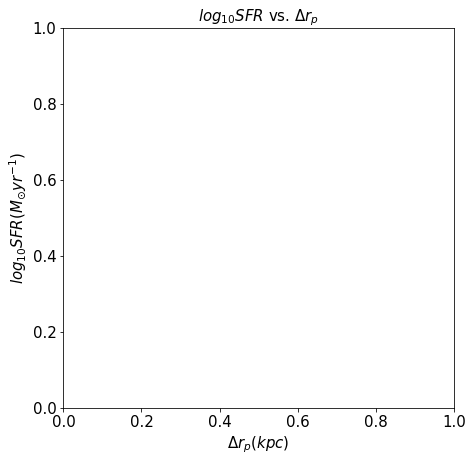

In [3]:
# logsfr vs. separation
plt.figure(figsize=[7,7])
plt.title('$log_{10}SFR$ vs. $\Delta r_p$',fontsize=15)
plt.xlabel('$\Delta r_p (kpc)$',fontsize=15)
plt.ylabel('$log_{10}SFR(M_{\odot} yr^{-1})$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# sep_all=[]
# logssfr_all=[]
fields = ['goodsn','goodss','egs']
candels_field = {'goodsn':'gdn_all','goodss':'gds_all_ssfr','egs':'egs_all'}
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu_pair = fits.getdata(path+'output/catalog_radec/'+field+'_pair_1000kms.fits',1)
    hdu_candels = fits.getdata(path+'intake/CANDELS/catalog/JFang_CANDELS_Data/'+candels_field[field]+'.fits',1)
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        c_spec = hdu_pair[hdu_pair['id']==idx]['count_spec'][0]
        if c_spec>0:
            logsfr = np.log10(hdu[num]['sfr_huang'])
            z = hdu[num]['z_used']
            ra,dec = hdu[num]['ra_candels'],hdu[num]['dec_candels']
            p1 = SkyCoord(ra*u.deg,dec*u.deg,frame='fk5')
            idx_candels = hdu_pair['com_id_can'][hdu_pair['id']==idx][0][hdu_pair['com_z_flag'][hdu_pair['id']==idx][0]==1]
            ra_companion,dec_companion = hdu_candels[hdu_candels['id']==idx_candels][0]['ra_1'],hdu_candels[hdu_candels['id']==idx_candels][0]['dec_1']
            p2 = SkyCoord(ra_companion*u.deg,dec_companion*u.deg,frame='fk5')
            mass_companion = 10**hdu_candels[hdu_candels['id']==idx_candels[0]]['m_med'][0]
            ssfr_companion = hdu_candels[hdu_candels['id']==idx_candels[0]]['ssfr_uv_corr'][0]
            sfr_companion = 10**ssfr_companion*mass_companion
            sfr = (sfr_companion+10**logsfr)/2
            sep = p1.separation(p2).arcsec*kpc_per_arcsec(z)
    #             sep_all.append(sep)
    #             logssfr_all.append(logsfr)
    #             if sfr>10**logsfr:
    #                 print(idx,hdu1[hdu1['id']==idx]['id_candels'],idx_candels[0],logsfr,np.log10(sfr_companion),hdu1_candels[hdu1_candels['id']==idx_candels[0]]['irac_ch4_flux'][0])
            plt.scatter(sep,np.log10(sfr),c='red',marker='o')
plt.savefig('/Users/lpr/Data/lirg_project/output/images/sfraverage_separation.pdf')

# <b>logSSFR vs. separation</b>

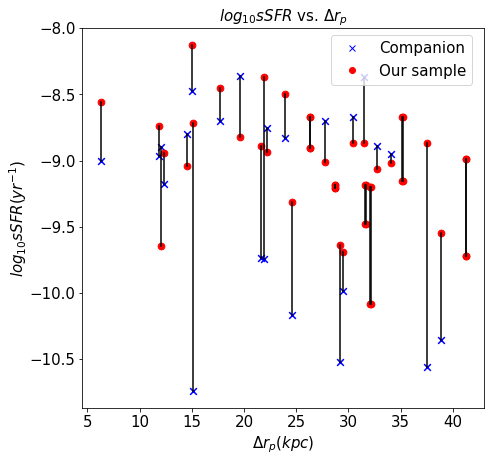

In [19]:
# logssfr vs. separation
plt.figure(figsize=[7.2,7])
plt.title('$log_{10}sSFR$ vs. $\Delta r_p$',fontsize=15)
plt.xlabel('$\Delta r_p (kpc)$',fontsize=15)
plt.ylabel('$log_{10}sSFR(yr^{-1})$',fontsize=15,labelpad=0.5)
plt.yticks(fontsize=15)#np.arange(-10,-7.9,0.5),np.around(np.arange(-10,-7.9,0.5),1),
plt.xticks(fontsize=15)
legend_elements=[Line2D([0],[0],lw=0,marker='x',color='blue',label='Companion'),Line2D([0],[0],lw=0,marker='o',color='red',label='Our sample')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left',bbox_to_anchor=[0.6,1.])
# sep_all=[]
# logssfr_all=[]
fields = ['goodsn','goodss','egs']
candels_field = {'goodsn':'gdn_all','goodss':'gds_all_ssfr','egs':'egs_all'}
# idx_list = []
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu_pair = fits.getdata(path+'output/catalog_radec/'+field+'_pair_1000kms.fits',1)
    hdu_candels = fits.getdata(path+'intake/CANDELS/catalog/JFang_CANDELS_Data/'+candels_field[field]+'.fits',1)
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        c_spec = hdu_pair[hdu_pair['id']==idx]['count_spec'][0]
        if c_spec>0:
            logssfr = np.log10(hdu[num]['sfr_huang']/10**hdu[num]['lmass_candels'])
            z = hdu[num]['z_used']
            ra,dec = hdu[num]['ra_candels'],hdu[num]['dec_candels']
            p1 = SkyCoord(ra*u.deg,dec*u.deg,frame='fk5')
            idx_candels = hdu_pair['com_id_can'][hdu_pair['id']==idx][0][hdu_pair['com_z_flag'][hdu_pair['id']==idx][0]==1]
            if idx_candels in hdu['id_candels']:
                ra_companion,dec_companion = hdu[hdu['id_candels']==idx_candels]['ra_candels'][0],hdu[hdu['id_candels']==idx_candels]['dec_candels'][0]
                ssfr_companion = np.log10(hdu[hdu['id_candels']==idx_candels]['sfr_huang'][0]/10**hdu[hdu['id_candels']==idx_candels]['lmass_candels'][0])
                p2 = SkyCoord(ra_companion*u.deg,dec_companion*u.deg,frame='fk5')
                sep = p1.separation(p2).arcsec*kpc_per_arcsec(z)
                plt.scatter(sep,logssfr,c='red',marker='o',s=45)
                plt.scatter(sep,ssfr_companion,c='red',marker='o',s=45)
                plt.plot([sep,sep],[logssfr,ssfr_companion],c='black')
#                 idx_list.append(idx)
            else:
                ra_companion,dec_companion = hdu_candels[hdu_candels['id']==idx_candels[0]]['ra_1'],hdu_candels[hdu_candels['id']==idx_candels[0]]['dec_1']
                p2 = SkyCoord(ra_companion*u.deg,dec_companion*u.deg,frame='fk5')
                ssfr_companion = hdu_candels[hdu_candels['id']==idx_candels[0]]['ssfr_uv_corr'][0]
                sep = p1.separation(p2).arcsec*kpc_per_arcsec(z)
                plt.scatter(sep,logssfr,c='red',marker='o',s=45)
                plt.scatter(sep,ssfr_companion,c='blue',marker='x',s=45)
                plt.plot([sep,sep],[logssfr,ssfr_companion],c='black')
# idx_list = np.array(idx_list)
# col = fits.Column(name='id',array=idx_list,format='K')
# fits.BinTableHDU.from_columns([col]).writeto('/Users/lpr/Data/lirg_project/output/pair/pair_in_16sample.fits',overwrite=True)
#             mass_companion = 10**hdu_candels[hdu_candels['id']==idx_candels[0]]['m_med'][0]
#             sfr_companion = 10**ssfr_companion*mass_companion
#             sfr = (sfr_companion+10**logsfr)/2
#             sep_all.append(sep)
#             logssfr_all.append(logsfr)
#             if sfr>10**logsfr:
#                 print(idx,hdu1[hdu1['id']==idx]['id_candels'],idx_candels[0],logsfr,np.log10(sfr_companion),hdu1_candels[hdu1_candels['id']==idx_candels[0]]['irac_ch4_flux'][0])
plt.savefig('/Users/lpr/Data/lirg_project/output/images/ssfrtwo_separation_both_in_sample.pdf')

# <b>$L_{IR}/M_*$ vs. separation</b>

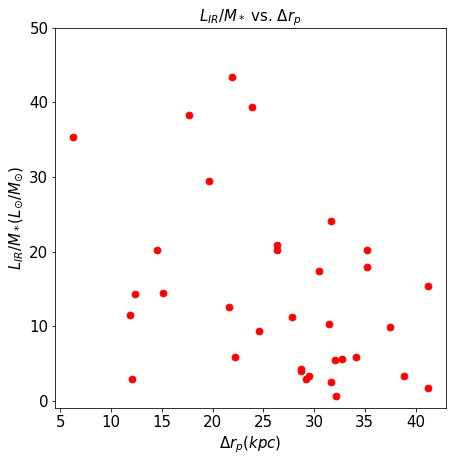

In [20]:
# L_ir/M_* vs. separation
plt.figure(figsize=[7,7])
plt.title('$L_{IR}/M_*$ vs. $\Delta r_p$',fontsize=15)
plt.xlabel('$\Delta r_p (kpc)$',fontsize=15)
plt.ylabel('$L_{IR}/M_*(L_{\odot}/M_{\odot})$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-1,50)
# sep_all=[]
# logssfr_all=[]
fields = ['goodsn','goodss','egs']
candels_field = {'goodsn':'gdn_all','goodss':'gds_all_ssfr','egs':'egs_all'}
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu_pair = fits.getdata(path+'output/catalog_radec/'+field+'_pair_1000kms.fits',1)
    hdu_candels = fits.getdata(path+'intake/CANDELS/catalog/JFang_CANDELS_Data/'+candels_field[field]+'.fits',1)
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        c_spec = hdu_pair[hdu_pair['id']==idx]['count_spec'][0]
        if c_spec>0:
            lir = 10**hdu[num]['lir_full']
            mass = 10**hdu[num]['lmass_candels']
            z = hdu[num]['z_used']
            ra,dec = hdu[num]['ra_candels'],hdu[num]['dec_candels']
            p1 = SkyCoord(ra*u.deg,dec*u.deg,frame='fk5')
            idx_candels = hdu_pair['com_id_can'][hdu_pair['id']==idx][0][hdu_pair['com_z_flag'][hdu_pair['id']==idx][0]==1]
            ra_companion,dec_companion = hdu_candels[hdu_candels['id']==idx_candels[0]]['ra_1'],hdu_candels[hdu_candels['id']==idx_candels[0]]['dec_1']
            p2 = SkyCoord(ra_companion*u.deg,dec_companion*u.deg,frame='fk5')
            sep = p1.separation(p2).arcsec*kpc_per_arcsec(z)
            plt.scatter(sep,lir/mass,c='red',marker='o',s=45)
plt.savefig('/Users/lpr/Data/lirg_project/output/images/lirmass_separation.pdf')

# <b>$SFR/SFR_{ms}$ vs. separation</b>

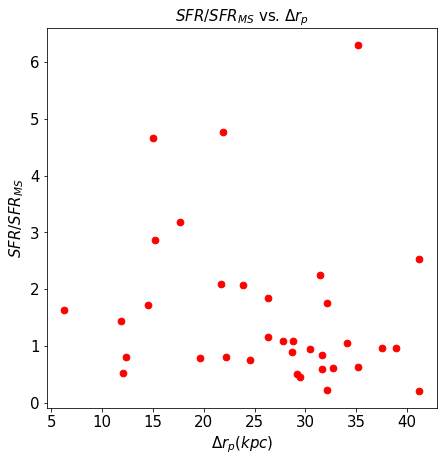

In [21]:
# $SFR/SFR_{ms}$ vs. separation
plt.figure(figsize=[7,7])
plt.title('$SFR/SFR_{MS}$ vs. $\Delta r_p$',fontsize=15)
plt.xlabel('$\Delta r_p (kpc)$',fontsize=15)
plt.ylabel('$SFR/SFR_{MS}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(-1,50)
# sep_all=[]
# logssfr_all=[]
fields = ['goodsn','goodss','egs']
candels_field = {'goodsn':'gdn_all','goodss':'gds_all_ssfr','egs':'egs_all'}
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu_pair = fits.getdata(path+'output/catalog_radec/'+field+'_pair_1000kms.fits',1)
    hdu_candels = fits.getdata(path+'intake/CANDELS/catalog/JFang_CANDELS_Data/'+candels_field[field]+'.fits',1)
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        c_spec = hdu_pair[hdu_pair['id']==idx]['count_spec'][0]
        if c_spec>0:
            logsfr = np.log10(hdu[num]['sfr_huang'])
            mass = hdu[num]['lmass_candels']
            z = hdu[num]['z_used']
            if z>0.78 and z<=0.93:
                s0,m0,gama = [1.35,9.96,1.28]
            elif z>0.93 and z<=1.11:
                s0,m0,gama = [1.53,10.1,1.26]
            elif z>1.11 and z<=1.3:
                s0,m0,gama = [1.72,10.31,1.07]
            deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
            ra,dec = hdu[num]['ra_candels'],hdu[num]['dec_candels']
            p1 = SkyCoord(ra*u.deg,dec*u.deg,frame='fk5')
            idx_candels = hdu_pair['com_id_can'][hdu_pair['id']==idx][0][hdu_pair['com_z_flag'][hdu_pair['id']==idx][0]==1]
            ra_companion,dec_companion = hdu_candels[hdu_candels['id']==idx_candels[0]]['ra_1'],hdu_candels[hdu_candels['id']==idx_candels[0]]['dec_1']
            p2 = SkyCoord(ra_companion*u.deg,dec_companion*u.deg,frame='fk5')
            sep = p1.separation(p2).arcsec*kpc_per_arcsec(z)
            plt.scatter(sep,deltaMS,c='red',marker='o',s=45)
plt.savefig('/Users/lpr/Data/lirg_project/output/images/sfrdiff_separation.pdf')

# <b>Sersic index histogram</b>

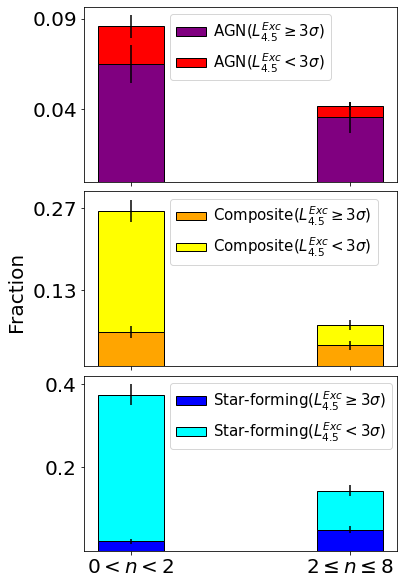

In [8]:
fields = ['goodsn','goodss','egs']
candels_field = {'goodsn':'gdn_all','goodss':'gds_all_ssfr','egs':'egs_all'}
sample_counts = 0
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    sample_counts += len(hdu)
crs = [['red','purple'],['yellow','orange'],['cyan','blue']]
sed_class = [[r'AGN($L_{4.5}^{Exc} < 3\sigma$)',r'AGN($L_{4.5}^{Exc} \geq 3\sigma$)'],['Composite($L_{4.5}^{Exc} < 3\sigma$)',r'Composite($L_{4.5}^{Exc} \geq 3\sigma$)'],[r'Star-forming($L_{4.5}^{Exc} < 3\sigma$)',r'Star-forming($L_{4.5}^{Exc} \geq 3\sigma$)']]
# ================= two bars version
xbins = [0,2,8]
xticks = np.arange(1,3)
fig,axs = plt.subplots(3,1,figsize=[5.5,8],constrained_layout=True,sharex=True)
fig.supylabel('Fraction',fontsize=20)
labels = ['$0 < n < 2$','$2 \leq n \leq 8$']
plt.xticks(ticks=xticks,labels=labels,fontsize=20)
statistics = {'agn_l4p5':[],'agn':[],'com_l4p5':[],'com':[],'sfg_l4p5':[],'sfg':[]}
sed_class_num1 = {0:'agn',1:'com',2:'sfg'}
broadsources = {'goodsn':23844, 'goodss':12353, 'egs':-99}
for num1 in [0,1,2]:
    for field in fields:
        hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
        hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
        hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
        hdu_candels = fits.getdata(path+'intake/CANDELS/catalog/JFang_CANDELS_Data/'+candels_field[field]+'.fits',1)
        hdu_re = fits.getdata(path+'output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
        # hdu_subpsf = fits.getdata(path+'output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
        hdu = hdu[hdu['id']!=broadsources[field]]
        hdu = hdu[hdu['tmp_class'][:,0]==num1+1]
        for num2 in range(len(hdu)):
            idx = hdu[num2]['id']
            flag_l4p5 = hdu[num2]['l4p5ex']/hdu[num2]['e4p5ex']
            if hdu_re[hdu_re['id']==idx]['n_f160w'] != -99.:
                n = hdu_re[hdu_re['id']==idx]['n_f160w'][0]
            else:
                n = hdu[num2]['n_f160w']
#             if idx in hdu_subpsf['id']:
#                 n = hdu_subpsf[hdu_subpsf['id']==idx]['n_sersic'][0]
#             elif hdu_re[hdu_re['id']==idx]['n_f160w'][0] != -99.0:
#                 n = hdu_re[hdu_re['id']==idx]['re_f160w'][0]
#             else:
#                 n = hdu[num2]['n_f160w']
            if flag_l4p5>=3:
                statistics[sed_class_num1[num1]+'_l4p5'].append(n)
            else:
                statistics[sed_class_num1[num1]].append(n)
    
    bobar = hist2bar(np.array(statistics[sed_class_num1[num1]+'_l4p5']),xbins,density=False)
    upbar = hist2bar(np.array(statistics[sed_class_num1[num1]]),xbins,density=False)
    axs[num1].bar(xticks,np.array(bobar[0])/sample_counts,yerr=np.array(bobar[1])/sample_counts,width=0.3,align='center',color=crs[num1][1],edgecolor='black',label=sed_class[num1][1])
    axs[num1].bar(xticks,np.array(upbar[0])/sample_counts,yerr=np.array(upbar[1])/sample_counts,bottom=np.array(bobar[0])/sample_counts,width=0.3,align='center',color=crs[num1][0],edgecolor='black',label=sed_class[num1][0])
    axs[num1].legend(fontsize=15,loc='upper left',bbox_to_anchor=(0.25, 1),facecolor='none',handletextpad=0.5,labelspacing=0.5,handleheight=0.5)
    ytick_max = np.amax(np.array(bobar[0])/sample_counts)+np.amax(np.array(upbar[0])/sample_counts)
    axs[num1].set_yticks([round(ytick_max/2,2),round(ytick_max,2)])
    axs[num1].tick_params(axis='y',labelsize='20')
fig.savefig('/Users/lpr/Data/lirg_project/output/images/n_sed_l4p5_2bars.pdf')

# <b>logSFR vs. Re</b>

<a list of 1 text.Text objects>

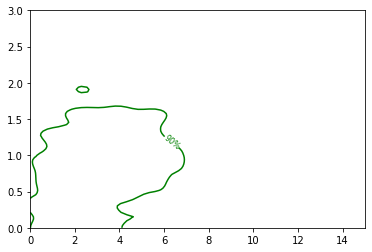

In [9]:
# logSFR vs. Re
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
re_can = []
logsfr_can = []
for field in fields:
    if field != 'goodss':
        hdu_candels=fits.getdata(path+'intake/CANDELS/catalog/JFang_CANDELS_Data/'+candels_names[field]+'_all_covermatch.fits',1)
        hdu_candels_copy = hdu_candels[(hdu_candels['zbest']>=0.8)&(hdu_candels['zbest']<=1.3)&(hdu_candels['CLASS_STAR']<0.5)&(hdu_candels['m_med']>=9.5)&(hdu_candels['m_med']<=11.5)]
        hdu_candels_copy['re_f160w'] = hdu_candels_copy['re_f160w']*kpc_per_arcsec(hdu_candels_copy['zbest'])
        hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_radec_candels.fits',1)
        hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
        hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
        for num1 in range(len(hdu_candels_copy)):
            id_can = hdu_candels_copy[num1]['id']
            if id_can not in hdu['id_candels']:
                re_can.append(hdu_candels_copy[num1]['re_f160w'])
                logsfr_can.append(np.log10(10**hdu_candels_copy[num1]['ssfr_uv_corr']*10**hdu_candels_copy[num1]['m_med']/1.06)) # 除以1.06是IMF的区别

re_can = np.array(re_can)
logsfr_can = np.array(logsfr_can)
h,xedges,yedges=np.histogram2d(re_can,logsfr_can,range=np.array([[0,15.],[0,3.]]),bins=np.array([20,20]))
# here to define the contour of 90% CANDELS data
percent = 0.89
temp = np.sort(h.flatten())[::-1]
count = np.sum(temp)
temp2 = 0
for num1 in range(0,len(temp)):
    temp2 += temp[num1]
    if temp2 > percent * count:
        break
cut1,pert1 = [temp[num1-1],(temp2-temp[num1])/count]
cut2,pert2 = [temp[num1],temp2/count]
f = interp1d([pert1,pert2],[cut1,cut2])
level_want = f(percent)

data = ndimage.zoom(h,[3,5])
x,y = np.linspace(xedges[0],xedges[-1],data.shape[0]),np.linspace(yedges[0],yedges[-1],data.shape[1])
contour = plt.contour(x,y,data.T,levels=[float(level_want)],colors=['green']) #xedges[0:xedges.shape[0]-1],yedges[0:yedges.shape[0]-1],h.T
plt.clabel(contour,contour.levels,inline=True,fontsize=8,fmt={1:'100%',float(level_want):'90%'},use_clabeltext=True,inline_spacing=0)

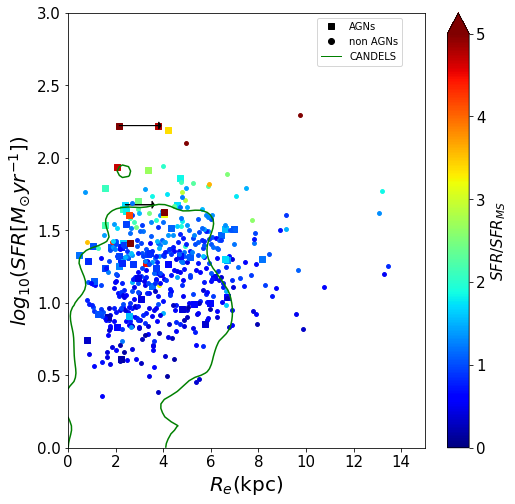

In [11]:
broadsources = {'goodsn':23844, 'goodss':12353, 'egs':-99}
smallSBs = dict()
symbols={1:'s',2:'o',3:'o',5:'o'}
symbols_pair = {True:'P',False:'*'}
color_pair = {True:'red',False:'blue'}
plt.figure(figsize=[8,8])
plt.contour(x,y,data.T,levels=[float(level_want)],colors=['green'])
plt.clabel(contour,contour.levels,inline=True,fontsize=8,fmt={1:'100%',float(level_want):'90%'},use_clabeltext=True,inline_spacing=0)
count = 0
pixel_scale= 0.06
for field in fields:
    id_ctg = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu = hdu[np.isin(hdu['id'],id_ctg['id'])]
    re_catalog = fits.getdata(path+'output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    subpsf_catalog = fits.getdata(path+'output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    smallSBs[field] = hdu[hdu['lir_full']>12.0]['id']
    hdu = hdu[hdu['id']!=broadsources[field]]
    # idx_list = []
    for num1 in range(hdu.size):
        idx = hdu[num1]['id']
        lmass_candels = hdu[num1]['lmass_candels']
        z = hdu[num1]['z_used']
        sed_class = hdu[num1]['TMP_CLASS'][0]
        logsfr = np.log10(hdu[num1]['sfr_huang'])
        if idx in subpsf_catalog['id']:
            re2 = subpsf_catalog[subpsf_catalog['id']==idx]['re_sersic'][0]*pixel_scale*kpc_per_arcsec(z)
            re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z)
            # if re2<re: print(field +'\n' + str(idx) + str(np.around(re,3)) + str(np.around(re2,3)))
        else:
            re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z) 
         
        if z>0.78 and z<=0.93:
            s0,m0,gama = [1.35,9.96,1.28]
        elif z>0.93 and z<=1.11:
            s0,m0,gama = [1.53,10.1,1.26]
        elif z>1.11 and z<=1.3:
            s0,m0,gama = [1.72,10.31,1.07]
        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**lmass_candels/10**m0)**(-1*gama))))
        # if deltaMS>3: idx_list.append(idx)
        if sed_class==1:
            symbol = 's'
            size = 30
        else:
            symbol = 'o'
            size = 15
        # if idx in smallSBs[field]: plt.scatter(re,logsfr,c='black',marker='P',s=200)
        plt.scatter(re,logsfr,c=deltaMS,marker=symbol,s=size,vmin=0,vmax=5,cmap='jet')
        
        if idx in subpsf_catalog['id'] and idx in smallSBs[field]:
            # plt.scatter(re2,logsfr,c=deltaMS,marker=symbol,s=size-15,vmin=0,vmax=5,cmap='jet',edgecolors='black')
            # plt.arrow(re+0.2,logsfr,dx=re2-re-0.5,dy=0,width=0.001,color='black',head_width=0.05,head_length=0.1)
            plt.arrow(re,logsfr,dx=re2-re,dy=0,width=0.001,color='black',head_width=0.05,head_length=0.1)
    # smallSBs[field] = idx_list

plt.ylim(0,3)
plt.ylabel('$log_{10}(SFR[M_{\odot}yr^{-1}])$',fontsize=20)
plt.xlabel('$R_e$(kpc)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cb = plt.colorbar(extend='max')#
cb.set_label('$SFR/SFR_{MS}$',fontsize=15)#log_{10}L_{4.5}^{Exc}
cb.ax.tick_params(labelsize=15)
legend_elements=[Line2D([0],[0],lw=0,marker='s',label=r'AGNs',color='black'),Line2D([0],[0],lw=0,marker='o',color='black',label=r'non AGNs'),Line2D([0],[0],lw=1,color='green',label=r'CANDELS')]
plt.legend(handles=legend_elements,fontsize=10,bbox_to_anchor=[0.95,1])
plt.savefig('/Users/lpr/Data/lirg_project/output/images/resfr_candels_MScoded_notype1qso.pdf')

In [8]:
# for field in fields:
#     array = dict()
#     array['id'] = []
#     array['ra'] = []
#     array['dec'] = []
#     hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
#     for idx in smallSBs[field]:
#         ra,dec = [hdu[hdu['id']==idx]['ra_candels'], hdu[hdu['id']==idx]['dec_candels']]
#         array['id'].append(idx)
#         array['ra'].append(ra)
#         array['dec'].append(dec)
#     col1 = fits.Column(name='id',array=np.array(array['id']),format='K')
#     col2 = fits.Column(name='ra',array=np.array(array['ra']),format='D')
#     col3 = fits.Column(name='dec',array=np.array(array['dec']),format='D')
#     fits.BinTableHDU.from_columns([col1,col2,col3]).writeto('/Users/lpr/Data/lirg_project/output/mass_corr/'+field+'_ULIRGs_ra_dec.fits',overwrite=True)
smallSBs

{'goodsn': array([15995, 11054, 19267,  6228, 18654, 11519, 22407, 23844, 27302]),
 'goodss': array([ 5811, 12353]),
 'egs': array([13003805, 13017707, 13026117, 13004291, 13034619])}

In [6]:
count = 0
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu = hdu[np.isin(hdu['id'],smallSBs[field])]
    print(hdu['id'],hdu['SFR_huang'],hdu['SFR_Flag'])
    # re_catalog = fits.getdata(path+'output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    # re_catalog = re_catalog[np.isin(re_catalog['id'],smallSBs[field])]
    # for idx in hdu['id']:
    #     if re_catalog[re_catalog['id']==idx]['re_f160w'][0]!=-99.:
    #         re = re_catalog[re_catalog['id']==idx]['re_f160w'][0]*0.06*kpc_per_arcsec(hdu[hdu['id']==idx]['z_used'][0])
            
    #     else:
    #         re = hdu[hdu['id']==idx]['re_f160w'][0]*kpc_per_arcsec(hdu[hdu['id']==idx]['z_used'][0])
    #     print(idx,re)


[15995 11054 19267  6228 18654 11519 22407 23844 27302] [ 77.76730347  44.70335007 125.960495   197.51248169  86.17074585
 166.50462341  72.88253784 359.06381226 167.02952576] ['8umSFR' '8umSFR' '8umSFR' '8umSFR' '8umSFR' '8umSFR' '8umSFR' 'FIRSFR'
 'FIRSFR']
[ 5811 12353] [ 54.89757538 207.65411377] ['8umSFR' 'FIRSFR']
[13003805 13017707 13026117 13004291 13034619] [ 87.52027893  47.50414658  60.95773697 154.51460266  39.33828735] ['8umSFR' '8umSFR' '8umSFR' '8umSFR' '8umSFR']


# <b>在SFR vs. Re图中，有几个有非常高的SFR的星系，在做减PSF之前他们的Re非常小</b>

# <b>Size Mass relation</b>

In [12]:
# construct size mass relation according to van der Wel+14
def mass_size(mass,loga,alpha):
    m = (10**mass/10**10)/5
    re = (10**loga)*(m**alpha)
    return re
loga_early=[0.60,0.42,0.22,0.09,-0.05,-0.06]
alpha_early=[0.75,0.71,0.76,0.76,0.76,0.79]
loga_late=[0.86,0.78,0.70,0.65,0.55,0.51]
alpha_late=[0.25,0.22,0.22,0.23,0.22,0.18]
z_mass_size=[0.25,0.75,1.25,1.75,2.25,2.75]
def Da(z,H0,omega_matter):
    angular_distance = flcdm(H0=H0,Om0=omega_matter).angular_diameter_distance(z).to_value()
    return angular_distance
loga_early_9=interp1d(z_mass_size,loga_early)(0.9)
alpha_early_9=interp1d(z_mass_size,alpha_early)(0.9)
loga_late_9=interp1d(z_mass_size,loga_late)(0.9)
alpha_late_9=interp1d(z_mass_size,alpha_late)(0.9)
mass_late = np.linspace(9,11.4,100)
mass_early = np.linspace(10,11.4,100)
re_late_9 = (Da(0.9,71,0.27)/Da(0.9,70,0.3))**(2*alpha_late_9-1) * mass_size(mass_late,loga_late_9,alpha_late_9)
re_early_9 = (Da(0.9,71,0.27)/Da(0.9,70,0.3))**(2*alpha_early_9-1) * mass_size(mass_early,loga_early_9,alpha_early_9)
re_late_125 = (Da(1.25,71,0.27)/Da(1.25,70,0.3))**(2*0.22-1) * mass_size(mass_late,0.7,0.22)
re_early_125 = (Da(1.25,71,0.27)/Da(1.25,70,0.3))**(2*0.76-1) * mass_size(mass_early,0.22,0.76)

loga_early_1=interp1d(z_mass_size,loga_early)(1)
alpha_early_1=interp1d(z_mass_size,alpha_early)(1)
loga_late_1=interp1d(z_mass_size,loga_late)(1)
alpha_late_1=interp1d(z_mass_size,alpha_late)(1)

mass_late = np.linspace(9,11.4,100)
mass_early = np.linspace(10,11.4,100)
re_late_1 = (Da(1,71,0.27)/Da(1,70,0.3))**(2*alpha_late_1-1) * mass_size(mass_late,loga_late_1,alpha_late_1)
re_early_1 = (Da(1,71,0.27)/Da(1,70,0.3))**(2*alpha_early_1-1) * mass_size(mass_early,loga_early_1,alpha_early_1)
# early-type关系的截距loga的误差
sigma_y1,sigma_y2 = 0.01,0.01
sigma_x1,sigma_x2 = 0.0,0.0
x1,x2,y1,y2 = 0.75,1.25,0.42,0.22
equa0 = (y1-y2)/(x1-x2)
sigma0 = np.sqrt(sigma_y1**2+sigma_y2**2) #y1-y2的误差
sigma1 = np.sqrt(sigma_x1**2+sigma_x2**2) #x1-x2的误差
sigma2 = equa0*np.sqrt( (sigma0/(y1-y2))**2 + (sigma1/(x1-x2))**2 ) #(y1-y2)/(x1-x2)的误差
sigma3 = x1*equa0*np.sqrt( (sigma_x1/x1)**2 + (sigma2/(equa0))**2 ) #x1*(y1-y2)/(x1-x2)的误差
sigma_early_loga = np.sqrt( sigma_y1**2 + sigma3**2 )
# 补充early-type的截距的3sigma的关系
re_early_10 = (Da(1,71,0.27)/Da(1,70,0.3))**(2*alpha_early_1-1) * mass_size(mass_early,loga_early_1-3*sigma_early_loga,alpha_early_1)
re_early_11 = (Da(1,71,0.27)/Da(1,70,0.3))**(2*alpha_early_1-1) * mass_size(mass_early,loga_early_1+3*sigma_early_loga,alpha_early_1)

(0.3, 19)

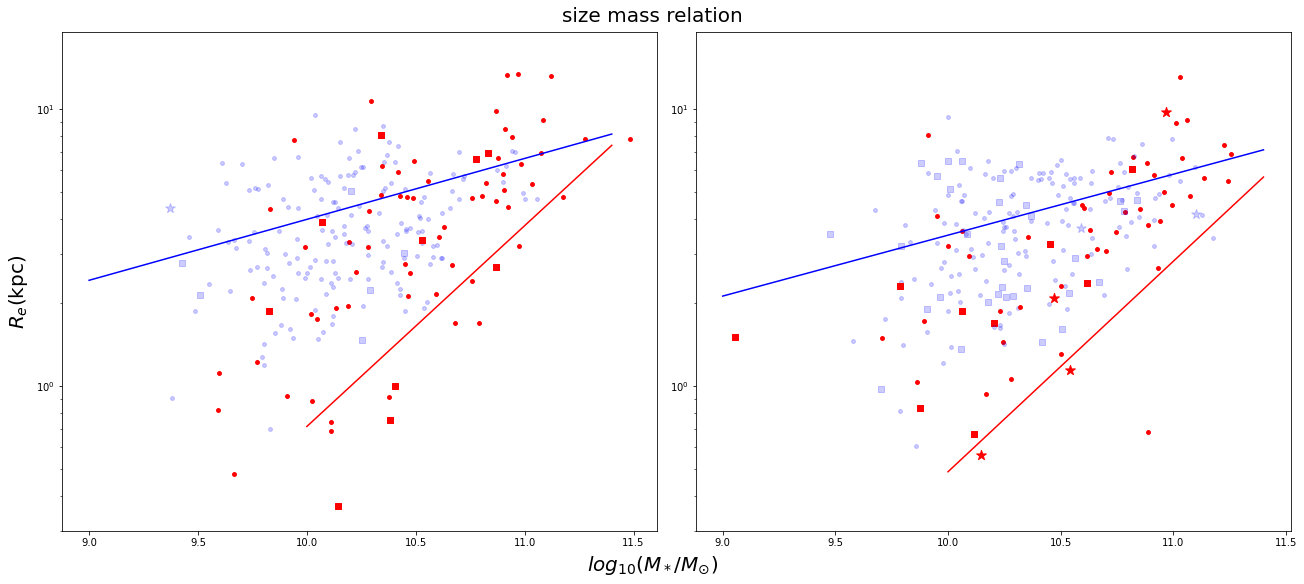

In [7]:
# size mass diagram
cmap = (mpl.colors.ListedColormap(['blue', 'red']))
Norm_bound = mpl.colors.BoundaryNorm([0.2,2,8], cmap.N)
# cmap = mpl.cm.jet
# norm = mpl.colors.Normalize(vmin=0.2,vmax=4)#vmin=0,vmax=5   vmin=9,vmax=11
fields_list = ['goodsn','goodss','egs']
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
fig,axs = plt.subplots(1,2,figsize=[18,8],constrained_layout=True)#12.5,5
fig.supxlabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
fig.supylabel('$R_e$(kpc)',fontsize=20)
fig.suptitle('size mass relation',fontsize=20)
axs[0].plot(mass_early,re_early_9,color='red',label='early-type')
axs[1].plot(mass_early,re_early_125,color='red',label='early-type')
axs[0].plot(mass_late,re_late_9,color='blue',label='late-type')
axs[1].plot(mass_late,re_late_125,color='blue',label='late-type')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
pixel_scale= 0.06
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    hdu = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu = hdu[np.isin(hdu['id'],id_ctg['id'])]
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    for num1 in range(hdu.size):
        idx = hdu[num1]['id']
        z = hdu[num1]['z_used']
        if z<=1:
            lmass_candels = hdu[num1]['lmass_candels']
            sed_class = hdu[num1]['TMP_CLASS'][0]
            re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z)
    #         re要换成5000AA的re,van+14
            re = re-10**((-0.35+0.12*z-0.25*(lmass_candels-10))*np.log10(16000/(1+z)-5000))
            if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
                n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
            else:
                n=hdu[num1]['n_f160w']
            if idx in smallSBs:
                symbol = '*'
                size = 105
            elif sed_class==1:
                symbol = 's'
                size = 30
            else:
                symbol = 'o'
                size = 15
            if n>0.2 and n<=2:
                alpha=0.2
            elif n>2 and n<=8:
                alpha=1
            axs[0].scatter(lmass_candels,re,c=n,norm=Norm_bound,cmap=cmap,marker=symbol,s=size,alpha=alpha)
        elif z>1:
            lmass_candels = hdu[num1]['lmass_candels']
            sed_class = hdu[num1]['TMP_CLASS'][0]

            re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z)
    #         re要换成5000AA的re,van+14
            re = re-10**((-0.35+0.12*z-0.25*(lmass_candels-10))*np.log10(16000/(1+z)-5000))
            if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
                n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
            else:
                n=hdu[num1]['n_f160w']
            if idx in smallSBs:
                symbol = '*'
                size = 105
            elif sed_class==1:
                symbol = 's'
                size = 30
            else:
                symbol = 'o'
                size = 15
            if n>0.2 and n<=2:
                alpha=0.2
            elif n>2 and n<=8:
                alpha=1
            axs[1].scatter(lmass_candels,re,c=n,norm=Norm_bound,cmap=cmap,marker=symbol,s=size,alpha=alpha)
axs[0].set_ylim(0.3,19)
axs[1].set_ylim(0.3,19)
# axs.tick_params(axis='both',labelsize=15)
# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='both',location='top')#
# cb.set_label(label='$SFR/SFR_{MS}$',fontsize=15) #$L_{4.5}^{Exc}$
# cb.ax.tick_params(labelsize=15)
# # legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='*',color='blue',label=r'disk AGNs'),Line2D([0],[0],lw=0,marker='*',color='red',label=r'bulge AGNs'),Line2D([0],[0],lw=0,marker='o',color='blue',label='disk galaxies'),Line2D([0],[0],lw=0,marker='o',color='red',label='bulge galaxies')]
# legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='s',label='AGNs'),Line2D([0],[0],lw=0,marker='o',label='non AGNs')]
# plt.legend(handles=legend_elements,fontsize=15,loc='upper left',bbox_to_anchor=[0.6,0.3])
# # fig.savefig('/Users/lpr/Data/lirg_project/output/images/size_mass_sfrcoded.pdf')#l4p5ex

In [40]:
# size mass diagram
cmap = (mpl.colors.ListedColormap(['blue', 'red']))
Norm_bound = mpl.colors.BoundaryNorm([0.2,2,8], cmap.N)
# cmap = mpl.cm.jet
# norm = mpl.colors.Normalize(vmin=0.2,vmax=4)#vmin=0,vmax=5   vmin=9,vmax=11
fields_list = ['goodsn','goodss','egs']
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
bulge_params = []
disk_params = []
pixel_scale= 0.06
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    hdu = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu = hdu[np.isin(hdu['id'],id_ctg['id'])]
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    for num1 in range(hdu.size):
        idx = hdu[num1]['id']
        z = hdu[num1]['z_used']
        lmass_candels = hdu[num1]['lmass_candels']
        sed_class = hdu[num1]['TMP_CLASS'][0]
        logsfr = np.log10(hdu[num1]['sfr_huang'])
        l4p5ex = np.log10(hdu[num1]['l4p5ex'])
        re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z)
    #        re要换成5000AA的re,van+14
        re = re-10**((-0.35+0.12*z-0.25*(lmass_candels-10))*np.log10(16000/(1+z)-5000))
        if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
            n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
        else:
            n=hdu[num1]['n_f160w']
        if n>0.2 and n<=2.5:
            disk_params.append([re,lmass_candels,n])
        elif n>2.5 and n<=8:
            bulge_params.append([re,lmass_candels,n])
bulge_params = np.array(bulge_params)
disk_params = np.array(disk_params)

<ipython-input-40-b87201b4d837>:23: RuntimeWarning: divide by zero encountered in log10
  l4p5ex = np.log10(hdu[num1]['l4p5ex'])


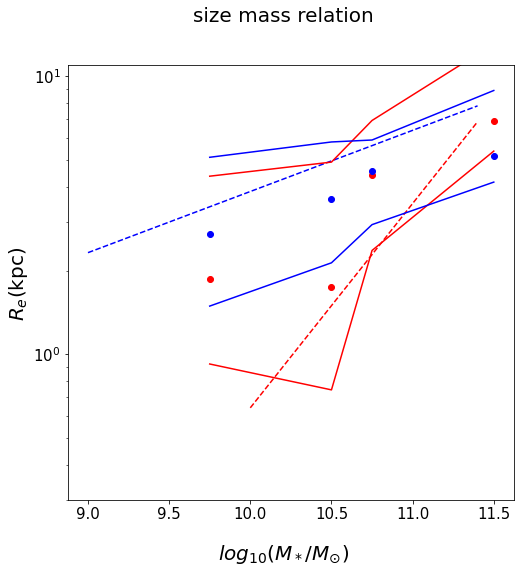

In [41]:
fig = plt.figure(figsize=[8,8])
fig.supxlabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
fig.supylabel('$R_e$(kpc)',fontsize=20)
fig.suptitle('size mass relation',fontsize=20)
plt.plot(mass_early,re_early_1,'--r',label='early-type')
plt.plot(mass_late,re_late_1,'--b',label='late-type')
plt.yscale('log')
points = []
upper_bounds = []
lower_bounds = []
for bounds in [9.5,10,10.5,11]:
    temp = bulge_params[:,0][(bulge_params[:,1]>=bounds)&(bulge_params[:,1]<bounds+0.5)]
    points.append(np.median(temp))
    upper_bounds.append(np.sort(temp)[int(0.16*len(temp))])
    lower_bounds.append(np.sort(temp)[int(0.84*len(temp))])
plt.scatter([9.75,10.5,10.75,11.5],points,color='red')
plt.plot([9.75,10.5,10.75,11.5],upper_bounds,color='red')
plt.plot([9.75,10.5,10.75,11.5],lower_bounds,color='red')

points = []
upper_bounds = []
lower_bounds = []
for bounds in [9.5,10,10.5,11]:
    temp = disk_params[:,0][(disk_params[:,1]>=bounds)&(disk_params[:,1]<bounds+0.5)]
    points.append(np.median(temp))
    upper_bounds.append(np.sort(temp)[int(0.16*len(temp))])
    lower_bounds.append(np.sort(temp)[int(0.84*len(temp))])
plt.scatter([9.75,10.5,10.75,11.5],points,color='blue')
plt.plot([9.75,10.5,10.75,11.5],upper_bounds,color='blue')
plt.plot([9.75,10.5,10.75,11.5],lower_bounds,color='blue')

plt.ylim(0.3,11)
plt.tick_params(axis='both',labelsize=15)
# legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='s',label='AGNs'),Line2D([0],[0],lw=0,marker='o',label='non AGNs')]
# plt.legend(handles=legend_elements,fontsize=15,bbox_to_anchor=[0.4,0.9])#loc='upper left',
# fig.savefig('/Users/lpr/Data/lirg_project/output/images/size_mass_sfrcoded.pdf')#l4p5ex

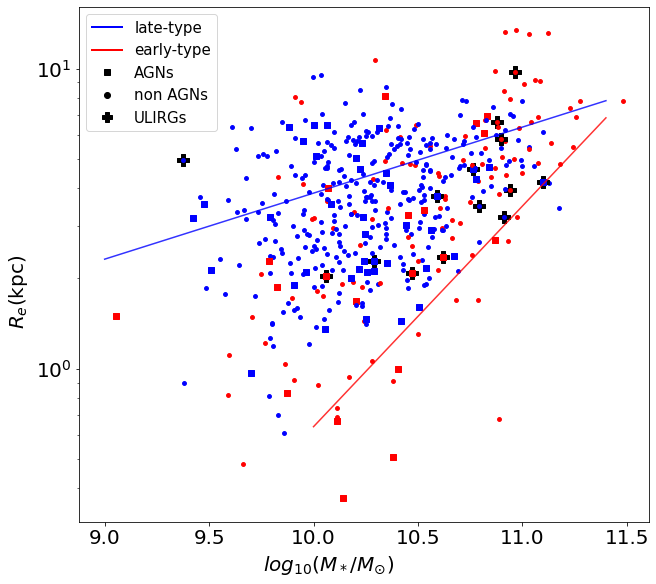

In [18]:
# size mass diagram
count_all,count_AGN = 0,0 #用来计算到底多少AGN在early-type关系及以下
cmap = (mpl.colors.ListedColormap(['blue', 'red']))
Norm_bound = mpl.colors.BoundaryNorm([0.2,2,8], cmap.N)
# cmap = mpl.cm.jet
# norm = mpl.colors.Normalize(vmin=0.2,vmax=4)#vmin=0,vmax=5   vmin=9,vmax=11
# fields_list = ['goodsn','egs']
# jfang_fields = {'goodsn':'gdn_all.fits','egs':'egs_all.fits'}
# root_path = '/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/'
fig,axs = plt.subplots(1,1,figsize=[9,8],constrained_layout=True)#12.5,5
fig.supxlabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
fig.supylabel('$R_e$(kpc)',fontsize=20)
axs.plot(mass_early,re_early_1,color='red',alpha=0.8)
axs.plot(mass_late,re_late_1,color='blue',alpha=0.8)
# 补充early-type的3sigma的图
# axs.plot(mass_early,re_early_10,color='red',alpha=0.3)
# axs.plot(mass_early,re_early_11,color='red',alpha=0.3)
axs.set_yscale('log')
axs.tick_params(axis='both',labelsize=20)
legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type'),Line2D([0],[0],lw=2,color='r',label='early-type'),Line2D([0],[0],lw=0,color='black',marker='s',label='AGNs'),Line2D([0],[0],lw=0,color='black',marker='o',label='non AGNs'),Line2D([0],[0],lw=0,marker='P',label='ULIRGs',color='black',markersize=10)]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left',bbox_to_anchor=(0.,0.9,0.1,0.1))
# pixel_scale= 0.06
# for field in fields_list:
#     hdu = fits.getdata(root_path+jfang_fields[field],1)
#     hdu = hdu[(hdu['class_star']<0.3)&(hdu['zbest']>0.8)&(hdu['zbest']<1.3)&(hdu['m_med']>9)&(hdu['m_med']<11.7)]
#     axs.scatter(hdu['m_med'],hdu['re_f160w']*kpc_per_arcsec(hdu['zbest'])-10**((-0.35+0.12*hdu['zbest']-0.25*(hdu['m_med']-10))*np.log10(16000/(1+hdu['zbest'])-5000)),c=hdu['n_f160w'],norm=Norm_bound,cmap=cmap,alpha=0.05,s=5)
# axs.set_ylim(0.1,19)
# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=Norm_bound,cmap=cmap),extend='both',location='top')#
# cb.set_label(label='$SFR/SFR_{MS}$',fontsize=15) #$L_{4.5}^{Exc}$
# cb.ax.tick_params(labelsize=15)
# # legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='*',color='blue',label=r'disk AGNs'),Line2D([0],[0],lw=0,marker='*',color='red',label=r'bulge AGNs'),Line2D([0],[0],lw=0,marker='o',color='blue',label='disk galaxies'),Line2D([0],[0],lw=0,marker='o',color='red',label='bulge galaxies')]
broadsources = {'goodsn':23844, 'goodss':12353, 'egs':-99}
from matplotlib.markers import MarkerStyle
# size mass diagram
fields_list = ['goodsn','goodss','egs']
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    hdu = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu = hdu[np.isin(hdu['id'],id_ctg['id'])]
    hdu = hdu[hdu['id']!=broadsources[field]]
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    masscorr_ctg = fits.getdata(root_path + field + '_mass_corr.fits',1)
    for num1 in range(hdu.size):
        idx = hdu[num1]['id']
        # lmass_candels = np.around(hdu[num1]['lmass_candels'],2)
        mass, mass_new, re, re_new = [0, 0, 0, 0]
        mass = hdu[num1]['lmass_candels']
        if idx in masscorr_ctg['id']: mass_new = masscorr_ctg[masscorr_ctg['id']==idx]['lmass_corr'][0] 
        z = hdu[num1]['z_used']
        sed_class = hdu[num1]['TMP_CLASS'][0]
        re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z)
    #        re要换成5000AA的re,van+14
        re = np.around(re-10**((-0.35+0.12*z-0.25*({True:mass, False:mass_new}[mass_new==0]-10))*np.log10(16000/(1+z)-5000)),2)
        if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
            n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
        else:
            n=hdu[num1]['n_f160w']
        if sed_class==1:
            symbol = 's'
            size = 30
        else:
            symbol = 'o'
            size = 15
        if idx in smallSBs[field]:
            # axs.text(lmass_candels,re,str(idx))
            axs.scatter(mass,re,color='black',marker='P',s=150)
            # axs.scatter({True:mass, False:mass_new}[mass_new==0],re,c=n,norm=Norm_bound,cmap=cmap,marker=symbol,s=size)
            axs.scatter(mass,re,c=n,norm=Norm_bound,cmap=cmap,marker=symbol,s=size)
        else:
            axs.scatter(mass,re,c=n,norm=Norm_bound,cmap=cmap,marker=symbol,s=size)
        if re<mass_size({True:mass, False:mass_new}[mass_new==0],loga_early_1+3*sigma_early_loga,alpha_early_1):
            count_all += 1
            if sed_class==1:
                count_AGN += 1
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/size_mass_ncoded.pdf')
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/sizemass_ULIRGs_massuncorr_notype1qso.pdf')

In [19]:
print('early-type关系上3sigma之下的AGN的比例：')
print(count_AGN/count_all)
print('AGN占总样本的比例：')
aaa = 0
fields_list = ['goodsn','goodss','egs']
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    hdu = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu = hdu[np.isin(hdu['id'],id_ctg['id'])]
    hdu = hdu[hdu['id']!=broadsources[field]]
    aaa += hdu[hdu['tmp_class'][:,0]==1].size
print(aaa/477)

early-type关系上3sigma之下的AGN的比例：
0.3225806451612903
AGN占总样本的比例：


0.1278825995807128


# <b>UVJ diagram</b>

In [26]:
# UVJ slope
k = 0.88
# UVJ intersection
b = 0.59
# UVJ inclined separation line
l_x = np.linspace(((1.3-b)/k),1.5966274,100)
l_y = k*l_x+b
# UVJ extinction direction
x_tail = 1.25
y_tail = 0.5
x_head = 2
y_head = 1.0
dx = x_head - x_tail
dy = y_head - y_tail
arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),mutation_scale=100)

#### <b>according to CANDELS rest-frame UVJ magnitude, derive 16um sample rest-frame UVJ magnitude</b>

In [28]:
# 如果没有其他uvj星等要用的话，就不用执行了
fields_list = ['goodsn','goodss','egs']
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
for field in fields_list:
    mat_catalog = fits.open(root_path+field+'_Huangall_candels_van_params_modifyz.fits')[1].data
    mat_id_catalog = fits.getdata(root_path+field+'_id.fits',1)
    if field=='goodsn':
        candels_catalog = fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/gdn_all.fits')[1].data
    elif field=='goodss':
        candels_catalog = fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/gds_all.fits')[1].data
    elif field=='egs':
        candels_catalog = fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/egs_all.fits')[1].data
#     mat_catalog = mat_catalog[np.where((mat_catalog['z_used']<=1.3)&(mat_catalog['z_used']>=0.8)&(mat_catalog['ID']!=-1)&(mat_catalog['Separation_candels_16']<1))]
    mat_catalog = mat_catalog[np.isin(mat_catalog['id'],mat_id_catalog['id'])]
    id_array = np.full((mat_catalog.size,2),-99)
    array = np.full((mat_catalog.size,6),-999.)
    for num1 in range(0,mat_catalog.size):
        idx = mat_catalog[num1]['ID']
        idx_candels = mat_catalog[num1]['ID_CANDELS']
        umag_6a_deltau = candels_catalog[np.where(candels_catalog['ID']==idx_candels)]['Umag_6a_deltau']
        vmag_6a_deltau = candels_catalog[np.where(candels_catalog['ID']==idx_candels)]['Vmag_6a_deltau']
        jmag_6a_deltau = candels_catalog[np.where(candels_catalog['ID']==idx_candels)]['Jmag_6a_deltau']
        umag_bessel = candels_catalog[np.where(candels_catalog['ID']==idx_candels)]['restUXbessel']
        vmag_bessel = candels_catalog[np.where(candels_catalog['ID']==idx_candels)]['restVbessel']
        jmag_palomar = candels_catalog[np.where(candels_catalog['ID']==idx_candels)]['restJpalomar']
        id_array[num1]=[idx,idx_candels]
        array[num1] = [umag_6a_deltau,vmag_6a_deltau,jmag_6a_deltau,umag_bessel,vmag_bessel,jmag_palomar]
    col0 = fits.Column(name='ID',array=id_array[:,0],format='K')
    col1 = fits.Column(name='ID_CANDELS',array=id_array[:,1],format='K')
    col2 = fits.Column(name='Umag_CANDELS_6a_deltau',array=array[:,0],format='D')
    col3 = fits.Column(name='Vmag_CANDELS_6a_deltau',array=array[:,1],format='D')
    col4 = fits.Column(name='Jmag_CANDELS_6a_deltau',array=array[:,2],format='D')
    col5 = fits.Column(name='Umag_CANDELS_bessel',array=array[:,3],format='D')
    col6 = fits.Column(name='Vmag_CANDELS_bessel',array=array[:,4],format='D')
    col7 = fits.Column(name='Jmag_CANDELS_palomar',array=array[:,5],format='D')
    hdu = fits.BinTableHDU.from_columns([col0,col1,col2,col3,col4,col5,col6,col7])
    hdu.writeto(root_path+field+'_restUVJ_new.fits',overwrite=True)

<ipython-input-28-7e7014e5367f>:27: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  array[num1] = [umag_6a_deltau,vmag_6a_deltau,jmag_6a_deltau,umag_bessel,vmag_bessel,jmag_palomar]


23844
12353


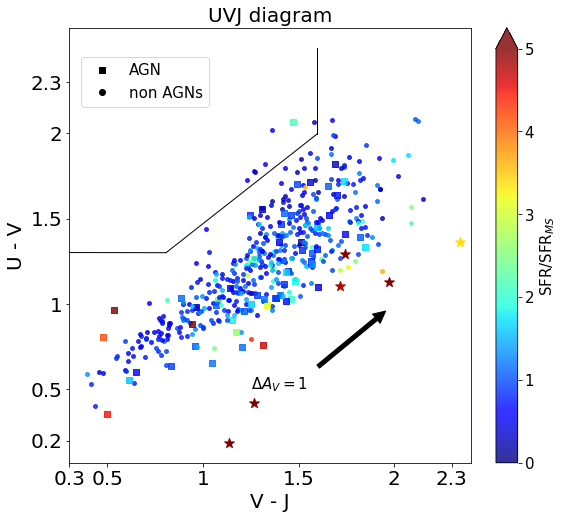

In [29]:
# UVJ diagram
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
plt.figure(figsize=[9,8])
plt.xlabel('V - J',fontsize=20)
plt.ylabel('U - V',fontsize=20)
plt.title('UVJ diagram',fontsize=20)
for field in fields: # two parts of galaxies' UVJ
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    hdu = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    uvj_catalog = fits.getdata(root_path+field+'_restUVJ_new.fits',1)
    hdu = hdu[np.isin(hdu['id'],id_ctg['id'])]
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    for num1 in range(hdu.size):
        idx = hdu[num1]['id']
        z = hdu[num1]['z_used']
        idx_candels = hdu[num1]['id_candels']
        logsfr = np.log10(hdu[num1]['sfr_huang'])
        lmass_candels = hdu[num1]['lmass_candels']
        umag = uvj_catalog[uvj_catalog['id']==idx]['Umag_CANDELS_bessel']
        vmag = uvj_catalog[uvj_catalog['id']==idx]['Vmag_CANDELS_bessel']
        jmag = uvj_catalog[uvj_catalog['id']==idx]['Jmag_CANDELS_palomar']
        sed_class = hdu[num1]['tmp_class'][0]
        if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
            n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
        else:
            n=hdu[num1]['n_f160w']
        if z>0.78 and z<=0.93:
            s0,m0,gama = [1.35,9.96,1.28]
        elif z>0.93 and z<=1.11:
            s0,m0,gama = [1.53,10.1,1.26]
        elif z>1.11 and z<=1.3:
            s0,m0,gama = [1.72,10.31,1.07]
        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**lmass_candels/10**m0)**(-1*gama))))
        if sed_class==1:
            if idx in smallSBs:
                symbol = '*'
                size = 105
                alpha = 1
            else:
                symbol = 's'
                size = 35
                alpha = 0.8
        else:
            if idx in smallSBs:
                symbol = '*'
                size = 105
                alpha = 1
            else:
                symbol = 'o'
                size = 15
                alpha = 0.8
        if vmag-jmag>1 and vmag<1.5 and umag-vmag>0.1 and umag-vmag<0.5:
            print(idx)
        plt.scatter(vmag-jmag,umag-vmag,c=deltaMS,marker=symbol,s=size,vmin=0,vmax=5,cmap='jet',alpha=alpha)
plt.annotate(r'$\Delta A_V=1$',xy=(x_head,y_head),xytext=(x_tail,y_tail),arrowprops=dict(facecolor='black', shrink=0.1),fontsize=15)
plt.plot([0,((1.3-b)/k)],[1.3014119,1.3],color='black',linewidth=1)
plt.plot([1.5966274,1.5966274],[k*1.5966274+b,2.5],color='black',linewidth=1)
plt.plot(l_x,l_y,color='black',linewidth=1)
plt.xlim(0.3,2.4)
# plt.ylim(0.2,2.3)
plt.xticks([0.3,0.5,1,1.5,2,2.3],[0.3,0.5,1,1.5,2,2.3],fontsize=20)
plt.yticks([0.2,0.5,1,1.5,2,2.3],[0.2,0.5,1,1.5,2,2.3],fontsize=20)
cb = plt.colorbar(location='right',extend='max')
cb.set_label('SFR/SFR$_{MS}$',fontsize=15)#
cb.ax.tick_params(labelsize=15)
legend_elements=[Line2D([0],[0],lw=0,marker='s',color='black',label=r'AGN'),Line2D([0],[0],lw=0,marker='o',color='black',label='non AGNs')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left',bbox_to_anchor=[0.01,0.95])
plt.savefig('/Users/lpr/Data/lirg_project/output/images/UVJ_sfrcoded.pdf')

# <b>Barro diagram</b>

In [20]:
# barro diagram
hdu2_candels=fits.getdata('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/egs_all.fits',1)
hdu2_candels_copy = hdu2_candels[np.where((hdu2_candels['zbest']>=0.8)&(hdu2_candels['zbest']<=1.3)&(hdu2_candels['CLASS_STAR']<0.5)&(hdu2_candels['M_med']>9.5)&(hdu2_candels['M_med']<11.5))]
hdu1_candels=fits.getdata('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/gdn_all.fits',1)
hdu1_candels_copy = hdu1_candels[np.where((hdu1_candels['zbest']>=0.8)&(hdu1_candels['zbest']<=1.3)&(hdu1_candels['CLASS_STAR']<0.5)&(hdu1_candels['M_med']>9.5)&(hdu1_candels['M_med']<11.5))]

# barro diagram
for num2 in range(0,len(hdu2_candels_copy)):
    hdu2_candels_copy[num2]['re_f160w'] = hdu2_candels_copy[num2]['re_f160w']*kpc_per_arcsec(hdu2_candels_copy[num2]['zbest'])
for num2 in range(0,len(hdu1_candels_copy)):
    hdu1_candels_copy[num2]['re_f160w'] = hdu1_candels_copy[num2]['re_f160w']*kpc_per_arcsec(hdu1_candels_copy[num2]['zbest'])
m_log_can = np.concatenate((hdu2_candels_copy['M_med'],hdu1_candels_copy['M_med']),axis=0)
re_can = np.concatenate((hdu2_candels_copy['re_f160w'],hdu1_candels_copy['re_f160w']),axis=0)
ssfr_can = np.concatenate((hdu2_candels_copy['ssfr_uv_corr'],hdu1_candels_copy['ssfr_uv_corr']),axis=0)
h,xedges,yedges=np.histogram2d(np.log10(10**m_log_can/re_can**1.5),np.log10(10**ssfr_can*1e9),range=np.array([[8,13.5],[-2.5,2]]),bins=np.array([20,30]))
# here to define the contour of 90% CANDELS data in barro+13 diagram
percent = 0.9
temp = np.sort(h.flatten())[::-1]
count = np.sum(temp)
temp2 = 0
for num1 in range(0,len(temp)):
    temp2 += temp[num1]
    if temp2 > percent * count:
        break
cut1,pert1 = [temp[num1-1],(temp2-temp[num1])/count]
cut2,pert2 = [temp[num1],temp2/count]
f = interp1d([pert1,pert2],[cut1,cut2])
level_want = f(percent)

<ipython-input-20-38be2bc7d858>:15: RuntimeWarning: invalid value encountered in power
  h,xedges,yedges=np.histogram2d(np.log10(10**m_log_can/re_can**1.5),np.log10(10**ssfr_can*1e9),range=np.array([[8,13.5],[-2.5,2]]),bins=np.array([20,30]))


<ipython-input-25-f0a1f66d8b7d>:86: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max')#


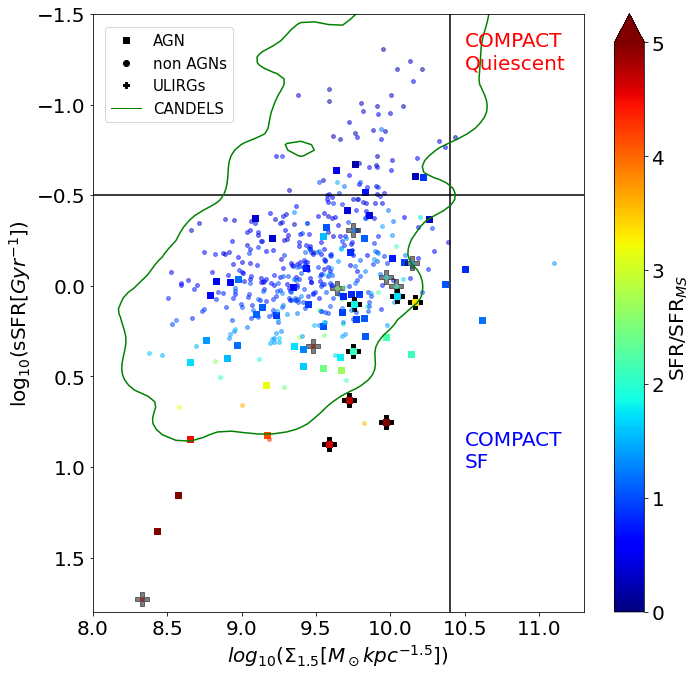

In [25]:
# barro diagram
mass_all = []
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0,vmax=5)
pixel_scale = 0.06
fig = plt.figure(figsize=(11,11))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0])
ax.plot([10.4,10.4],[-2.5,2.5],color='black')
ax.plot([7.5,11.5],[-0.5,-0.5],color='black')
fields_list = ['goodsn','goodss','egs']
broadsources = {'goodsn':23844, 'goodss':12353, 'egs':-99}
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    all_catalog = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    all_catalog = all_catalog[np.isin(all_catalog['id'],id_ctg['id'])]
    all_catalog = all_catalog[all_catalog['id']!=broadsources[field]]
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    masscorr_ctg = fits.getdata(root_path + field + '_mass_corr.fits',1)
    for num1 in range(all_catalog.size):
        idx = all_catalog[num1]['id']
        mass, mass_new, re, re_new = [0, 0, 0, 0]
        mass = all_catalog[num1]['lmass_candels']
        if idx in masscorr_ctg['id']: mass_new = masscorr_ctg[masscorr_ctg['id']==idx]['lmass_corr'][0]           
#         mass_all.append({True:mass, False:mass_new}[mass_new==0])
# print(np.amax(mass_all), np.amin(mass_all), np.median(mass_all))
        # dmass = all_catalog[num1]['lmass_candelserr']
        z = all_catalog[num1]['z_used']
        sfr = all_catalog[num1]['sfr_huang']
        # dsfr = all_catalog[num1]['sfr_huangerr']
        logsfr = np.log10(sfr)
        sed_class = all_catalog[num1]['tmp_class'][0]
        re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z)
        if idx in subpsf_catalog['id']: re_new = subpsf_catalog[subpsf_catalog['id']==idx]['re_sersic'][0]*pixel_scale*kpc_per_arcsec(z)

        # # dre = all_catalog[num1]['dre_f160w']*kpc_per_arcsec(z)
        # if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
        #     n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
        # else:
        #     n=all_catalog[num1]['n_f160w']
        if z>0.78 and z<=0.93:
            s0,m0,gama = [1.35,9.96,1.28]
        elif z>0.93 and z<=1.11:
            s0,m0,gama = [1.53,10.1,1.26]
        elif z>1.11 and z<=1.3:
            s0,m0,gama = [1.72,10.31,1.07]
        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
        if sed_class==1:
            symbol = 's'
            size = 40
            alpha = 1
        else:
            symbol = 'o'
            size = 15
            alpha = 0.5

#         求误差
#         sigmafmass = 10**mass*np.log(10)*dmass
#         sigmare15 = re**1.5*dre/re
        
        if idx in smallSBs[field]:
            ax.scatter(np.log10(10**mass/re**1.5),np.log10((sfr/10**mass)*1e9),marker='P',color='black',s=200,alpha=alpha)
        # if mass_new != 0:
        #     dx = np.log10(10**{True:mass, False:mass_new}[mass_new==0]/re**1.5) - np.log10(10**mass/re**1.5)
        #     dy = np.log10((sfr/10**{True:mass, False:mass_new}[mass_new==0])*1e9) - np.log10((sfr/10**mass)*1e9)
        #     ax.arrow(np.log10(10**mass/re**1.5), np.log10((sfr/10**mass)*1e9), dx=dx, dy=dy, width=0.001,color='black',head_width=0.05, head_length=0.05, alpha=0.1)

        # ax.scatter(np.log10(10**{True:mass, False:mass_new}[mass_new==0]/re**1.5),np.log10((sfr/10**{True:mass, False:mass_new}[mass_new==0])*1e9),marker=symbol,c=deltaMS,s=size,vmin=0,vmax=5,cmap='jet',alpha=alpha)
        ax.scatter(np.log10(10**mass/re**1.5),np.log10((sfr/10**mass)*1e9),marker=symbol,c=deltaMS,s=size,vmin=0,vmax=5,cmap='jet',alpha=alpha)
            

# 画candels轮廓图
data = ndimage.zoom(h,[3,5])
x,y = np.linspace(xedges[0],xedges[-1],data.shape[0]),np.linspace(yedges[0],yedges[-1],data.shape[1])
contour = ax.contour(x,y,data.T,levels=[float(level_want)],colors=['green']) #xedges[0:xedges.shape[0]-1],yedges[0:yedges.shape[0]-1],h.T
# ax.clabel(contour,contour.levels,inline=True,fontsize=8,fmt={1:'100%',float(level_want):'90%'},use_clabeltext=True,inline_spacing=0)
ax.text(10.5,-1.2,'COMPACT\nQuiescent',fontsize=20,color='red')
ax.text(10.5,1,'COMPACT\nSF',fontsize=20,color='blue')
ax.set_xlim(8,11.3)
ax.set_ylim(1.8,-1.5)
ax.set_xlabel('$log_{10}(\Sigma_{1.5}[M_\odot kpc^{-1.5}])$',fontsize=20)
ax.set_ylabel('log$_{10}$(sSFR$[Gyr^{-1}])$',fontsize=20)
ax.tick_params(axis='both',labelsize=20)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max')#
cb.set_label(label='SFR/SFR$_{MS}$',fontsize=20) #
cb.ax.tick_params(labelsize=20)
legend_elements=[Line2D([0],[0],lw=0,marker='s',color='black',label=r'AGN'),Line2D([0],[0],lw=0,marker='o',color='black',label='non AGNs'),Line2D([0],[0],lw=0,marker='P',color='black',label='ULIRGs'),Line2D([0],[0],lw=1,color='green',label='CANDELS')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left',bbox_to_anchor=[0.01,0.99])
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/barro_sfrcoded.pdf')
plt.savefig('/Users/lpr/Data/lirg_project/output/images/barro_ULIRGs_massuncorr_notype1qso.pdf')

#### 比较AGN和非AGN的ssfr的中值

In [38]:
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
pixel_scale = 0.06
fields_list = ['goodsn','goodss','egs']
ssfr_agn = np.array([])
ssfr_nonagn = np.array([])
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    all_catalog = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    all_catalog = all_catalog[np.isin(all_catalog['id'],id_ctg['id'])]
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    masscorr_ctg = fits.getdata(root_path + field + '_mass_corr.fits',1)
    hdu_agn = all_catalog[all_catalog['tmp_class'][:,0]==1]
    hdu_nonagn = all_catalog[all_catalog['tmp_class'][:,0]!=1]
    ssfr_agn = np.concatenate((ssfr_agn, np.log10((hdu_agn['sfr_huang']/10**hdu_agn['lmass_candels'])*1e9)),axis=0)
    ssfr_nonagn = np.concatenate((ssfr_nonagn, np.log10((hdu_nonagn['sfr_huang']/10**hdu_nonagn['lmass_candels'])*1e9)),axis=0)
print(np.median(ssfr_agn))
print(np.median(ssfr_nonagn))

0.11482032326923525
-0.10835825242536685


# <b>$L_{4.5}^{Exc}$ vs. n </b>

<ipython-input-31-0f62c802c4b2>:27: RuntimeWarning: divide by zero encountered in log10
  l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])
<ipython-input-31-0f62c802c4b2>:28: RuntimeWarning: divide by zero encountered in double_scalars
  e4p5ex = all_catalog[num1]['e4p5ex']/(all_catalog[num1]['l4p5ex']*np.log(10))
<ipython-input-31-0f62c802c4b2>:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max')#


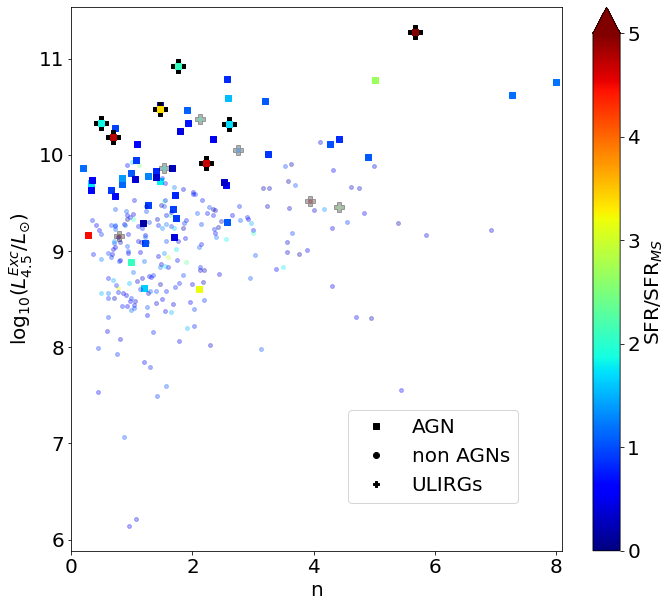

In [31]:
# smallagn=np.array([11054, 19267, 11519, 23844, 27302, 12353, 13017707, 13004291])
# agn strength morphology diagram
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0,vmax=5)
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
fields_list = ['goodsn','goodss','egs']
pixel_scale = 0.06
fig = plt.figure(figsize=(11,10))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0])
broadsources = {'goodsn':23844, 'goodss':12353, 'egs':-99}
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    all_catalog = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    all_catalog = all_catalog[np.isin(all_catalog['id'],id_ctg['id'])]
    all_catalog = all_catalog[all_catalog['id']!=broadsources[field]]
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    for num1 in range(0,all_catalog.size):
        idx = all_catalog[num1]['id']
        idx_candels = all_catalog[num1]['id_candels']
        z = all_catalog[num1]['z_used']
        sfr = all_catalog[num1]['sfr_huang']
        logsfr = np.log10(sfr)
        sed_class = all_catalog[num1]['tmp_class'][0]
        lx = all_catalog[num1]['lx']
        l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])
        e4p5ex = all_catalog[num1]['e4p5ex']/(all_catalog[num1]['l4p5ex']*np.log(10))
        mass = all_catalog[num1]['lmass_candels']
        re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z)
        if z>0.78 and z<=0.93:
            s0,m0,gama = [1.35,9.96,1.28]
        elif z>0.93 and z<=1.11:
            s0,m0,gama = [1.53,10.1,1.26]
        elif z>1.11 and z<=1.3:
            s0,m0,gama = [1.72,10.31,1.07]
        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
        if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
            n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
        else:
            n=all_catalog[num1]['n_f160w']
        if sed_class==1:
            symbol = 's'
            size = 40
            if idx in smallSBs[field]:
                ax.scatter(n,l4p5ex,marker='P',s=210,color='black')
            # ax.errorbar(n,l4p5ex,yerr=e4p5ex,alpha=0.3)
            ax.scatter(n,l4p5ex,marker=symbol,c=deltaMS,s=size,cmap='jet',vmin=0,vmax=5,alpha=1)
#             if idx in smallagn:
#                 ax.errorbar(np.log10(n),l4p5ex,xerr=dn/(n*np.log(10)))
#                 ax.scatter(np.log10(n),l4p5ex,marker='*',c=re,s=205,cmap='jet',vmin=0.1,vmax=10,alpha=alpha)
#             ax.text(np.log10(n),l4p5ex,idx)
#             print(idx,n)
        else:
            symbol = 'o'
            size = 15
            if idx in smallSBs[field]:
                ax.scatter(n,l4p5ex,marker='P',s=90,color='black',alpha=0.3)
            ax.scatter(n,l4p5ex,marker=symbol,c=deltaMS,s=size,cmap='jet',vmin=0,vmax=5,alpha=0.3)
#         if n>=4 and l4p5ex<9.5 and l4p5ex>0 and sed_class!=1:
#             ax.text(n,l4p5ex,str(np.around(lx,2)))
#             print(idx,deltaMS,re,lx,l4p5ex)
# ax.set_xlim(-0.8,1.1)
ax.set_xlim(0,8.1)
ax.set_xlabel('n',fontsize=20)
ax.set_ylabel('log$_{10}(L_{4.5}^{Exc}/L_{\odot})$',fontsize=20)
ax.tick_params(axis='both',labelsize=20)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max')#
cb.set_label(label='SFR/SFR$_{MS}$',fontsize=20)
cb.ax.tick_params(labelsize=20)
legend_elements=[Line2D([0],[0],lw=0,marker='s',color='black',label=r'AGN'),Line2D([0],[0],lw=0,marker='o',color='black',label='non AGNs'),Line2D([0],[0],lw=0,marker='P',color='black',label='ULIRGs')]
plt.legend(handles=legend_elements,fontsize=20,loc='lower right',bbox_to_anchor=[0.93,0.07])
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/l4p5ex_n_sfrcoded.pdf')
plt.savefig('/Users/lpr/Data/lirg_project/output/images/l4p5ex_n_ULIRGs_notype1qso.pdf')

# <b>Re vs. n</b>

<ipython-input-17-a4fe2188767c>:17: RuntimeWarning: divide by zero encountered in log10
  l4p5ex = np.log10(hdu[num]['l4p5ex'])


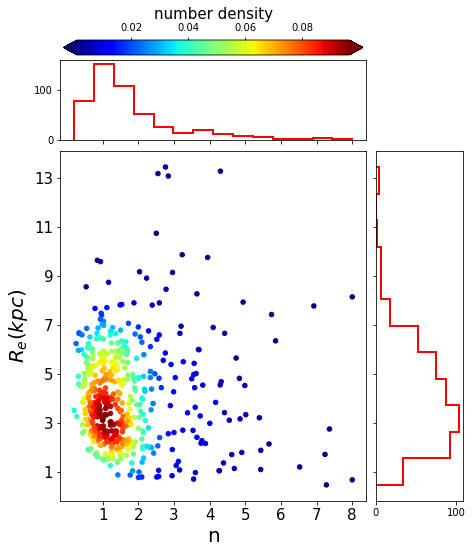

In [17]:
nresfr = []
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
fig = plt.figure(figsize=(7,8))
gs = fig.add_gridspec(2,2, width_ratios=(7,2),height_ratios=(2,7),left=0.1,right=0.9,bottom=0.1,top=0.9,wspace=0.05,hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu_re = fits.getdata(path+'output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        re = hdu_re[hdu_re['id']==idx]['re'][0]*kpc_per_arcsec(hdu[num]['z_used'])
        z = hdu[num]['z_used']
        lmass_candels = hdu[num]['lmass_candels']
        l4p5ex = np.log10(hdu[num]['l4p5ex'])
        if hdu_re[hdu_re['id']==idx]['n_f160w'] != -99.:
            n = hdu_re[hdu_re['id']==idx]['n_f160w'][0]
        else:
            n = hdu[num]['n_f160w']
        logsfr = np.log10(hdu[num]['sfr_huang'])
        if z>0.78 and z<=0.93:
            s0,m0,gama = [1.35,9.96,1.28]
        elif z>0.93 and z<=1.11:
            s0,m0,gama = [1.53,10.1,1.26]
        elif z>1.11 and z<=1.3:
            s0,m0,gama = [1.72,10.31,1.07]
        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**lmass_candels/10**m0)**(-1*gama))))
        nresfr.append([n,re,logsfr])
#         if n>6 and re<4:
#             print('n>6 and re<4kpc')
#             print(idx)
#             ax.text(n,re,str(idx))
#         if n>6 and re>6:
#             print('n>6 and re>6kpc')
#             print(idx)
#             ax.text(n,re,str(idx))

nresfr = np.array(nresfr)
xy = np.vstack([nresfr[:,0],nresfr[:,1]])
z = gaussian_kde(xy)(xy)
# im = ax.scatter(nresfr[:,0],nresfr[:,1],c=nresfr[:,2],vmin=0.6,vmax=2,cmap='jet')
im = ax.scatter(nresfr[:,0],nresfr[:,1],c=z,cmap='jet',s=20)
# legend_elements=[Line2D([0],[0],lw=2,color='g',label='CANDELS galaxies'),Line2D([0],[0],color='red',lw=0,marker='o',label=r'AGNs'),Line2D([0],[0],color='skyblue',lw=0,marker='o',label='whole sample'),Line2D([0],[0],color='black',lw=0,marker='s',markerfacecolor='none',label='X-ray AGNs')]
# ax.legend(handles=legend_elements,fontsize=15,loc='lower right')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.hist(nresfr[:,0],bins=14,linewidth=2,histtype='step',color='red')#weights=np.ones_like(np.log10(10**all_mass/all_re**1.5))/len(np.log10(10**all_mass/all_re**1.5)),range=[8,11.3]
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.hist(nresfr[:,1],bins=12,linewidth=2,histtype='step',color='red',orientation='horizontal')#weights=np.ones_like(np.log10((all_sfr/10**all_mass)*1e9))/len(np.log10((all_sfr/10**all_mass)*1e9)),range=[-2,2]
cb = fig.colorbar(im,location='top',ax=ax_histx,extend='both')
cb.set_label('number density',fontsize=15)#$SFR/SFR_{MS}$
cb.ax.tick_params(labelsize=10)
ax.set_xlabel('n',fontsize=20)
ax.set_ylabel('$R_e(kpc)$',fontsize=20)
ax.set_xticks(np.arange(1,9),np.arange(1,9),fontsize=15)
ax.set_yticks(np.arange(1,15,2),np.arange(1,15,2),fontsize=15)
plt.savefig('/Users/lpr/Data/lirg_project/output/images/re_n.pdf')

# <b>Mass comparison</b>

In [29]:
from scipy.optimize import curve_fit
def linear(x,k,b):
    return k * x + b
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
logmass = np.array([])
logmasserr = np.array([])
logl4p5sf = np.array([])
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu = hdu[hdu['l4p5'][:,0]>0]
    hdu = hdu[(hdu['TMP_CLASS'][:,0]==3) & (hdu['LIR_FULL']<=12.0)]
    logmass = np.concatenate((logmass, hdu['lmass_candels']) ,axis=0)
    logmasserr = np.concatenate((logmasserr, hdu['lmass_candelserr']) ,axis=0)
    l4p5ex = hdu['l4p5ex']
    l4p5 = 10**hdu['l4p5'][:,0]
    l4p5sf = np.log10(l4p5-l4p5ex)
    logl4p5sf = np.concatenate((logl4p5sf, l4p5sf), axis=0)

1.0231697966537743 0.39284626212090346 0.4035589974904203


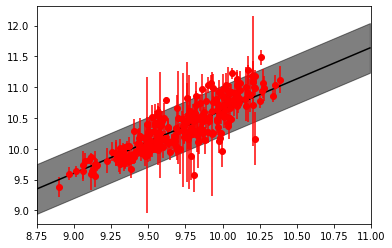

In [30]:
result = curve_fit(linear, logl4p5sf, logmass, sigma = logmasserr)
mc = dict()
mc['slope'] = result[0][0]
mc['intercept'] = result[0][1]
mc['intercept_sigma'] = np.sqrt(np.diag(result[1])[1])
xx = np.arange(8.75, 11, 0.01)
yy = mc['slope'] * xx + mc['intercept']
plt.errorbar(logl4p5sf, logmass, yerr=logmasserr, fmt='o', color='red')
plt.plot(xx, yy, color='black')
plt.fill_between(xx, yy-np.sqrt(np.diag(result[1])[1]), yy+np.sqrt(np.diag(result[1])[1]),color='black',alpha=0.5)
plt.xlim(8.75, 11.)
print(mc['slope'],mc['intercept'],mc['intercept_sigma'])

{'mu': 1.0649114064101655, 'sigma': 0.021274993679208466, 'amplitude': 1.4165956441752505, 'residual': array([ 0.99657851, -0.01108032, -0.03303842,  1.90929799, -0.22926871,
        0.46641568, -0.14338285, -1.25585222, -0.09788692,  0.14607026,
       -4.55479203,  0.03454012,  7.46286815,  2.51654992, -1.98922627,
        6.51773344,  0.15452471, -2.46198168, -0.06957406,  0.5001183 ,
       -0.42790197, -0.23194779,  2.00954217,  2.42622618,  1.23743423])}
{'mu': -0.007705736950922617, 'sigma': 0.20679671884575745, 'amplitude': 13.25141915505308, 'residual': array([ 0.99671056, -0.01079386,  0.96745168,  0.90980619, -0.22967902,
        0.4625199 , -0.15584576, -1.28419843, -0.14824326,  0.07705236,
       -4.61730569,  0.03647064,  6.62015932,  3.93450344, -0.22736313,
        7.64419796,  2.58040987, -0.87822819, -0.50502594,  2.88616957,
       -0.32068094,  0.56865425,  2.5350039 ,  0.73993403,  3.40807488])}


(8.75, 11.0)

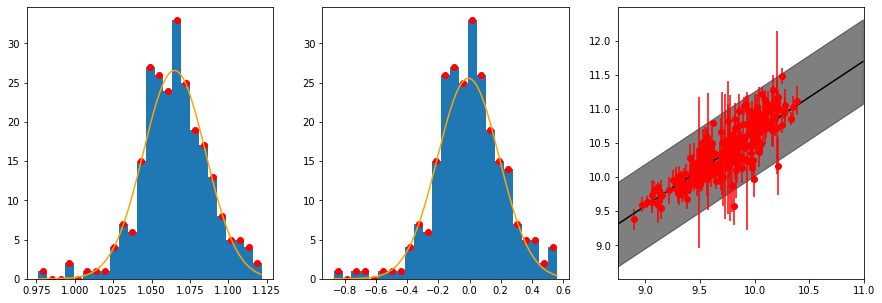

In [31]:
plt.figure(figsize=[15,5])
bins = 25
hist,edges = np.histogram(logmass/logl4p5sf, bins)
plt.subplot(131)
plt.hist(logmass/logl4p5sf, bins)
plt.scatter((edges[:-1]+edges[1:])/2, hist, color='red')
from lpr.other.math import distribution_fit, distribution
# # from lpr.other import math
result_slope = distribution_fit.fit_gaussian1D((edges[:-1]+edges[1:])/2, hist)
xx = np.arange(min(logmass/logl4p5sf),max(logmass/logl4p5sf),0.001)
yy = distribution.gaussian1D(xx, result_slope['mu'], result_slope['sigma'], result_slope['amplitude'])
plt.plot(xx, yy, color='orange')
print(result_slope)

bins = 25
hist,edges = np.histogram(logmass - result_slope['mu']*logl4p5sf, bins)
plt.subplot(132)
plt.hist(logmass - result_slope['mu']*logl4p5sf, bins)
plt.scatter((edges[:-1]+edges[1:])/2, hist, color='red')
from lpr.other.math import distribution_fit, distribution
# # from lpr.other import math
result_intercept = distribution_fit.fit_gaussian1D((edges[:-1]+edges[1:])/2, hist)
xx = np.arange(min(logmass - result_slope['mu']*logl4p5sf),max(logmass - result_slope['mu']*logl4p5sf),0.01)
yy = distribution.gaussian1D(xx, result_intercept['mu'], result_intercept['sigma'], result_intercept['amplitude'])
plt.plot(xx, yy, color='orange')
print(result_intercept)

xx = np.arange(8.75, 11, 0.01)
yy = result_slope['mu'] * xx + result_intercept['mu']
plt.subplot(133)
plt.errorbar(logl4p5sf, logmass, yerr=logmasserr, fmt='o', color='red')
plt.plot(xx, yy, color='black')
plt.fill_between(xx, yy-3*result_intercept['sigma'], yy+3*result_intercept['sigma'],color='black',alpha=0.5)
plt.xlim(8.75, 11.)

#### sigma clip on 'intercept'

0.41746847126696346 0.20126266159905898


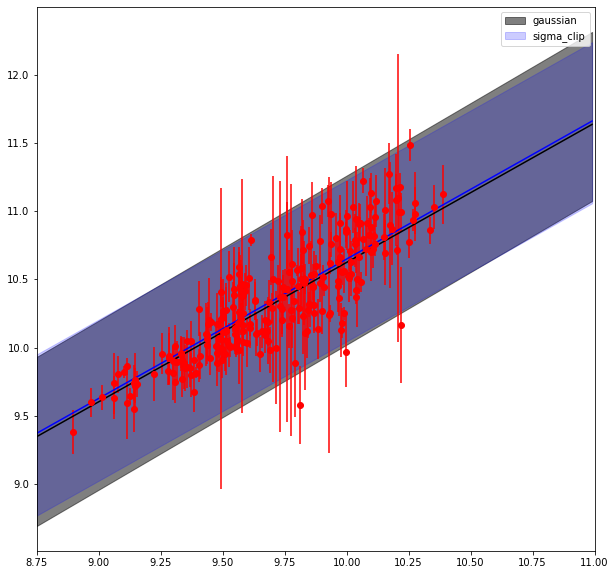

In [75]:
from scipy.stats import sigmaclip
import numpy as np
intercept_clipped, low, upp = sigmaclip(logmass - mc['slope']*logl4p5sf, 3, 3)
print(intercept_clipped.mean(), intercept_clipped.std())
xx = np.arange(8.75, 11, 0.01)
yy = mc['slope'] * xx + mc['intercept']
yy1 = mc['slope']*xx + intercept_clipped.mean()
plt.figure(figsize=[10,10])

# plt.errorbar(np.log10((10**logl4p5sf *3.846 * 10**33).astype(float)), logmass, yerr=logmasserr, fmt='o', color='red')
# yy2 = result_slope['mu'] * xx + result_intercept['mu']
# plt.plot(np.log10((10**xx * 3.846 * 10**33).astype(float)), yy, color='black')
# plt.fill_between(np.log10((10**xx * 3.846 * 10**33).astype(float)), yy2-3*result_intercept['sigma'], yy2+3*result_intercept['sigma'],color='black',alpha=0.5)
# # plt.xlim(8.75, 11.)

# # plt.plot(xx, yy, color='black',label='lingress')
# # plt.fill_between(xx, yy-np.sqrt(np.diag(result[1])[1]), yy+np.sqrt(np.diag(result[1])[1]),color='black',alpha=0.2)
# plt.plot(np.log10((10**xx * 3.846 * 10**33).astype(float)), yy1, color='blue',label='sigmaclip')
# plt.fill_between(np.log10((10**xx * 3.846 * 10**33).astype(float)), yy1-3*intercept_clipped.std(), yy+3*intercept_clipped.std(),color='blue',alpha=0.2)
# # plt.xlim(8.75, 11.)
# plt.xlim(41,45)
# plt.ylim(8,12)
# plt.plot(np.log10((10**xx * 3.846 * 10**33).astype(float)), 0.906*np.log10((10**xx * 3.846 * 10**33).astype(float))-29.225,color='orange')

plt.errorbar(logl4p5sf, logmass, yerr=logmasserr, fmt='o', color='red')
yy2 = result_slope['mu'] * xx + result_intercept['mu']
plt.plot(xx, yy, color='black')
plt.fill_between(xx, yy2-3*result_intercept['sigma'], yy2+3*result_intercept['sigma'],color='black',alpha=0.5,label='gaussian')

# plt.plot(xx, yy, color='black',label='lingress')
# plt.fill_between(xx, yy-np.sqrt(np.diag(result[1])[1]), yy+np.sqrt(np.diag(result[1])[1]),color='black',alpha=0.2)
plt.plot(xx, yy1, color='blue')
plt.fill_between(xx, yy1-3*intercept_clipped.std(), yy+3*intercept_clipped.std(),color='blue',alpha=0.2,label='sigma_clip')
plt.xlim(8.75, 11.)
plt.legend()

#### save mass correction to fits file

In [10]:
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu = hdu[hdu['l4p5'][:,0]>0]
    mc['slope']*xx + intercept_clipped.mean()
    hdu = hdu[(hdu['lmass_candels'] - (mc['slope'] * np.log10(10**hdu['l4p5'][:,0] - hdu['l4p5ex']) + intercept_clipped.mean() + 3*intercept_clipped.std()) > 0) | (hdu['lmass_candels'] - (mc['slope'] * np.log10(10**hdu['l4p5'][:,0] - hdu['l4p5ex']) + intercept_clipped.mean() - 3*intercept_clipped.std()) < 0)]
    newmass = mc['slope'] * np.log10(10**hdu['l4p5'][:,0] - hdu['l4p5ex']) + intercept_clipped.mean()
    c1 = fits.Column(name='id', array=hdu['id'], format='K')
    c2 = fits.Column(name='lmass_candels', array=hdu['lmass_candels'], format='D')
    c3 = fits.Column(name='lmass_corr', array=newmass, format='D')
    fits.BinTableHDU.from_columns([c1, c2, c3]).writeto(path+'output/catalog_radec/'+field+'_mass_corr.fits',overwrite=True)

[11054 10135  9988 19267 18654 11519 11393 12028 38311 21468 23844 34515]
[2652]
[]


([<matplotlib.axis.YTick at 0x7fa4c24b6610>,
 [Text(0, 9.5, '9.5'),
  Text(0, 10.0, '10'),
  Text(0, 10.5, '10.5'),
  Text(0, 11.0, '11'),
  Text(0, 11.5, '11.5')])

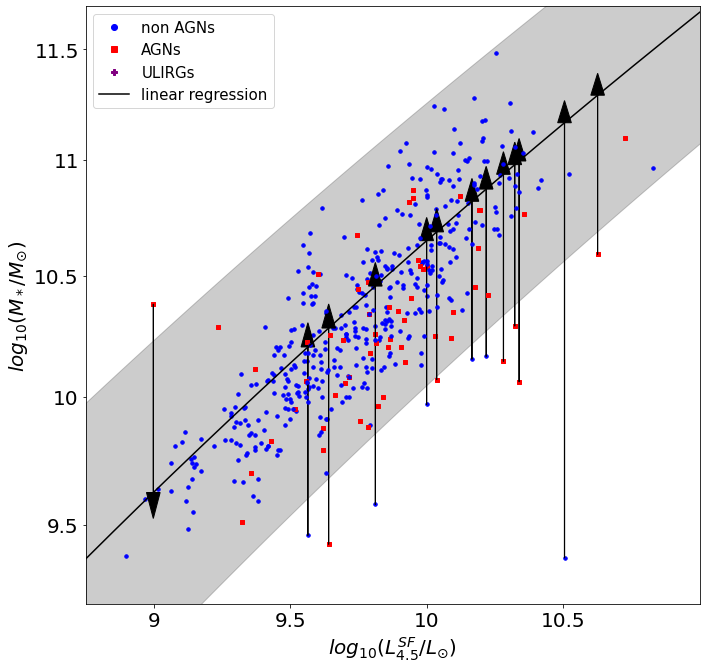

In [25]:
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
fig = plt.figure(figsize=(11,11))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
xx = np.arange(8.75, 11.1, 0.01)
yy1 = mc['slope']*xx + intercept_clipped.mean()
ax.plot(xx, yy1, color='black')
ax.fill_between(xx, yy1-3*intercept_clipped.std(), yy1+3*intercept_clipped.std(),color='black',alpha=0.2)
# ax.fill_between(xx, yy1-3*mc['intercept_sigma'], yy1+3*mc['intercept_sigma'],color='blue',alpha=0.2)
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu = hdu[hdu['l4p5'][:,0]>0]
    masscorr_ctg = fits.getdata(path+'output/catalog_radec/' + field + '_mass_corr.fits',1)
    print(masscorr_ctg['id'])
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        # lmass_candels = hdu[num]['lmass_candels']
        mass, mass_new, re, re_new = [0, 0, 0, 0]
        mass = hdu[num]['lmass_candels']
        if idx in masscorr_ctg['id']: mass_new = masscorr_ctg[masscorr_ctg['id']==idx]['lmass_corr'][0]
        l4p5ex = hdu[num]['l4p5ex']
        l4p5 = 10**hdu[num]['l4p5'][0]
        l4p5sf = np.log10(l4p5-l4p5ex)
        lx = hdu[num]['lx']
        tmp_class = hdu[num]['tmp_class'][0]
        # if idx in smallSBs[field]:
        #     symbol = 'P'
        #     color='purple'
        #     size = 100
        #     ax.scatter(l4p5sf,mass,c=color,marker=symbol,s=size)
        if tmp_class==1:
            symbol='s'
            color='red'
            size = 12
            label = 'AGNs'
        else:
            symbol='o'
            color='blue'
            size = 12
            label = 'non AGNs'
        ax.scatter(l4p5sf,mass,c=color,marker=symbol,s=size)
        if idx in masscorr_ctg['id']:
            ax.arrow(l4p5sf,mass, dx=0, dy=mass_new-mass,width=0.001,color='black',head_width=0.05,head_length=0.1)

legend_elements=[Line2D([0],[0],color='blue',lw=0,marker='o',label='non AGNs'),Line2D([0],[0],color='red',lw=0,marker='s',label='AGNs'),Line2D([0],[0],color='purple',lw=0,marker='P',label='ULIRGs'),Line2D([0],[0],color='black',ls='-',label='linear regression')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.xlim(8.75,11)
plt.ylim(9.2,11.7)
plt.yscale('log')
plt.xlabel('$log_{10}(L_{4.5}^{SF}/L_{\odot})$',fontsize=20)
plt.ylabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
plt.xticks([9, 9.5, 10, 10.5], [9, 9.5, 10, 10.5], fontsize=20)
plt.yticks([9.5,10,10.5,11,11.5],[9.5,10,10.5,11,11.5],fontsize=20)
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/mass_correction.pdf')

#### 定量估计outlier的质量错误估计了%多少

In [12]:
from astropy.io import fits
import numpy as np
path = '/Users/lpr/Data/lirg_project/'
difference = []
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu = hdu[hdu['l4p5'][:,0]>0]
    masscorr_ctg = fits.getdata(path+'output/catalog_radec/' + field + '_mass_corr.fits',1)
    for idx in masscorr_ctg['id']:
        mass_new = masscorr_ctg[masscorr_ctg['id']==idx]['lmass_corr'][0]
        mass_old = hdu[hdu['id']==idx]['lmass_candels'][0]
        difference.append(abs(mass_new-mass_old))
print(difference)
print(np.median(np.array(difference)))

[0.6897039413452148, 0.6657400131225586, 0.7568750381469727, 1.7920856475830078, 0.9336957931518555, 0.6998271942138672, 0.74468994140625, 0.7073249816894531, 0.8560628890991211, 0.6165122985839844, 0.7920494079589844, 0.8788881301879883, 0.6785659790039062]
0.74468994140625


## 用自己算出来的rest-frame的1.6um的光度和质量的关系

In [13]:
from scipy.optimize import curve_fit
def linear(x,k,b):
    return k * x + b
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
logmass = np.array([])
logmasserr = np.array([])
logl1p6 = np.array([])
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu = hdu[(hdu['TMP_CLASS'][:,0]==3) & (hdu['LIR_FULL']<=12.0)]
    lh_ctg = fits.open(path+'output/mass_corr/'+field+'_LH.fits')[1].data
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        m = hdu[num]['lmass_candels']
        merr = hdu[num]['lmass_candelserr']
        lh = lh_ctg[lh_ctg['id']==idx]['LH'][0]
        logmass = np.append(logmass, m)
        logmasserr = np.append(logmasserr, merr)
        logl1p6 = np.append(logl1p6, lh)

1.135953828042106 -38.93521266401913 1.166351821963481


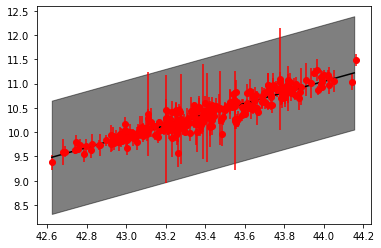

In [19]:
result_h = curve_fit(linear, np.log10(logl1p6), logmass, sigma = logmasserr)
mc_h = dict()
mc_h['slope'] = result_h[0][0]
mc_h['intercept'] = result_h[0][1]
mc_h['intercept_sigma'] = np.sqrt(np.diag(result_h[1])[1])
xx = np.arange(np.amin(np.log10(logl1p6)), np.amax(np.log10(logl1p6)), 0.01)
yy = mc_h['slope'] * xx + mc_h['intercept']
plt.errorbar(np.log10(logl1p6), logmass, yerr=logmasserr, fmt='o', color='red')
plt.plot(xx, yy, color='black')
plt.fill_between(xx, yy-np.sqrt(np.diag(result_h[1])[1]), yy+np.sqrt(np.diag(result_h[1])[1]),color='black',alpha=0.5)
print(mc_h['slope'],mc_h['intercept'],mc_h['intercept_sigma'])

{'mu': -38.92359418829593, 'sigma': 0.12466934165365061, 'amplitude': 8.67366756084547, 'residual': array([ 9.99972555e-01, -1.46858245e-04, -7.05104948e-04,  9.96962443e-01,
       -1.17411444e-02, -4.07203656e-02,  8.73284956e-01,  6.46198264e-01,
        5.11364641e+00,  4.00763304e+00,  1.98165777e+00, -2.71764137e-01,
       -1.80722709e+00,  7.79830199e+00,  5.14114645e-01, -1.37326725e+00,
        7.24551651e+00, -2.07019631e-01,  7.96707061e-01,  1.21555730e-01,
       -2.51231621e+00, -2.04544252e+00,  1.11312638e+01,  9.39020282e-02,
        1.15737062e+00])}


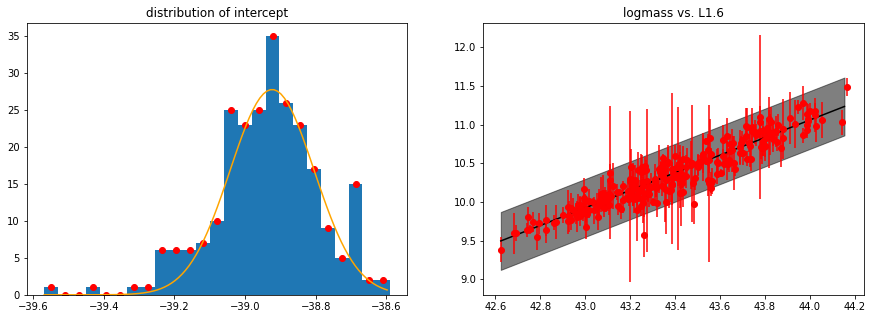

In [30]:
plt.figure(figsize=[15,5])

bins = 25
hist,edges = np.histogram(logmass - mc_h['slope']*np.log10(logl1p6), bins)
plt.subplot(121)
plt.title('distribution of intercept')
plt.hist(logmass - mc_h['slope']*np.log10(logl1p6), bins)
plt.scatter((edges[:-1]+edges[1:])/2, hist, color='red')
from lpr.other.math import distribution_fit, distribution
# # from lpr.other import math
result_intercept = distribution_fit.fit_gaussian1D((edges[:-1]+edges[1:])/2, hist)
xx = np.arange(min(logmass - mc_h['slope']*np.log10(logl1p6)),max(logmass - mc_h['slope']*np.log10(logl1p6)),0.01)
yy = distribution.gaussian1D(xx, result_intercept['mu'], result_intercept['sigma'], result_intercept['amplitude'])
plt.plot(xx, yy, color='orange')
print(result_intercept)

xx = np.arange(np.amin(np.log10(logl1p6)), np.amax(np.log10(logl1p6)), 0.01)
yy = mc_h['slope'] * xx + result_intercept['mu']
plt.subplot(122)
plt.title('logmass vs. L1.6')
plt.errorbar(np.log10(logl1p6), logmass, yerr=logmasserr, fmt='o', color='red')
plt.plot(xx, yy, color='black')
plt.fill_between(xx, yy-3*result_intercept['sigma'], yy+3*result_intercept['sigma'],color='black',alpha=0.5)
# plt.xlim(8.75, 11.)

-38.93233148411373 0.13781770185466066


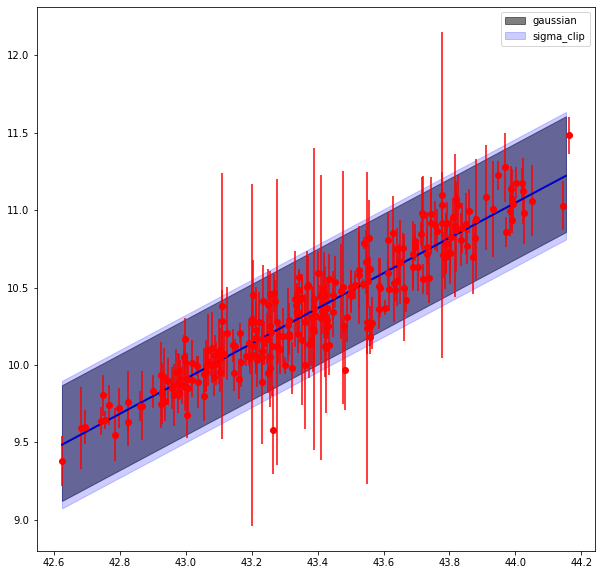

In [38]:
from scipy.stats import sigmaclip
import numpy as np
intercept_clipped, low, upp = sigmaclip(logmass - mc_h['slope']*np.log10(logl1p6), 3, 3)
print(intercept_clipped.mean(), intercept_clipped.std())
xx = np.arange(np.amin(np.log10(logl1p6)), np.amax(np.log10(logl1p6)), 0.01)
yy = mc_h['slope'] * xx + mc_h['intercept']
yy1 = mc_h['slope']*xx + intercept_clipped.mean()
plt.figure(figsize=[10,10])

plt.errorbar(np.log10(logl1p6), logmass, yerr=logmasserr, fmt='o', color='red')
yy2 = mc_h['slope'] * xx + result_intercept['mu']
plt.plot(xx, yy, color='black')
plt.fill_between(xx, yy2-3*result_intercept['sigma'], yy2+3*result_intercept['sigma'],color='black',alpha=0.5,label='gaussian')

plt.plot(xx, yy1, color='blue')
plt.fill_between(xx, yy1-3*intercept_clipped.std(), yy+3*intercept_clipped.std(),color='blue',alpha=0.2,label='sigma_clip')
plt.legend()

In [66]:
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}

for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    idx_list = np.array([])
    mass = np.array([])
    mass_corr = np.array([])
    lh_ctg = fits.open(path+'output/mass_corr/'+field+'_LH.fits')[1].data
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        m = hdu[num]['lmass_candels']
        lh = lh_ctg[lh_ctg['id']==idx]['LH'][0]
        if m - (mc_h['slope'] * np.log10(lh) + intercept_clipped.mean() + 3*intercept_clipped.std()) > 0 or m - (mc_h['slope'] * np.log10(lh) + intercept_clipped.mean() - 3*intercept_clipped.std()) < 0:
            idx_list = np.append(idx_list, idx)
            mass = np.append(mass, m)
            newmass = mc_h['slope'] * np.log10(lh) + intercept_clipped.mean()
            mass_corr = np.append(mass_corr, newmass)
    c1 = fits.Column(name='id', array=idx_list, format='K')
    c2 = fits.Column(name='lmass_candels', array=mass, format='D')
    c3 = fits.Column(name='lmass_corr', array=mass_corr, format='D')
    fits.BinTableHDU.from_columns([c1, c2, c3]).writeto(path+'output/mass_corr/'+field+'_mass_corr_L1P6.fits',overwrite=True)

[11054 10135  9988 19267 18654 11519 11393 12028 38311 21468 23844 34515]
[11054 10135 19267 18654 11519 12288 23844 27302 34515 23623]
[2652]
[ 2652  3452 12353]
[]
[13033068 13011748]


([<matplotlib.axis.YTick at 0x7f97d3008fa0>,
 [Text(0, 9.5, '9.5'),
  Text(0, 10.0, '10'),
  Text(0, 10.5, '10.5'),
  Text(0, 11.0, '11'),
  Text(0, 11.5, '11.5')])

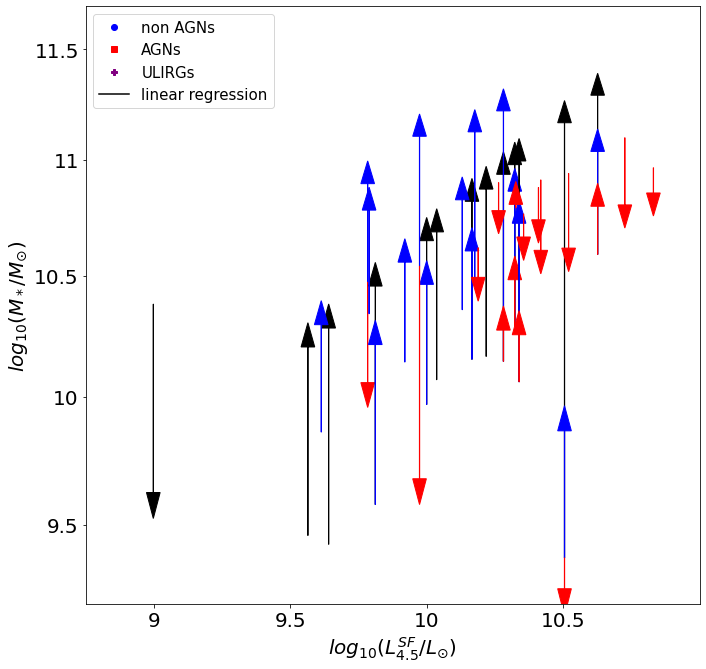

In [73]:
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
ulirg = {'goodsn': np.array([15995, 11054, 19267,  6228, 18654, 11519, 22407, 23844, 27302]),
 'goodss': np.array([5811, 12353]),
 'egs': np.array([13003805, 13017707, 13026117, 13004291, 13034619])}
fig = plt.figure(figsize=(11,11))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])

for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu = hdu[hdu['l4p5'][:,0]>0]
    masscorr_ctg = fits.getdata(path+'output/catalog_radec/' + field + '_mass_corr.fits',1)
    masscorrl1p6_ctg = fits.getdata(path+'output/mass_corr/' + field + '_mass_corr_L1P6.fits',1)
    print(masscorr_ctg['id'])
    print(masscorrl1p6_ctg['id'])
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        mass, mass_new, massl1p6_new, mass_cigale = [0, 0, 0, 0]
        mass = hdu[num]['lmass_candels']
        if idx in masscorr_ctg['id']: mass_new = masscorr_ctg[masscorr_ctg['id']==idx]['lmass_corr'][0]
        if idx in masscorrl1p6_ctg['id']: massl1p6_new = masscorrl1p6_ctg[masscorrl1p6_ctg['id']==idx]['lmass_corr'][0]
        if idx in ulirg[field]: mass_cigale = np.log10(fits.open('/Users/lpr/Data/lirg_project/output/cigale/ulirgs/'+field+'_'+str(idx)+'_results.fits')[1].data['bayes.stellar.m_star'][0])
        l4p5ex = hdu[num]['l4p5ex']
        l4p5 = 10**hdu[num]['l4p5'][0]
        l4p5sf = np.log10(l4p5-l4p5ex)
        tmp_class = hdu[num]['tmp_class'][0]
        if tmp_class==1:
            symbol='s'
            color='red'
            size = 12
            label = 'AGNs'
        else:
            symbol='o'
            color='blue'
            size = 12
            label = 'non AGNs'
        # ax.scatter(l4p5sf,mass,c=color,marker=symbol,s=size)
        if idx in masscorr_ctg['id']:
            ax.arrow(l4p5sf,mass, dx=0, dy=mass_new-mass,width=0.001,color='black',head_width=0.05,head_length=0.1)
        if idx in masscorrl1p6_ctg['id']:
            ax.arrow(l4p5sf,mass, dx=0, dy=massl1p6_new-mass,width=0.001,color='blue',head_width=0.05,head_length=0.1)
        if idx in ulirg[field]:
            ax.arrow(l4p5sf,mass, dx=0, dy=mass_cigale-mass,width=0.001,color='red',head_width=0.05,head_length=0.1)

legend_elements=[Line2D([0],[0],color='blue',lw=0,marker='o',label='non AGNs'),Line2D([0],[0],color='red',lw=0,marker='s',label='AGNs'),Line2D([0],[0],color='purple',lw=0,marker='P',label='ULIRGs'),Line2D([0],[0],color='black',ls='-',label='linear regression')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.xlim(8.75,11)
plt.ylim(9.2,11.7)
plt.yscale('log')
plt.xlabel('$log_{10}(L_{4.5}^{SF}/L_{\odot})$',fontsize=20)
plt.ylabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
plt.xticks([9, 9.5, 10, 10.5], [9, 9.5, 10, 10.5], fontsize=20)
plt.yticks([9.5,10,10.5,11,11.5],[9.5,10,10.5,11,11.5],fontsize=20)
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/mass_correction.pdf')

## CIGALE结果

[11054 10135  9988 19267 18654 11519 11393 12028 38311 21468 23844 34515]
[11054 10135 19267 18654 11519 12288 23844 27302 34515 23623]
[2652]
[ 2652  3452 12353]
[]
[13033068 13011748]


([<matplotlib.axis.YTick at 0x7f97aab304c0>,
 [Text(0, 9.5, '9.5'),
  Text(0, 10.0, '10'),
  Text(0, 10.5, '10.5'),
  Text(0, 11.0, '11'),
  Text(0, 11.5, '11.5')])

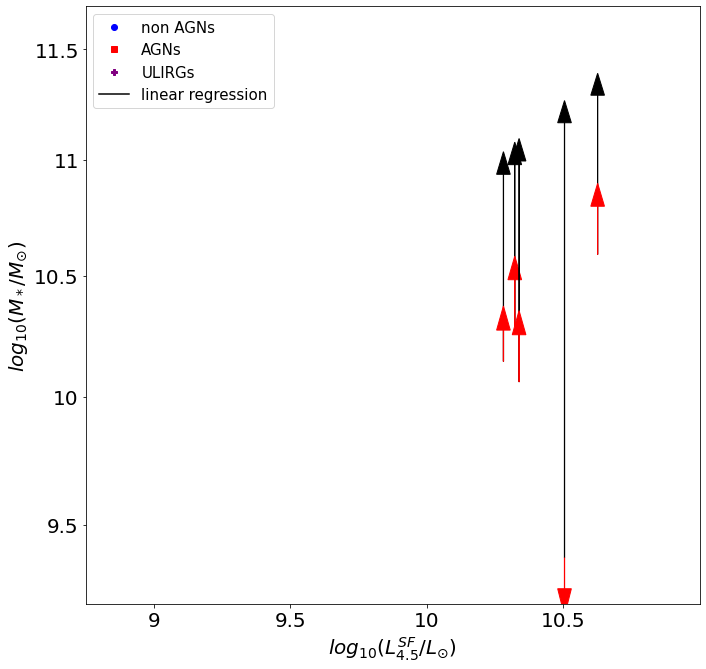

In [75]:
fields = ['goodsn','goodss','egs']
candels_names = {'goodsn':'gdn','goodss':'gds','egs':'egs'}
ulirg = {'goodsn': np.array([15995, 11054, 19267,  6228, 18654, 11519, 22407, 23844, 27302]),
 'goodss': np.array([5811, 12353]),
 'egs': np.array([13003805, 13017707, 13026117, 13004291, 13034619])}
fig = plt.figure(figsize=(11,11))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])

for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    hdu = hdu[hdu['l4p5'][:,0]>0]
    masscorr_ctg = fits.getdata(path+'output/catalog_radec/' + field + '_mass_corr.fits',1)
    masscorrl1p6_ctg = fits.getdata(path+'output/mass_corr/' + field + '_mass_corr_L1P6.fits',1)
    print(masscorr_ctg['id'])
    print(masscorrl1p6_ctg['id'])
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        mass, mass_new, massl1p6_new, mass_cigale = [0, 0, 0, 0]
        mass = hdu[num]['lmass_candels']
        if idx in masscorr_ctg['id']: mass_new = masscorr_ctg[masscorr_ctg['id']==idx]['lmass_corr'][0]
        if idx in masscorrl1p6_ctg['id']: massl1p6_new = masscorrl1p6_ctg[masscorrl1p6_ctg['id']==idx]['lmass_corr'][0]
        if idx in ulirg[field]: mass_cigale = np.log10(fits.open('/Users/lpr/Data/lirg_project/output/cigale/ulirgs/'+field+'_'+str(idx)+'_results.fits')[1].data['bayes.stellar.m_star'][0])
        l4p5ex = hdu[num]['l4p5ex']
        l4p5 = 10**hdu[num]['l4p5'][0]
        l4p5sf = np.log10(l4p5-l4p5ex)
        tmp_class = hdu[num]['tmp_class'][0]
        if tmp_class==1:
            symbol='s'
            color='red'
            size = 12
            label = 'AGNs'
        else:
            symbol='o'
            color='blue'
            size = 12
            label = 'non AGNs'
        # ax.scatter(l4p5sf,mass,c=color,marker=symbol,s=size)
        if idx in masscorr_ctg['id'] and idx in ulirg[field]:
            ax.arrow(l4p5sf,mass, dx=0, dy=mass_new-mass,width=0.001,color='black',head_width=0.05,head_length=0.1)
            ax.arrow(l4p5sf,mass, dx=0, dy=mass_cigale-mass,width=0.001,color='red',head_width=0.05,head_length=0.1)
        # if idx in masscorrl1p6_ctg['id']:
        #     ax.arrow(l4p5sf,mass, dx=0, dy=massl1p6_new-mass,width=0.001,color='blue',head_width=0.05,head_length=0.1)
        # if idx in ulirg[field]:
        #     ax.arrow(l4p5sf,mass, dx=0, dy=mass_cigale-mass,width=0.001,color='red',head_width=0.05,head_length=0.1)

legend_elements=[Line2D([0],[0],color='blue',lw=0,marker='o',label='non AGNs'),Line2D([0],[0],color='red',lw=0,marker='s',label='AGNs'),Line2D([0],[0],color='purple',lw=0,marker='P',label='ULIRGs'),Line2D([0],[0],color='black',ls='-',label='linear regression')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.xlim(8.75,11)
plt.ylim(9.2,11.7)
plt.yscale('log')
plt.xlabel('$log_{10}(L_{4.5}^{SF}/L_{\odot})$',fontsize=20)
plt.ylabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
plt.xticks([9, 9.5, 10, 10.5], [9, 9.5, 10, 10.5], fontsize=20)
plt.yticks([9.5,10,10.5,11,11.5],[9.5,10,10.5,11,11.5],fontsize=20)
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/mass_correction.pdf')

# <b> Gini-M_20 diagram </b>

In [4]:
from lpr.image.display import logstretch
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

In [3]:
fields = ['goodsn','goodss','egs']
deltax = 0.1
deltay = 0.02
plotxrange = [0.13,0.85]
plotyrange = [0.13,0.83]
ylim = [0.35,0.75] #gini
xlim = [-2.3,-0.4] #m20
nginim20_list = np.empty([0,3],dtype=np.float16)
idxpair_list = np.empty([0,2],dtype=np.int16)
field_list = np.empty([0,1],dtype='U6')
for field in fields:
    ginim20_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_GiniM20_10arcseccutout.fits',1)
    h_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_Huangall_candels_van_params.fits',1)
    id_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_id.fits',1)
    pair_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_pair_1000kms.fits',1)
    h_ctg = h_ctg[np.isin(h_ctg['id'],id_ctg['id'])]
    h_ctg = h_ctg[h_ctg['id']!=32411]
    re_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    for num in range(len(h_ctg)):
        idx = h_ctg[num]['id']
        if re_ctg[re_ctg['id']==idx]['n_f160w'][0] != -99.:
            n = re_ctg[re_ctg['id']==idx]['n_f160w'][0]
        else:
            n = h_ctg[num]['n_f160w']
        pair_flag = {True:1,False:0}[pair_ctg[pair_ctg['id']==idx]['count_spec'][0]>0]
        gini,m20 = ginim20_ctg[ginim20_ctg['id']==idx]['Gini_coeff_statmorph'][0],ginim20_ctg[ginim20_ctg['id']==idx]['Moment_20_statmorph'][0]
        nginim20_list= np.append(nginim20_list,np.array([[n,gini,m20]]),axis=0)
        field_list= np.append(field_list,np.array([[field]]))
        idxpair_list = np.append(idxpair_list,np.array([[idx,pair_flag]]),axis=0)

In [8]:
aaa = nginim20_list[nginim20_list[:,1]>-0.14*nginim20_list[:,2]+0.33]
print(aaa.size)
bbb = aaa[aaa[:,0]>2]
print(bbb.size)
print(bbb.size/aaa.size)

258
87
0.3372093023255814


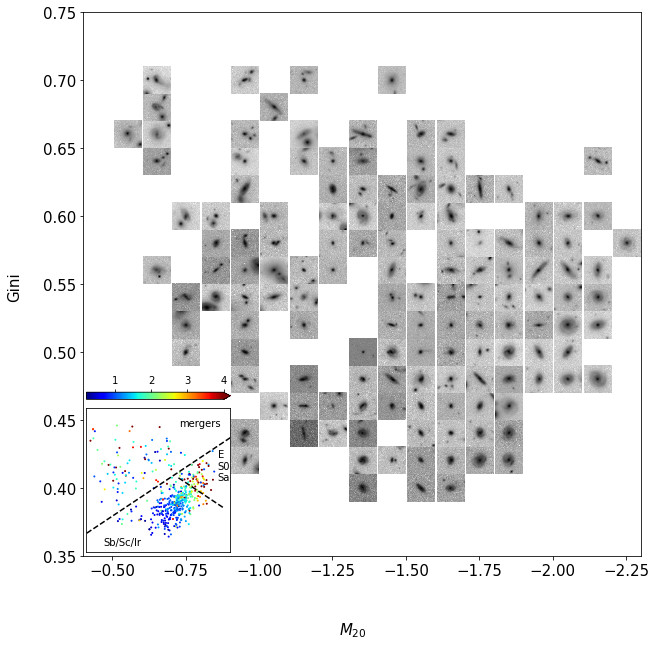

In [18]:
import matplotlib as mpl
fig = plt.figure(figsize=[10,10])
fig.supxlabel('$M_{20}$',fontsize=15)
fig.supylabel('Gini',fontsize=15)
ax = plt.subplot(111)
ax.set_ylim(ylim[0],ylim[1])
ax.set_xlim(xlim[1],xlim[0])
ax.tick_params(axis='both',labelsize=15)
for x in np.arange(xlim[0],xlim[1],deltax):
    for y in np.arange(ylim[0],ylim[1],deltay):
        subnginim20_list = nginim20_list[(nginim20_list[:,1]>y)&(nginim20_list[:,1]<y+deltay)&(nginim20_list[:,2]>x)&(nginim20_list[:,2]<x+deltax)]
        subfield_list = field_list[(nginim20_list[:,1]>y)&(nginim20_list[:,1]<y+deltay)&(nginim20_list[:,2]>x)&(nginim20_list[:,2]<x+deltax)]
        subidxpair_list = idxpair_list[(nginim20_list[:,1]>y)&(nginim20_list[:,1]<y+deltay)&(nginim20_list[:,2]>x)&(nginim20_list[:,2]<x+deltax)]
        if subnginim20_list.size != 0:
            if subidxpair_list[subidxpair_list[:,1]==1].size != 0: #如果有pair，那么这个grid就用这个pair的stamp image
                idx_nmedian = subidxpair_list[subidxpair_list[:,1]==1][0,0]
                field_idx_nmedian = subfield_list[subidxpair_list[:,1]==1][0]
                image = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field_idx_nmedian+'/'+field_idx_nmedian+'_f160w/'+field_idx_nmedian+'_f160w_'+str(idx_nmedian)+'.fits',0)
                plotImage(x,y,logstretch(image,a=300),ax)
            else:
                idx_nmedian = subidxpair_list[np.argmin(abs(subnginim20_list[:,0]-np.median(subnginim20_list[:,0])))][0]
                field_idx_nmedian = subfield_list[np.argmin(abs(subnginim20_list[:,0]-np.median(subnginim20_list[:,0])))]
                image = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field_idx_nmedian+'/'+field_idx_nmedian+'_f160w/'+field_idx_nmedian+'_f160w_'+str(idx_nmedian)+'.fits',0)
                plotImage(x,y,logstretch(image,a=300),ax)
xrange = np.arange(-2.42,-0.2,0.1)
y1 = -0.14*xrange+0.33
y2 = 0.14*xrange+0.8
inset_ax = fig.add_axes([.13, .13, .2, .25])
inset_ax.set(xticks=[], yticks=[])
inset_ax.text(-1.75,0.7,'mergers',fontsize=10)
inset_ax.text(-0.75,0.37,'Sb/Sc/Ir',fontsize=10)
inset_ax.text(-2.25,0.55,'E\n'+'S0\n'+'Sa',fontsize=10)
inset_ax.set_ylim(ylim[0],ylim[1])
inset_ax.set_xlim(xlim[1]-0.12,xlim[0]-0.12)
inset_ax.plot(xrange[(xrange<=-47./28.)&(xrange>-2.42)],y2[(xrange<=-47./28.)&(xrange>-2.42)],'--k')
inset_ax.plot(xrange,y1,'--k')
inset_ax.scatter(nginim20_list[:,2],nginim20_list[:,1],c=nginim20_list[:,0],vmin=0.2,vmax=4,marker='o',cmap='jet',s=1)
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0.2,vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),ax=inset_ax,extend='max',location='top')
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/gini_m20_l4p5ex.png')
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/gini_m20_stamp_ncoded.pdf')

In [6]:
fields = ['goodsn','goodss','egs']
deltax = 0.1
deltay = 0.02
plotxrange = [0.13,0.85]
plotyrange = [0.13,0.83]
ylim = [0.35,0.75] #gini
xlim = [-2.3,-0.4] #m20
count_merger = 0
count_sp = 0
count_e = 0
count_pair_merger = 0
for field in fields:
    ginim20_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_GiniM20_10arcseccutout.fits',1)
    h_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_Huangall_candels_van_params.fits',1)
    id_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_id.fits',1)
    pair_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_pair_1000kms.fits',1)
    h_ctg = h_ctg[np.isin(h_ctg['id'],id_ctg['id'])]
    h_ctg = h_ctg[h_ctg['id']!=32411]
    for num in range(len(h_ctg)):
        idx = h_ctg[num]['id']
        pair_flag = {True:1,False:0}[pair_ctg[pair_ctg['id']==idx]['count_spec'][0]>0]
        gini,m20 = ginim20_ctg[ginim20_ctg['id']==idx]['Gini_coeff_statmorph'][0],ginim20_ctg[ginim20_ctg['id']==idx]['Moment_20_statmorph'][0]
        if gini>-0.14*m20+0.33:
            count_merger += 1
        elif gini<=-0.14*m20+0.33 and gini>0.14*m20+0.8:
            count_e += 1
        elif gini<=-0.14*m20+0.33 and gini<=0.14*m20+0.8:
            count_sp += 1

        # if gini>-0.14*m20+0.33 and pair_flag==1:
        #     count_pair_merger += 1
        # elif gini<=-0.14*m20+0.33 and gini>0.14*m20+0.8 and pair_flag==1:
        #     count_e += 1
        # elif gini<=-0.14*m20+0.33 and gini<=0.14*m20+0.8 and pair_flag==1:
        #     count_sp += 1
# print(count_merger/(count_merger+count_e+count_sp),count_e/(count_merger+count_e+count_sp),count_sp/(count_merger+count_e+count_sp))
print(count_merger,count_e,count_sp)
# xrange = np.arange(-2.25,-0.2)
# y1 = -0.14*xrange+0.33
# y2 = 0.14*xrange+0.8

# plt.figure(figsize=[10,10])
# plt.plot(xrange,y1)
# plt.plot(xrange,y2)
# plt.xlabel('$M_{20}$',fontsize=15)
# plt.ylabel('Gini',fontsize=15)
# # plt.ylim(ylim[0],ylim[1])
# plt.xlim(xlim[1],xlim[0])
# plt.tick_params(axis='both',labelsize=15)
# # plt.scatter(nginim20_list[:,2],nginim20_list[:,1],c=nginim20_list[:,0],vmin=0.2,vmax=4,marker='o',cmap='jet')
# plt.scatter(nginim20_list[np.isin(idxpair_list[:,0],smallSBs)][:,2],nginim20_list[np.isin(idxpair_list[:,0],smallSBs)][:,1],c=nginim20_list[np.isin(idxpair_list[:,0],smallSBs)][:,0],vmin=0.2,vmax=4,marker='*',cmap='jet',s=200)
# for num in smallSBs:
#     gini,m20 = nginim20_list[:,1][idxpair_list[:,0]==num],nginim20_list[:,2][idxpair_list[:,0]==num]
#     plt.text(m20,gini,str(num))
# cb = plt.colorbar(extend='max')
# cb.set_label('n',fontsize=15)
# cb.ax.tick_params(labelsize=15)
# # plt.savefig('/Users/lpr/Data/lirg_project/output/images/gini_m20_ncoded_SBs.png')

86 64 328


In [18]:
hdu1_candels=fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/gdn_all.fits')[1].data
hdu2_candels=fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/gds_all_vanmatch.fits')[1].data
hdu3_candels=fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/egs_all.fits')[1].data

hdu1_candels_copy_le1 = hdu1_candels[np.where((hdu1_candels['zbest']>=0.8)&(hdu1_candels['zbest']<=1)&(hdu1_candels['CLASS_STAR']<0.5)&(hdu1_candels['M_med']>9.5)&(hdu1_candels['M_med']<11.5))]
hdu2_candels_copy_le1 = hdu2_candels[np.where((hdu2_candels['zbest']>=0.8)&(hdu2_candels['zbest']<=1)&(hdu2_candels['CLASS_STAR']<0.5)&(hdu2_candels['M_med']>9.5)&(hdu2_candels['M_med']<11.5))]
hdu3_candels_copy_le1 = hdu3_candels[np.where((hdu3_candels['zbest']>=0.8)&(hdu3_candels['zbest']<=1)&(hdu3_candels['CLASS_STAR']<0.5)&(hdu3_candels['M_med']>9.5)&(hdu3_candels['M_med']<11.5))]
# 把re改成物理尺度kpc
for num1 in range(0,len(hdu1_candels_copy_le1)):
    hdu1_candels_copy_le1[num1]['re_f160w'] = hdu1_candels_copy_le1[num1]['re_f160w']*kpc_per_arcsec(hdu1_candels_copy_le1[num1]['zbest'])
for num2 in range(0,len(hdu2_candels_copy_le1)):
    hdu2_candels_copy_le1[num2]['re_f160w'] = hdu2_candels_copy_le1[num2]['re_f160w']*kpc_per_arcsec(hdu2_candels_copy_le1[num2]['zbest'])
for num3 in range(0,len(hdu3_candels_copy_le1)):
    hdu3_candels_copy_le1[num3]['re_f160w'] = hdu3_candels_copy_le1[num3]['re_f160w']*kpc_per_arcsec(hdu3_candels_copy_le1[num3]['zbest'])

hdu1_candels_copy_ri1 = hdu1_candels[np.where((hdu1_candels['zbest']>=0.8)&(hdu1_candels['zbest']<=1)&(hdu1_candels['CLASS_STAR']<0.5)&(hdu1_candels['M_med']>9.5)&(hdu1_candels['M_med']<11.5))]
hdu2_candels_copy_ri1 = hdu2_candels[np.where((hdu2_candels['zbest']>=0.8)&(hdu2_candels['zbest']<=1)&(hdu2_candels['CLASS_STAR']<0.5)&(hdu2_candels['M_med']>9.5)&(hdu2_candels['M_med']<11.5))]
hdu3_candels_copy_ri1 = hdu3_candels[np.where((hdu3_candels['zbest']>=0.8)&(hdu3_candels['zbest']<=1)&(hdu3_candels['CLASS_STAR']<0.5)&(hdu3_candels['M_med']>9.5)&(hdu3_candels['M_med']<11.5))]
# 把re改成物理尺度kpc
for num1 in range(0,len(hdu1_candels_copy_ri1)):
    hdu1_candels_copy_ri1[num1]['re_f160w'] = hdu1_candels_copy_ri1[num1]['re_f160w']*kpc_per_arcsec(hdu1_candels_copy_ri1[num1]['zbest'])
for num2 in range(0,len(hdu2_candels_copy_ri1)):
    hdu2_candels_copy_ri1[num2]['re_f160w'] = hdu2_candels_copy_ri1[num2]['re_f160w']*kpc_per_arcsec(hdu2_candels_copy_ri1[num2]['zbest'])
for num3 in range(0,len(hdu3_candels_copy_ri1)):
    hdu3_candels_copy_ri1[num3]['re_f160w'] = hdu3_candels_copy_ri1[num3]['re_f160w']*kpc_per_arcsec(hdu3_candels_copy_ri1[num3]['zbest'])

In [14]:
h1,xedges1,yedges1=np.histogram2d(hdu1_candels_copy_ri1['M_med'],hdu1_candels_copy_ri1['re_f160w'],range=np.array([[8,13.5],[0,17]]),bins=np.array([20,10]))
h2,xedges2,yedges2=np.histogram2d(hdu2_candels_copy_ri1['M_med'],hdu2_candels_copy_ri1['re_f160w'],range=np.array([[8,13.5],[0,17]]),bins=np.array([20,10]))
h3,xedges3,yedges3=np.histogram2d(hdu3_candels_copy_ri1['M_med'],hdu3_candels_copy_ri1['re_f160w'],range=np.array([[8,13.5],[0,17]]),bins=np.array([20,10]))
h1=h1.T
h2=h2.T
h3=h3.T
# here to define the contour of 90% CANDELS data in size mass diagram
percent = 0.9
temp_1 = np.sort(h1.flatten())[::-1]
count_1 = np.sum(temp_1)
temp2_1 = 0
for num1 in range(0,len(temp_1)):
    temp2_1 += temp_1[num1]
    if temp2_1 > percent * count_1:
        break
cut1_1,pert1_1 = [temp_1[num1-1],(temp2_1-temp_1[num1])/count_1]
cut2_1,pert2_1 = [temp_1[num1],temp2_1/count_1]
f_1 = interp1d([pert1_1,pert2_1],[cut1_1,cut2_1])
level_want_1 = f_1(percent)
# --------------------------
temp_2 = np.sort(h2.flatten())[::-1]
count_2 = np.sum(temp_2)
temp2_2 = 0
for num1 in range(0,len(temp_2)):
    temp2_2 += temp_2[num1]
    if temp2_2 > percent * count_2:
        break
cut1_2,pert1_2 = [temp_2[num1-1],(temp2_2-temp_2[num1])/count_2]
cut2_2,pert2_2 = [temp_2[num1],temp2_2/count_2]
f_2 = interp1d([pert1_2,pert2_2],[cut1_2,cut2_2])
level_want_2 = f_2(percent)
# -----------------
temp_3 = np.sort(h3.flatten())[::-1]
count_3 = np.sum(temp_3)
temp2_3 = 0
for num1 in range(0,len(temp_3)):
    temp2_3 += temp_3[num1]
    if temp2_3 > percent * count_3:
        break
cut1_3,pert1_3 = [temp_3[num1-1],(temp2_3-temp_3[num1])/count_3]
cut2_3,pert2_3 = [temp_3[num1],temp2_3/count_3]
f_3 = interp1d([pert1_3,pert2_3],[cut1_3,cut2_3])
level_want_3 = f_3(percent)

<ipython-input-16-263f898d557d>:3: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,17)


(0.11767342237038937, 17)

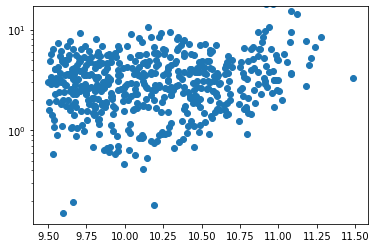

In [16]:
plt.scatter(hdu1_candels_copy_ri1['M_med'],hdu1_candels_copy_ri1['re_f160w'])
plt.yscale('log')
plt.ylim(0,17)

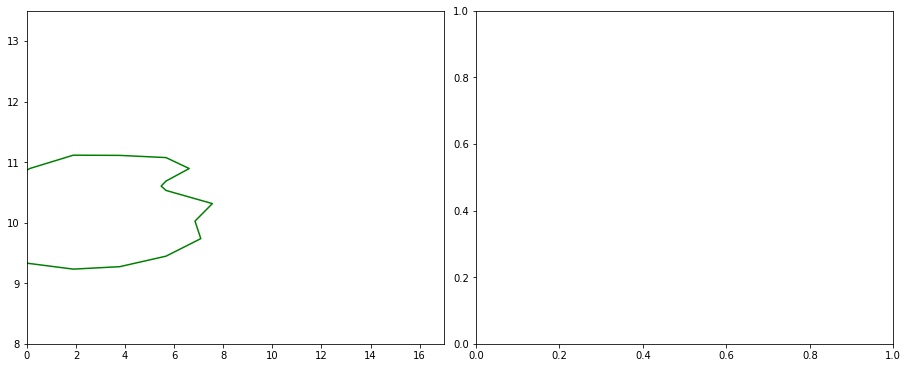

In [20]:
fig,axs = plt.subplots(1,2,figsize=[12.5,5],constrained_layout=True)
# data = ndimage.zoom(h1,[3,5])
# x,y = np.linspace(xedges1[0],xedges1[-1],data.shape[0]),np.linspace(yedges1[0],yedges1[-1],data.shape[1])
x,y = np.linspace(xedges1[0],xedges1[-1],h1.shape[1]),np.linspace(yedges1[0],yedges1[-1],h1.shape[0])
contour = axs[0].contour(y,x,h1.T,levels=[float(level_want_1)],colors=['green']) #xedges[0:xedges.shape[0]-1],yedges[0:yedges.shape[0]-1],h.T
# axs[0].clabel(contour,contour.levels,inline=True,fontsize=8,fmt={1:'100%',float(level_want_1):'90%'},use_clabeltext=True,inline_spacing=0)
# legend_elements=[Line2D([0],[0],lw=2,color='g',label='CANDELS galaxies'),Line2D([0],[0],color='red',lw=0,marker='o',label=r'AGNs'),Line2D([0],[0],color='skyblue',lw=0,marker='o',label='whole sample'),Line2D([0],[0],color='black',lw=0,marker='s',markerfacecolor='none',label='X-ray AGNs')]
# axs[0].legend(handles=legend_elements,fontsize=15,loc='upper left')
# axs[0].set_yscale('log')
# axs[0].set_ylim(0,25)

0
13033004 [5.63181725] 10.397299766540527
13100714 [5.84442765] 10.15369987487793
13017614 [4.95875413] 10.93529987335205
13018076 [6.19667804] 11.097900390625
13033614 [2.52412818] 10.280799865722656
13010566 [3.33288657] 10.206600189208984
13033208 [5.1264015] 10.351099967956543
13017843 [4.0014443] 10.503800392150879
13010519 [3.17453258] 10.660799980163574
13101979 [6.27193622] 10.916500091552734
13003805 [3.97934536] 10.9399995803833
13018498 [6.243494] 10.303000450134277
13033913 [3.25484587] 10.036800384521484
12024099 [4.9867091] 10.278800010681152
13017973 [6.35570257] 10.483200073242188
13026078 [2.92650158] 10.121999740600586
13003614 [0.98381565] 10.379300117492676
13010526 [6.65385981] 10.179300308227539
13033567 [3.84792909] 10.25
13018656 [3.09807708] 10.149700164794922
13026220 [2.70040487] 10.793399810791016
13042381 [0.78218408] 9.663640022277832
12028293 [6.47670614] 10.405699729919434
13026117 [3.24812375] 10.91189956665039
12024267 [3.82081285] 10.065500259399414


<ipython-input-47-f22625cd65ab>:190: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs.set_ylim(0,25)


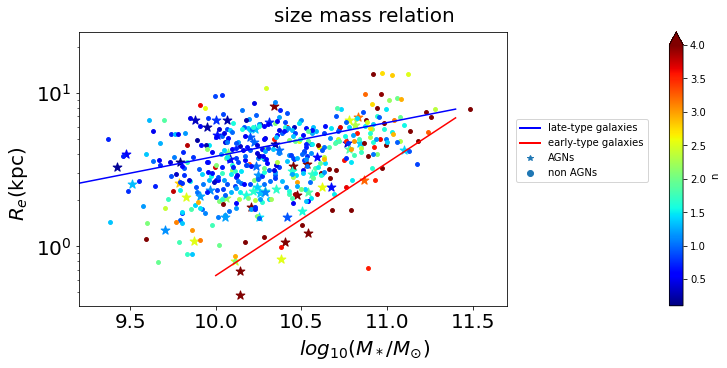

In [47]:
import matplotlib as mpl
# size mass diagram
redshifts = np.array([[0.8,0.999999],[1.0,1.3]])
# cmap = colors.ListedColormap(['blue','red'])
# Norm_bound = colors.BoundaryNorm([0,2,8],cmap.N)
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0.1,vmax=4)

fig,axs = plt.subplots(1,1,figsize=[10,5],constrained_layout=True)#12.5,5
fig.supxlabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
fig.supylabel('$R_e$(kpc)',fontsize=20)
fig.suptitle('size mass relation',fontsize=20)

for num1 in [0,1]:#
#     # constraint redshift
#     agn1_temp = agn1[np.where((agn1['z_used']>=redshifts[num1,0])&(agn1['z_used']<=redshifts[num1,1]))]
#     agn2_temp = agn2[np.where((agn2['z_used']>=redshifts[num1,0])&(agn2['z_used']<=redshifts[num1,1]))]
#     agn3_temp = agn3[np.where((agn3['z_used']>=redshifts[num1,0])&(agn3['z_used']<=redshifts[num1,1]))]
#     nonagn1_temp = nonagn1[np.where((nonagn1['z_used']>=redshifts[num1,0])&(nonagn1['z_used']<=redshifts[num1,1]))]
#     nonagn2_temp = nonagn2[np.where((nonagn2['z_used']>=redshifts[num1,0])&(nonagn2['z_used']<=redshifts[num1,1]))]
#     nonagn3_temp = nonagn3[np.where((nonagn3['z_used']>=redshifts[num1,0])&(nonagn3['z_used']<=redshifts[num1,1]))]
    agn1_temp = agn1
    agn2_temp = agn2
    agn3_temp = agn3
    nonagn1_temp = nonagn1
    nonagn2_temp = nonagn2
    nonagn3_temp = nonagn3
#     # derive agn mass and re
#     agn_mass = np.concatenate((agn1_temp['LMASS'],agn2_temp['LMASS'],agn3_temp['LMASS']),axis=0)
#     agn_re = np.concatenate((agn1_temp['re_f160w'],agn2_temp['re_f160w'],agn3_temp['re_f160w']),axis=0)
#     agn_n = np.concatenate((agn1_temp['n_f160w'],agn2_temp['n_f160w'],agn3_temp['n_f160w']),axis=0)
#     agn_z = np.concatenate((agn1_temp['z_used'],agn2_temp['z_used'],agn3_temp['z_used']),axis=0)
#     # derive all galaxies mass and re
#     nonagn_mass = np.concatenate((nonagn1_temp['LMASS'],nonagn2_temp['LMASS'],nonagn3_temp['LMASS']),axis=0)
#     nonagn_re = np.concatenate((nonagn1_temp['re_f160w'],nonagn2_temp['re_f160w'],nonagn3_temp['re_f160w']),axis=0)
#     nonagn_n = np.concatenate((nonagn1_temp['n_f160w'],nonagn2_temp['n_f160w'],nonagn3_temp['n_f160w']),axis=0)
#     nonagn_z = np.concatenate((nonagn1_temp['z_used'],nonagn2_temp['z_used'],nonagn3_temp['z_used']),axis=0)
#     # morphological k-correction
#     agn_re = agn_re*10**((-0.35+0.12*agn_z-0.25*np.log10(10**agn_mass/10**10))*np.log10(5000./(16000/(1+agn_z))))
#     nonagn_re = nonagn_re*10**((-0.35+0.12*nonagn_z-0.25*np.log10(10**nonagn_mass/10**10))*np.log10(5000./(16000/(1+nonagn_z))))
    if num1 == 0:
        axs.plot(mass_early,re_early_1,color='red',label='early-type')
        axs.plot(mass_late,re_late_1,color='blue',label='late-type')
#         先画agn
        for num2 in range(0,len(agn1_temp)):
            idx = agn1_temp[num2]['id']
            mass = agn1_temp[num2]['lmass_candels']
            logsfr = np.log10(agn1_temp[num2]['sfr_huang'])
            z = agn1_temp[num2]['z_used']
            re = hdu1_re[hdu1_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
            count_spec = hdu1_pair[hdu1_pair['id']==idx]['count_spec'][0]
            if hdu1_re[hdu1_re['id']==idx]['n_f160w'] != -99.:
                n = hdu1_re[hdu1_re['id']==idx]['n_f160w'][0]
            else:
                n = agn1_temp[num2]['n_f160w']
            if z>0.78 and z<=0.93:
                s0,m0,gama = [1.35,9.96,1.28]
            elif z>0.93 and z<=1.11:
                s0,m0,gama = [1.53,10.1,1.26]
            elif z>1.11 and z<=1.3:
                s0,m0,gama = [1.72,10.31,1.07]
            deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
            axs.scatter(mass,re,c=n,marker='*',s=85,cmap='jet',vmin=0.2,vmax=4)
#             axs.scatter(mass,re,c=deltaMS,marker='*',s=85,cmap='jet',vmin=0.1,vmax=5)
#             axs.scatter(mass,re,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#             if mass>10.8 and mass<11 and re<0.9 and re >0.5:
#                 print(idx)
        for num2 in range(0,len(agn2_temp)):
            idx = agn2_temp[num2]['id']
            mass = agn2_temp[num2]['lmass_candels']
            logsfr = np.log10(agn2_temp[num2]['sfr_huang'])
            z = agn2_temp[num2]['z_used']
            re = hdu2_re[hdu2_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
            count_spec = hdu2_pair[hdu2_pair['id']==idx]['count_spec'][0]
            if hdu2_re[hdu2_re['id']==idx]['n_f160w'] != -99.:
                n = hdu2_re[hdu2_re['id']==idx]['n_f160w'][0]
            else:
                n = agn2_temp[num2]['n_f160w']
            if z>0.78 and z<=0.93:
                s0,m0,gama = [1.35,9.96,1.28]
            elif z>0.93 and z<=1.11:
                s0,m0,gama = [1.53,10.1,1.26]
            elif z>1.11 and z<=1.3:
                s0,m0,gama = [1.72,10.31,1.07]
            deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
            axs.scatter(mass,re,c=n,marker='*',s=85,cmap='jet',vmin=0.2,vmax=4)
#             axs.scatter(mass,re,c=deltaMS,marker='*',s=85,cmap='jet',vmin=0.1,vmax=5)
#             axs.scatter(mass,re,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#             if mass>10.8 and mass<11 and re<0.9 and re >0.5:
#                 print(idx)
        for num2 in range(0,len(agn3_temp)):
            idx = agn3_temp[num2]['id']
            mass = agn3_temp[num2]['lmass_candels']
            logsfr = np.log10(agn3_temp[num2]['sfr_huang'])
            z = agn3_temp[num2]['z_used']
            re = hdu3_re[hdu3_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
            count_spec = hdu3_pair[hdu3_pair['id']==idx]['count_spec'][0]
            if hdu3_re[hdu3_re['id']==idx]['n_f160w'] != -99.:
                n = hdu3_re[hdu3_re['id']==idx]['n_f160w'][0]
            else:
                n = agn3_temp[num2]['n_f160w']
            if z>0.78 and z<=0.93:
                s0,m0,gama = [1.35,9.96,1.28]
            elif z>0.93 and z<=1.11:
                s0,m0,gama = [1.53,10.1,1.26]
            elif z>1.11 and z<=1.3:
                s0,m0,gama = [1.72,10.31,1.07]
            deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
            axs.scatter(mass,re,c=n,marker='*',s=85,cmap='jet',vmin=0.2,vmax=4)
#             axs.scatter(mass,re,c=deltaMS,marker='*',s=85,cmap='jet',vmin=0.1,vmax=5)
#             axs.scatter(mass,re,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#             if mass>10.8 and mass<11 and re<0.9 and re >0.5:
#                 print(idx)
#         再画非agn
        for num2 in range(0,len(nonagn1_temp)):
            idx = nonagn1_temp[num2]['id']
            mass = nonagn1_temp[num2]['lmass_candels']
            logsfr = np.log10(nonagn1_temp[num2]['sfr_huang'])
            z = nonagn1_temp[num2]['z_used']
            re = hdu1_re[hdu1_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
            count_spec = hdu1_pair[hdu1_pair['id']==idx]['count_spec'][0]
            if hdu1_re[hdu1_re['id']==idx]['n_f160w'] != -99.:
                n = hdu1_re[hdu1_re['id']==idx]['n_f160w'][0]
            else:
                n = nonagn1_temp[num2]['n_f160w']
            if z>0.78 and z<=0.93:
                s0,m0,gama = [1.35,9.96,1.28]
            elif z>0.93 and z<=1.11:
                s0,m0,gama = [1.53,10.1,1.26]
            elif z>1.11 and z<=1.3:
                s0,m0,gama = [1.72,10.31,1.07]
            deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
            axs.scatter(mass,re,c=n,marker='o',s=15,cmap='jet',vmin=0.2,vmax=4)
#             axs.scatter(mass,re,c=deltaMS,marker='o',s=15,cmap='jet',vmin=0.1,vmax=5)
#             axs.scatter(mass,re,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#             if mass>10.8 and mass<11 and re<0.9 and re >0.5:
#                 print(idx)
        for num2 in range(0,len(nonagn2_temp)):
            idx = nonagn2_temp[num2]['id']
            mass = nonagn2_temp[num2]['lmass_candels']
            logsfr = np.log10(nonagn2_temp[num2]['sfr_huang'])
            z = nonagn2_temp[num2]['z_used']
            re = hdu2_re[hdu2_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
            count_spec = hdu2_pair[hdu2_pair['id']==idx]['count_spec'][0]
            if hdu2_re[hdu2_re['id']==idx]['n_f160w'] != -99.:
                n = hdu2_re[hdu2_re['id']==idx]['n_f160w'][0]
            else:
                n = nonagn2_temp[num2]['n_f160w']
            if z>0.78 and z<=0.93:
                s0,m0,gama = [1.35,9.96,1.28]
            elif z>0.93 and z<=1.11:
                s0,m0,gama = [1.53,10.1,1.26]
            elif z>1.11 and z<=1.3:
                s0,m0,gama = [1.72,10.31,1.07]
            deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
            axs.scatter(mass,re,c=n,marker='o',s=15,cmap='jet',vmin=0.2,vmax=4)
#             axs.scatter(mass,re,c=deltaMS,marker='o',s=15,cmap='jet',vmin=0.1,vmax=5)
#             axs.scatter(mass,re,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#             if mass>10.8 and mass<11 and re<0.9 and re >0.5:
#                 print(idx)
        for num2 in range(0,len(nonagn3_temp)):
            idx = nonagn3_temp[num2]['id']
            mass = nonagn3_temp[num2]['lmass_candels']
            logsfr = np.log10(nonagn3_temp[num2]['sfr_huang'])
            z = nonagn3_temp[num2]['z_used']
            re = hdu3_re[hdu3_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
            count_spec = hdu3_pair[hdu3_pair['id']==idx]['count_spec'][0]
            if hdu3_re[hdu3_re['id']==idx]['n_f160w'] != -99.:
                n = hdu3_re[hdu3_re['id']==idx]['n_f160w'][0]
            else:
                n = nonagn3_temp[num2]['n_f160w']
            if z>0.78 and z<=0.93:
                s0,m0,gama = [1.35,9.96,1.28]
            elif z>0.93 and z<=1.11:
                s0,m0,gama = [1.53,10.1,1.26]
            elif z>1.11 and z<=1.3:
                s0,m0,gama = [1.72,10.31,1.07]
            deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
            axs.scatter(mass,re,c=n,marker='o',s=15,cmap='jet',vmin=0.2,vmax=4)
#             axs.scatter(mass,re,c=deltaMS,marker='o',s=15,cmap='jet',vmin=0.1,vmax=5)
#             axs.scatter(mass,re,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#             if mass>10.8 and mass<11 and re<0.9 and re >0.5:
#                 print(idx)
#         agnscatter = axs[num1].scatter(agn_mass,agn_re,c=agn_n,s=85,marker='*',norm=Norm_bound,cmap=cmap)
#         agnscatter.set_facecolor("none")
#         axs[num1].scatter(nonagn_mass,nonagn_re,c=nonagn_n,s=15,marker='o',norm=Norm_bound,cmap=cmap)
        axs.set_yscale('log')
        axs.set_ylim(0,25)
        axs.set_xlim(9.2,11.7)
        axs.set_xticks([9.5,10,10.5,11,11.5])
        axs.tick_params(axis='both',labelsize=20)
#         axs.text(10.8,0.5,'0.8$\leq z\leq$1',fontsize=20)
#         axs[num1].scatter(hdu1_candels_copy_le1['M_med'],hdu1_candels_copy_le1['re_f160w'],alpha=0.4,color='green',s=3)
#         axs[num1].scatter(hdu2_candels_copy_le1['M_med'],hdu2_candels_copy_le1['re_f160w'],alpha=0.4,color='green',s=3)
#         axs[num1].scatter(hdu3_candels_copy_le1['M_med'],hdu3_candels_copy_le1['re_f160w'],alpha=0.4,color='green',s=3)
#     elif num1 == 1:
#         axs[num1].plot(mass_early,re_early_125,color='red',label='early-type')
#         axs[num1].plot(mass_late,re_late_125,color='blue',label='late-type')
#         #         先画agn
#         for num2 in range(0,len(agn1_temp)):
#             idx = agn1_temp[num2]['id']
#             mass = agn1_temp[num2]['lmass_candels']
#             logsfr = np.log10(agn1_temp[num2]['sfr_huang'])
#             z = agn1_temp[num2]['z_used']
#             re = hdu1_re[hdu1_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
#             if hdu1_re[hdu1_re['id']==idx]['n_f160w'] != -99.:
#                 n = hdu1_re[hdu1_re['id']==idx]['n_f160w']
#             else:
#                 n = agn1_temp['n_f160w']
#             if z>0.78 and z<=0.93:
#                 s0,m0,gama = [1.35,9.96,1.28]
#             elif z>0.93 and z<=1.11:
#                 s0,m0,gama = [1.53,10.1,1.26]
#             elif z>1.11 and z<=1.3:
#                 s0,m0,gama = [1.72,10.31,1.07]
#             deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
#             axs[num1].scatter(mass,re,c=deltaMS,marker='*',s=85,cmap='jet',vmin=0.1,vmax=5)
#         for num2 in range(0,len(agn2_temp)):
#             idx = agn2_temp[num2]['id']
#             mass = agn2_temp[num2]['lmass_candels']
#             logsfr = np.log10(agn2_temp[num2]['sfr_huang'])
#             z = agn2_temp[num2]['z_used']
#             re = hdu2_re[hdu2_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
#             if hdu2_re[hdu2_re['id']==idx]['n_f160w'] != -99.:
#                 n = hdu2_re[hdu2_re['id']==idx]['n_f160w']
#             else:
#                 n = agn2_temp['n_f160w']
#             if z>0.78 and z<=0.93:
#                 s0,m0,gama = [1.35,9.96,1.28]
#             elif z>0.93 and z<=1.11:
#                 s0,m0,gama = [1.53,10.1,1.26]
#             elif z>1.11 and z<=1.3:
#                 s0,m0,gama = [1.72,10.31,1.07]
#             deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
#             axs[num1].scatter(mass,re,c=deltaMS,marker='*',s=85,cmap='jet',vmin=0.1,vmax=5)
#         for num2 in range(0,len(agn3_temp)):
#             idx = agn3_temp[num2]['id']
#             mass = agn3_temp[num2]['lmass_candels']
#             logsfr = np.log10(agn3_temp[num2]['sfr_huang'])
#             z = agn3_temp[num2]['z_used']
#             re = hdu3_re[hdu3_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
#             if hdu3_re[hdu3_re['id']==idx]['n_f160w'] != -99.:
#                 n = hdu3_re[hdu3_re['id']==idx]['n_f160w']
#             else:
#                 n = agn3_temp['n_f160w']
#             if z>0.78 and z<=0.93:
#                 s0,m0,gama = [1.35,9.96,1.28]
#             elif z>0.93 and z<=1.11:
#                 s0,m0,gama = [1.53,10.1,1.26]
#             elif z>1.11 and z<=1.3:
#                 s0,m0,gama = [1.72,10.31,1.07]
#             deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
#             axs[num1].scatter(mass,re,c=deltaMS,marker='*',s=85,cmap='jet',vmin=0.1,vmax=5)
# #         再画非agn
#         for num2 in range(0,len(nonagn1_temp)):
#             idx = nonagn1_temp[num2]['id']
#             mass = nonagn1_temp[num2]['lmass_candels']
#             logsfr = np.log10(nonagn1_temp[num2]['sfr_huang'])
#             z = nonagn1_temp[num2]['z_used']
#             re = hdu1_re[hdu1_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
#             if hdu1_re[hdu1_re['id']==idx]['n_f160w'] != -99.:
#                 n = hdu1_re[hdu1_re['id']==idx]['n_f160w']
#             else:
#                 n = nonagn1_temp['n_f160w']
#             if z>0.78 and z<=0.93:
#                 s0,m0,gama = [1.35,9.96,1.28]
#             elif z>0.93 and z<=1.11:
#                 s0,m0,gama = [1.53,10.1,1.26]
#             elif z>1.11 and z<=1.3:
#                 s0,m0,gama = [1.72,10.31,1.07]
#             deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
#             axs[num1].scatter(mass,re,c=deltaMS,marker='o',s=15,cmap='jet',vmin=0.1,vmax=5)
#         for num2 in range(0,len(nonagn2_temp)):
#             idx = nonagn2_temp[num2]['id']
#             mass = nonagn2_temp[num2]['lmass_candels']
#             logsfr = np.log10(nonagn2_temp[num2]['sfr_huang'])
#             z = nonagn2_temp[num2]['z_used']
#             re = hdu2_re[hdu2_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
#             if hdu2_re[hdu2_re['id']==idx]['n_f160w'] != -99.:
#                 n = hdu2_re[hdu2_re['id']==idx]['n_f160w']
#             else:
#                 n = nonagn2_temp['n_f160w']
#             if z>0.78 and z<=0.93:
#                 s0,m0,gama = [1.35,9.96,1.28]
#             elif z>0.93 and z<=1.11:
#                 s0,m0,gama = [1.53,10.1,1.26]
#             elif z>1.11 and z<=1.3:
#                 s0,m0,gama = [1.72,10.31,1.07]
#             deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
#             axs[num1].scatter(mass,re,c=deltaMS,marker='o',s=15,cmap='jet',vmin=0.1,vmax=5)
#         for num2 in range(0,len(nonagn3_temp)):
#             idx = nonagn3_temp[num2]['id']
#             mass = nonagn3_temp[num2]['lmass_candels']
#             logsfr = np.log10(nonagn3_temp[num2]['sfr_huang'])
#             z = nonagn3_temp[num2]['z_used']
#             re = hdu3_re[hdu3_re['id']==idx]['re']*kpc_per_arcsec(z) #使用修改过后的re
#             if hdu3_re[hdu3_re['id']==idx]['n_f160w'] != -99.:
#                 n = hdu3_re[hdu3_re['id']==idx]['n_f160w']
#             else:
#                 n = nonagn3_temp['n_f160w']
#             if z>0.78 and z<=0.93:
#                 s0,m0,gama = [1.35,9.96,1.28]
#             elif z>0.93 and z<=1.11:
#                 s0,m0,gama = [1.53,10.1,1.26]
#             elif z>1.11 and z<=1.3:
#                 s0,m0,gama = [1.72,10.31,1.07]
#             deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
#             axs[num1].scatter(mass,re,c=deltaMS,marker='o',s=15,cmap='jet',vmin=0.1,vmax=5)
# #         agnscatter = axs[num1].scatter(agn_mass,agn_re,c=agn_n,s=85,marker='*',norm=Norm_bound,cmap=cmap)
# #         agnscatter.set_facecolor("none")
# #         axs[num1].scatter(nonagn_mass,nonagn_re,c=nonagn_n,s=15,marker='o',norm=Norm_bound,cmap=cmap)
#         axs[num1].set_yscale('log')
#         axs[num1].yaxis.tick_right()
#         axs[num1].set_ylim(0,25)
#         axs[num1].set_xlim(9.4,11.5)
#         axs[num1].set_xticks([9.5,10,10.5,11])
#         axs[num1].tick_params(axis='both',labelsize=20)
#         axs[num1].text(10.8,0.5,'1<z$\leq$1.3',fontsize=20)
#         axs[num1].scatter(hdu1_candels_copy_ri1['M_med'],hdu1_candels_copy_ri1['re_f160w'],alpha=0.4,color='green',s=3)
#         axs[num1].scatter(hdu2_candels_copy_ri1['M_med'],hdu2_candels_copy_ri1['re_f160w'],alpha=0.4,color='green',s=3)
#         axs[num1].scatter(hdu3_candels_copy_ri1['M_med'],hdu3_candels_copy_ri1['re_f160w'],alpha=0.4,color='green',s=3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),label='n',extend='max')#$SFR/SFR_{MS}$
# legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='*',color='blue',label=r'disk AGNs'),Line2D([0],[0],lw=0,marker='*',color='red',label=r'bulge AGNs'),Line2D([0],[0],lw=0,marker='o',color='blue',label='disk galaxies'),Line2D([0],[0],lw=0,marker='o',color='red',label='bulge galaxies')]
legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='*',label='AGNs'),Line2D([0],[0],lw=0,marker='o',label='non AGNs')]
# legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='*',label='non pair',color='blue'),Line2D([0],[0],lw=0,marker='o',label='pair_spec',color='red')]
plt.legend(handles=legend_elements,fontsize=10,loc='upper left',bbox_to_anchor=[1.01,0.7])
# fig.savefig('/Users/lpr/Data/lirg_project/output/images/size_mass_radec_del_ncoded_re1.pdf')

<ipython-input-165-84786758c6ff>:26: RuntimeWarning: divide by zero encountered in log10
  l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])


12028094


<ipython-input-165-84786758c6ff>:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max',location='top')#$SFR/SFR_{MS}$


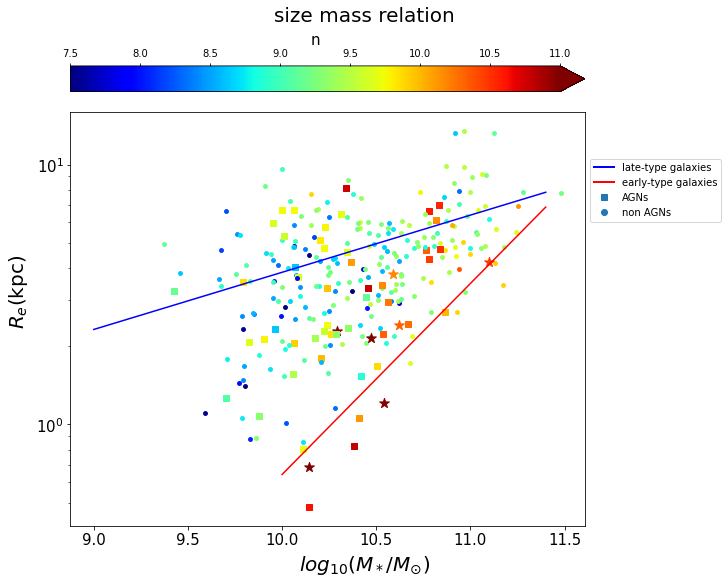

In [165]:
# size mass diagram
smallagn = np.array([11054, 19267, 11519, 23844, 27302, 12353, 13017707, 13004291]) #从sfr-re图上得到的logsfr>2，re<6kpc的星系，不全是agn
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=7.5,vmax=11)
fields_list = ['goodsn','goodss','egs']
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
fig,axs = plt.subplots(1,1,figsize=[10,8],constrained_layout=True)#12.5,5
fig.supxlabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
fig.supylabel('$R_e$(kpc)',fontsize=20)
fig.suptitle('size mass relation',fontsize=20)
axs.plot(mass_early,re_early_1,color='red',label='early-type')
axs.plot(mass_late,re_late_1,color='blue',label='late-type')
axs.set_yscale('log')
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    all_catalog = fits.getdata(root_path+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    all_catalog = all_catalog[np.isin(all_catalog['id'],id_ctg['id'])]
    for num1 in range(0,all_catalog.size):
        idx = all_catalog[num1]['id']
        lmass_candels = all_catalog[num1]['lmass_candels']
        z = all_catalog[num1]['z_used']
        re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z)
        sed_class = all_catalog[num1]['TMP_CLASS'][0]
        logsfr = np.log10(all_catalog[num1]['sfr_huang'])
        l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])
        if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
            n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
        else:
            n=all_catalog[num1]['n_f160w']
        if lmass_candels >10.5 and lmass_candels<11 and re>0.3 and re<1:
            print(idx)
    #        if z>0.78 and z<=0.93:
    #            s0,m0,gama = [1.35,9.96,1.28]
    #        elif z>0.93 and z<=1.11:
    #            s0,m0,gama = [1.53,10.1,1.26]
    #        elif z>1.11 and z<=1.3:
    #            s0,m0,gama = [1.72,10.31,1.07]
    #        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
        if sed_class==1:
            if idx in smallagn:
                symbol = '*'
                size = 105
            else:
                symbol = 's'
                size = 30
        else:
            symbol = 'o'
            size = 15
        axs.scatter(lmass_candels,re,c=l4p5ex,marker=symbol,s=size,vmin=7.5,vmax=11,cmap='jet')
axs.tick_params(axis='both',labelsize=15)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max',location='top')#$SFR/SFR_{MS}$
cb.set_label(label='n',fontsize=15)
# legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='*',color='blue',label=r'disk AGNs'),Line2D([0],[0],lw=0,marker='*',color='red',label=r'bulge AGNs'),Line2D([0],[0],lw=0,marker='o',color='blue',label='disk galaxies'),Line2D([0],[0],lw=0,marker='o',color='red',label='bulge galaxies')]
legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='s',label='AGNs'),Line2D([0],[0],lw=0,marker='o',label='non AGNs')]
plt.legend(handles=legend_elements,fontsize=10,loc='upper left',bbox_to_anchor=[1,0.9])
# fig.savefig('/Users/lpr/Data/lirg_project/output/images/size_mass_ncoded.pdf')

In [30]:
# UVI extinction direction
x_tail = 0.6
y_tail = 0.5
x_head = 1.0
y_head = 1.0
dx = x_head - x_tail
dy = y_head - y_tail
arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),mutation_scale=100)

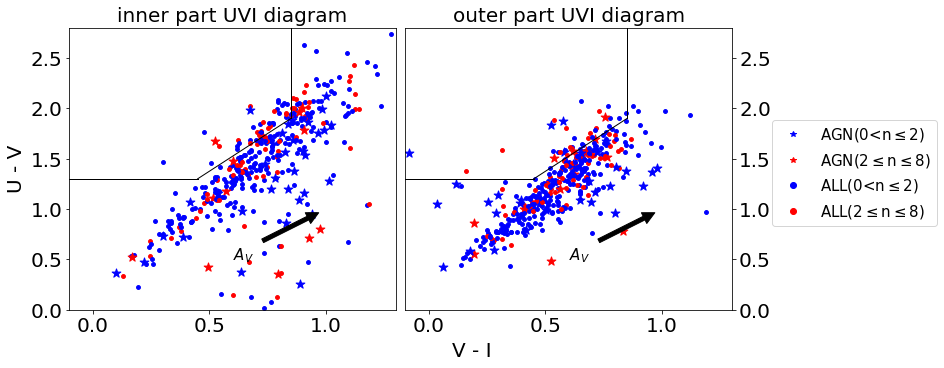

In [95]:
# UVI diagram
fields_list = ['goodsn','goodss','egs']
root_path = '/Users/lpr/Data/lirg_project/output/catalog/'
l_x = np.linspace(0.45,0.85,100)
l_y = 1.5*l_x+0.625
fig,axs = plt.subplots(1,2,figsize=[13,5],constrained_layout=True)
fig.supxlabel('V - I',fontsize=20)
for field in fields_list: # two parts of galaxies' UVI
    uvi_catalog = fits.open(root_path+field+'_uvi_res_CANDELS_c1_onlygdnfrac.fits')[1].data
    all_catalog = fits.open(root_path+field+'_Huangall_candels_radec_van.fits')[1].data
    uvi_catalog = uvi_catalog[np.where((uvi_catalog['z_used']<=1.3)&(uvi_catalog['z_used']>=0.8)&(uvi_catalog['ID_Huang']!=-1))]
    for num1 in range(0,uvi_catalog.size):
        idx = uvi_catalog[num1]['ID_Huang']
        if all_catalog[np.where(all_catalog['ID']==idx)]['Separation_CANDELS_16']<1 and all_catalog[np.where(all_catalog['ID']==idx)]['f_f160w']!=2:
            # inner part
            uv_bulge = uvi_catalog[num1]['uv_bulge']
            vi_bulge = uvi_catalog[num1]['vi_bulge']
            # outer part
            uv_disk = uvi_catalog[num1]['uv_disk']
            vi_disk = uvi_catalog[num1]['vi_disk']
            n = all_catalog[np.where(all_catalog['ID']==idx)]['n_f160w'][0]
            sed_class = all_catalog[np.where(all_catalog['ID']==idx)]['TMP_CLASS'][0][0]
            if n>0 and n<=2:
                color='blue'
            elif n>2 and n<4:
                color='red'
            if sed_class==1:
                symbol = '*'
                size = 85
            else:
                symbol = 'o'
                size = 15
            axs[0].scatter(vi_bulge,uv_bulge,color=color,marker=symbol,s=size)
            axs[1].scatter(vi_disk,uv_disk,color=color,marker=symbol,s=size)
# set x and y axis label
axs[0].annotate(r'$A_V$',xy=(x_head,y_head),xytext=(x_tail,y_tail),arrowprops=dict(facecolor='black', shrink=0.1),fontsize=15)
axs[0].plot([-2,0.45],[1.3,1.3],color='black',linewidth=1)
axs[0].plot([0.85,0.85],[1.9,3],color='black',linewidth=1)
axs[0].plot(l_x,l_y,color='black',linewidth=1)
axs[0].set_xlim(-0.1,1.3)
axs[0].set_ylim(0,2.8)
axs[0].set_ylabel('U - V',fontsize=20)
axs[0].set_title('inner part UVI diagram',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[1].yaxis.tick_right()
axs[1].annotate(r'$A_V$',xy=(x_head,y_head),xytext=(x_tail,y_tail),arrowprops=dict(facecolor='black', shrink=0.1),fontsize=15)
axs[1].plot([-2,0.45],[1.3,1.3],color='black',linewidth=1)
axs[1].plot([0.85,0.85],[1.9,3],color='black',linewidth=1)
axs[1].plot(l_x,l_y,color='black',linewidth=1)
axs[1].set_xlim(-0.1,1.3)
axs[1].set_ylim(0,2.8)
axs[1].set_title('outer part UVI diagram',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
legend_elements=[Line2D([0],[0],lw=0,marker='*',color='blue',label=r'AGN(0<n$\leq$2)'),Line2D([0],[0],lw=0,marker='*',color='red',label=r'AGN(2$\leq$n$\leq$8)'),Line2D([0],[0],lw=0,marker='o',color='blue',label='ALL(0<n$\leq$2)'),Line2D([0],[0],lw=0,marker='o',color='red',label='ALL(2$\leq$n$\leq$8)')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left',bbox_to_anchor=[1.1,0.7])
fig.savefig('/Users/lpr/Data/lirg_project/output/images/UVI.pdf')

In [4]:
# UVI diagram
fields_list = ['goodsn','goodss','egs']
size_combine = 0
for field in fields_list:
    temp = fits.open('/Users/lpr/Data/lirg_project/output/catalog/'+field+'_uvi_res_CANDELS_c1_onlygdnfrac.fits')[1].data
    temp = temp[np.where((temp['z_used']<1.3)&(temp['z_used']>0.8)&(temp['ID_Huang']!=-1))]
    size_combine += temp.size
array_combine = np.full([size_combine,8],-999.)
size_combine = 0
l_x = np.linspace(0.45,0.85,100)
l_y = 1.5*l_x+0.625
for field in fields_list:
    uvi_catalog = fits.open('/Users/lpr/Data/lirg_project/output/catalog/'+field+'_uvi_res_CANDELS_c1_onlygdnfrac.fits')[1].data
    all_catalog = fits.open('/Users/lpr/Data/lirg_project/output/catalog/'+field+'_Huangall_candels_radec_van.fits')[1].data
    uvi_catalog = uvi_catalog[np.where((uvi_catalog['z_used']<1.3)&(uvi_catalog['z_used']>0.8)&(uvi_catalog['ID_Huang']!=-1))]
    array = np.full([uvi_catalog.size,8],-999.)
    for num in range(0,uvi_catalog.size):
        idx = uvi_catalog[num]['ID_Huang']
        if all_catalog[np.where(all_catalog['ID']==idx)]['Separation_CANDELS_16']<1:# and morph_catalog[np.where(morph_catalog['ID']==idx)]['morph'] != -1:
            uv_bulge = uvi_catalog[num]['uv_bulge']
            uv_disk = uvi_catalog[num]['uv_disk']
            vi_bulge = uvi_catalog[num]['vi_bulge']
            vi_disk = uvi_catalog[num]['vi_disk']
            z = uvi_catalog[num]['z_used']
            gala_class = all_catalog[np.where(all_catalog['ID']==idx)]['TMP_CLASS'][0,0]
#             re = all_catalog[np.where(all_catalog['ID']==idx)]['re_f160w'][0]*kpc_per_arcsec(z)
            n = all_catalog[np.where(all_catalog['ID']==idx)]['n_f160w'][0]
            array[num] = idx,uv_bulge,uv_disk,vi_bulge,vi_disk,z,n,gala_class
    array_combine[size_combine:size_combine+uvi_catalog.size] = array
    size_combine += uvi_catalog.size

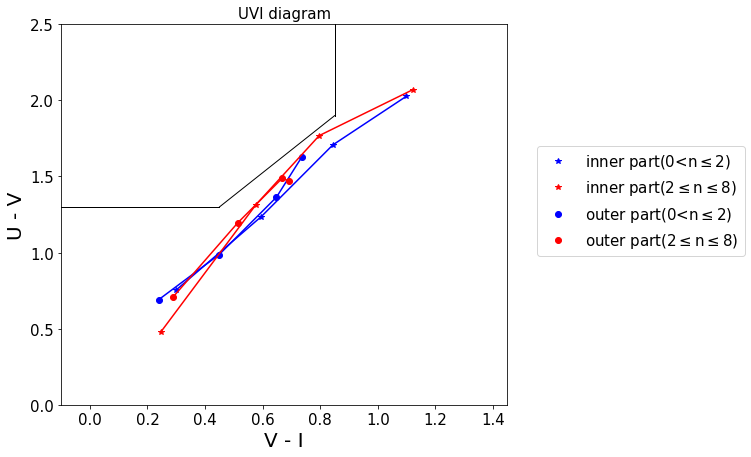

In [48]:
# UVI diagram
array_combine = array_combine[np.where((array_combine[:,1]>0)&(array_combine[:,1]<3)&(array_combine[:,3]>0)&(array_combine[:,3]<1.4)&(array_combine[:,1+1]>0)&(array_combine[:,1+1]<3)&(array_combine[:,3+1]>0)&(array_combine[:,3+1]<1.4))]
cmap = colors.ListedColormap(['skyblue','blue','green','orange','red'])
Norm_bound = colors.BoundaryNorm([0,1,2,3,4,8],cmap.N)
l_x = np.linspace(0.45,0.85,100)
l_y = 1.5*l_x+0.625
plt.figure(figsize=(8,7))
bins=[0,0.35,0.7,1.05,1.4]
color=['blue','red']
array = np.full([4,4,2],-999.)
for num1 in [0,1,2,3]:
    point=array_combine[np.where((array_combine[:,3]>bins[num1])&(array_combine[:,3]<bins[num1+1])&(array_combine[:,6]>0)&(array_combine[:,6]<=2))]
    x=np.median(point[:,3])
    y=np.median(point[:,1])
#     plt.plot(x,y,'b*-')
    array[1-1,num1]=[x,y]
    x=np.median(point[:,3+1])
    y=np.median(point[:,1+1])
#     plt.plot(x,y,'bo-')
    array[2-1,num1]=[x,y]
    point=array_combine[np.where((array_combine[:,3]>bins[num1])&(array_combine[:,3]<bins[num1+1])&(array_combine[:,6]>2)&(array_combine[:,6]<=8))]
    x=np.median(point[:,3])
    y=np.median(point[:,1])
#     plt.plot(x,y,'r*-')
    array[3-1,num1]=[x,y]
    x=np.median(point[:,3+1])
    y=np.median(point[:,1+1])
#     plt.plot(x,y,'ro-')
    array[4-1,num1]=[x,y]
plt.plot(array[1-1,:,0],array[1-1,:,1],'b*-')
plt.plot(array[2-1,:,0],array[2-1,:,1],'bo-')
plt.plot(array[3-1,:,0],array[3-1,:,1],'r*-')
plt.plot(array[4-1,:,0],array[4-1,:,1],'ro-')
plt.plot([-2,0.45],[1.3,1.3],color='black',linewidth=1)
plt.plot([0.85,0.85],[1.9,3],color='black',linewidth=1)
plt.plot(l_x,l_y,color='black',linewidth=1)
plt.xlim(-0.1,1.45)
plt.ylim(0,2.5)
plt.xlabel('V - I',fontsize=20)
plt.ylabel('U - V',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
legend_elements=[Line2D([0],[0],lw=0,marker='*',color='blue',label=r'inner part(0<n$\leq$2)'),Line2D([0],[0],lw=0,marker='*',color='red',label=r'inner part(2$\leq$n$\leq$8)'),Line2D([0],[0],lw=0,marker='o',color='blue',label='outer part(0<n$\leq$2)'),Line2D([0],[0],lw=0,marker='o',color='red',label='outer part(2$\leq$n$\leq$8)')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left',bbox_to_anchor=[1.05,0.7])
plt.title('UVI diagram',fontsize=15)
plt.savefig('/Users/lpr/Data/lirg_project/output/images/UVI_wang.pdf')

<ipython-input-88-6cae5f9be368>:22: RuntimeWarning: divide by zero encountered in log10
  hist,bins_edges=np.histogram(np.log10(np.concatenate((hdu1[np.where((hdu1['n_f160w']<=2)&(hdu1['n_f160w']>0))]['L4P5EX'],hdu2[np.where((hdu2['n_f160w']<=2)&(hdu2['n_f160w']>0))]['L4P5EX'],hdu3[np.where((hdu3['n_f160w']<=2)&(hdu3['n_f160w']>0))]['L4P5EX']),axis=0)),bins=7,range=[8,12])
<ipython-input-88-6cae5f9be368>:26: RuntimeWarning: divide by zero encountered in log10
  hist,bins_edges=np.histogram(np.log10(np.concatenate((hdu1[np.where((hdu1['n_f160w']<=8)&(hdu1['n_f160w']>2))]['L4P5EX'],hdu2[np.where((hdu2['n_f160w']<=8)&(hdu2['n_f160w']>2))]['L4P5EX'],hdu3[np.where((hdu3['n_f160w']<=8)&(hdu3['n_f160w']>2))]['L4P5EX']),axis=0)),bins=7,range=[8,12])


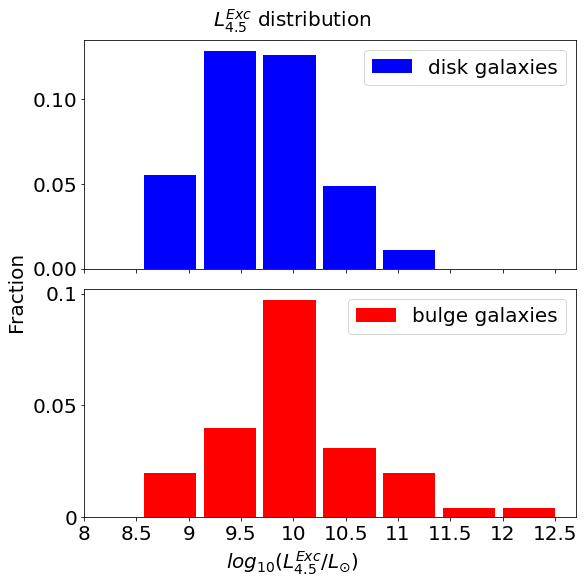

In [88]:
# draw bulge and disk-dominated galaxies' sfr and l4p5ex distribution
# ======================== SFR distribution
# fig,axs=plt.subplots(2,1,figsize=(10,10),sharex=True,constrained_layout=True)
# fig.supylabel('Fraction',fontsize=20)
# fig.supxlabel(r'SFR($M_{\odot} yr^{-1}$)',fontsize=20)
# fig.suptitle('SFR distribution',fontsize=20)
# hist,bins_edges=np.histogram(np.concatenate((np.log10(hdu1[np.where((hdu1['n_f160w']<=2)&(hdu1['n_f160w']>0))]['SFR_8umsfr']),np.log10(hdu2[np.where((hdu2['n_f160w']<=2)&(hdu2['n_f160w']>0))]['SFR_8umsfr']),np.log10(hdu3[np.where((hdu3['n_f160w']<=2)&(hdu3['n_f160w']>0))]['SFR_8umsfr'])),axis=0),bins=15,range=[0,2.2])
# axs[0].bar(bins_edges[1:],hist/(len(hdu1)+len(hdu2)+len(hdu3)),width=-0.1,align='edge',color='blue',label='disk galaxies')
# axs[0].tick_params(axis='y',labelsize=20)
# axs[0].legend(fontsize=20)
# hist,bins_edges=np.histogram(np.concatenate((np.log10(hdu1[np.where((hdu1['n_f160w']<=8)&(hdu1['n_f160w']>2))]['SFR_8umsfr']),np.log10(hdu2[np.where((hdu2['n_f160w']<=8)&(hdu2['n_f160w']>2))]['SFR_8umsfr']),np.log10(hdu3[np.where((hdu3['n_f160w']<=8)&(hdu3['n_f160w']>2))]['SFR_8umsfr'])),axis=0),bins=15,range=[0,2.2])
# axs[1].bar(bins_edges[1:],hist/(len(hdu1)+len(hdu2)+len(hdu3)),width=-0.1,align='edge',color='red',label='bulge galaxies')
# # axs[1].set_xticks(bins_edges,np.around(np.array(bins_edges,dtype='<f4'),1)) #integer:int
# axs[1].set_xticks([0,0.5,1,1.5,2,2.2],[0,0.5,1,1.5,2,2.2]) #integer:int
# axs[1].tick_params(axis='both',labelsize=20)
# axs[1].legend(fontsize=20)
# ======================== l4p5ex distribution
fig,axs=plt.subplots(2,1,figsize=(8,8),sharex=True,constrained_layout=True)
fig.supylabel('Fraction',fontsize=20)
fig.supxlabel(r'$log_{10}(L_{4.5}^{Exc}/L_{\odot})$',fontsize=20)
fig.suptitle('$L_{4.5}^{Exc}$ distribution',fontsize=20)
hist,bins_edges=np.histogram(np.log10(np.concatenate((hdu1[np.where((hdu1['n_f160w']<=2)&(hdu1['n_f160w']>0))]['L4P5EX'],hdu2[np.where((hdu2['n_f160w']<=2)&(hdu2['n_f160w']>0))]['L4P5EX'],hdu3[np.where((hdu3['n_f160w']<=2)&(hdu3['n_f160w']>0))]['L4P5EX']),axis=0)),bins=7,range=[8,12])
axs[0].bar(bins_edges[1:],hist/(len(hdu1)+len(hdu2)+len(hdu3)),align='edge',width=0.5,color='blue',label='disk galaxies')
axs[0].tick_params(axis='y',labelsize=20)
axs[0].legend(fontsize=20)
hist,bins_edges=np.histogram(np.log10(np.concatenate((hdu1[np.where((hdu1['n_f160w']<=8)&(hdu1['n_f160w']>2))]['L4P5EX'],hdu2[np.where((hdu2['n_f160w']<=8)&(hdu2['n_f160w']>2))]['L4P5EX'],hdu3[np.where((hdu3['n_f160w']<=8)&(hdu3['n_f160w']>2))]['L4P5EX']),axis=0)),bins=7,range=[8,12])
axs[1].bar(bins_edges[1:],hist/(len(hdu1)+len(hdu2)+len(hdu3)),align='edge',width=0.5,color='red',label='bulge galaxies')
axs[1].set_yticks([0,0.05,0.10],[0,0.05,0.10])
axs[1].set_xticks([8,8.5,9,9.5,10,10.5,11,11.5,12,12.5],[8,8.5,9,9.5,10,10.5,11,11.5,12,12.5])
axs[1].tick_params(axis='both',labelsize=20)
axs[1].legend(fontsize=20)
plt.savefig('/Users/lpr/Data/lirg_project/output/images/agn_distribution.png')

In [37]:
print(np.median(nresfr[:,0]),np.median(nresfr[:,1]))

1.3827999830245972 3.7931153520475953


In [54]:
all_l4p5ex=np.log10(np.concatenate((hdu1['L4P5EX'],hdu2['L4P5EX'],hdu3['L4P5EX']),axis=0))
all_n=np.concatenate((hdu1['n_f160w'],hdu2['n_f160w'],hdu3['n_f160w']),axis=0)
all_sfr=np.concatenate((hdu1['SFR_huang'],hdu2['SFR_huang'],hdu3['SFR_huang']),axis=0)

agn_l4p5ex=np.log10(np.concatenate((hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['L4P5EX'],hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['L4P5EX'],hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['L4P5EX']),axis=0))
agn_l4p5exerr=np.concatenate((hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['E4P5EX']/(hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['L4P5EX']*np.log(10)),hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['E4P5EX']/(hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['L4P5EX']*np.log(10)),hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['E4P5EX']/(hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['L4P5EX']*np.log(10))),axis=0)
agn_n=np.concatenate((hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['n_f160w'],hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['n_f160w'],hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['n_f160w']),axis=0)
agn_nerr=np.concatenate((hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['dn_f160w'],hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['dn_f160w'],hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['dn_f160w']),axis=0)
agn_sfr=np.concatenate((hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['SFR_huang'],hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['SFR_huang'],hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['SFR_huang']),axis=0)
agn_sfrerr=np.concatenate((hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['SFR_huangerr'],hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['SFR_huangerr'],hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['SFR_huangerr']),axis=0)

<ipython-input-54-e78493c01a10>:1: RuntimeWarning: divide by zero encountered in log10
  all_l4p5ex=np.log10(np.concatenate((hdu1['L4P5EX'],hdu2['L4P5EX'],hdu3['L4P5EX']),axis=0))
<ipython-input-54-e78493c01a10>:5: RuntimeWarning: divide by zero encountered in log10
  agn_l4p5ex=np.log10(np.concatenate((hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['L4P5EX'],hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['L4P5EX'],hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['L4P5EX']),axis=0))
<ipython-input-54-e78493c01a10>:6: RuntimeWarning: divide by zero encountered in divide
  agn_l4p5exerr=np.concatenate((hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['E4P5EX']/(hdu1[np.where(hdu1['TMP_CLASS'][:,0]==1)]['L4P5EX']*np.log(10)),hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['E4P5EX']/(hdu2[np.where(hdu2['TMP_CLASS'][:,0]==1)]['L4P5EX']*np.log(10)),hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['E4P5EX']/(hdu3[np.where(hdu3['TMP_CLASS'][:,0]==1)]['L4P5EX']*np.log(10))),axis=0)


<ipython-input-10-5b6b9ab5883c>:22: RuntimeWarning: divide by zero encountered in log10
  l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])
<ipython-input-10-5b6b9ab5883c>:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max')#$SFR/SFR_{MS}$


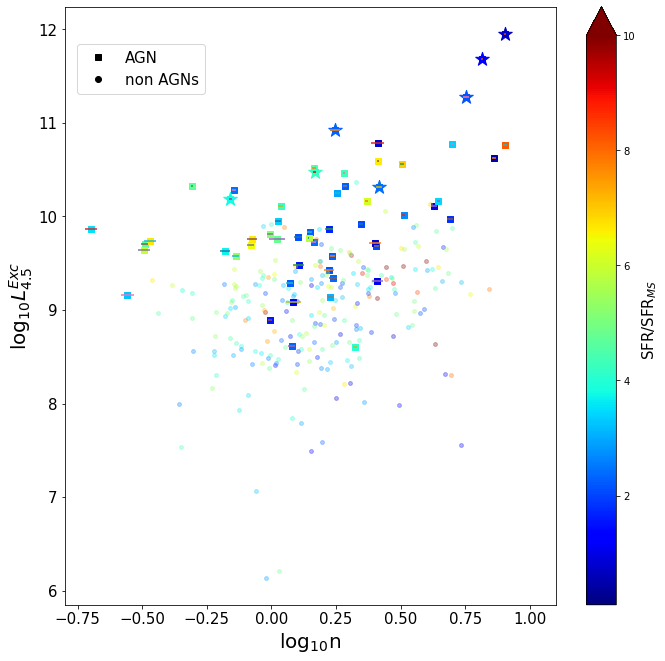

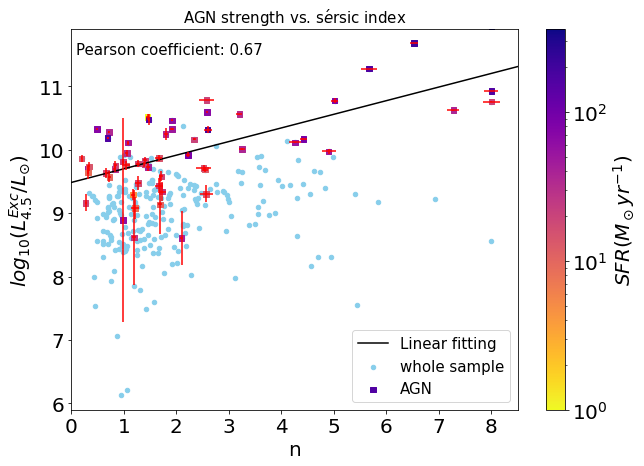

In [57]:
result=stats.linregress(agn_n[np.where(agn_l4p5ex!=-np.inf)],agn_l4p5ex[np.where(agn_l4p5ex!=-np.inf)])
x=np.linspace(0,8.5,100)
y=result.slope*x+result.intercept
plt.figure(figsize=[10,7])
plt.plot(x,y,color='black',label='Linear fitting')
plt.scatter(all_n,all_l4p5ex,color='skyblue',s=20,label='whole sample')
plt.errorbar(agn_n,agn_l4p5ex,xerr=agn_nerr,yerr=agn_l4p5exerr,fmt='none',ecolor='red')
plt.scatter(agn_n,agn_l4p5ex,c=agn_sfr,s=30,cmap='plasma_r',marker='s',label='AGN',norm=colors.LogNorm(vmin=1,vmax=np.max(agn_sfr)))
plt.text(0.1,11.5,'Pearson coefficient: '+str(round(result.rvalue,2)),fontsize=15)
cb = plt.colorbar()
cb.set_label('$SFR (M_\odot yr^{-1}$)',fontsize=20)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=15,loc='lower right')
plt.ylim(5.9,11.9)
plt.xlim(0,8.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(r'AGN strength vs. s${\'e}$rsic index',fontsize=15)
plt.xlabel('n',fontsize=20)
plt.ylabel('$log_{10}(L_{4.5}^{Exc}/L_{\odot})$',fontsize=20)
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/l4p5ex_n_radec_del.png')
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/l4p5ex_n_radec_del.pdf')

In [33]:
# quiescent_region = Polygon([(8.,-0.5),(11,-0.5),(11,-2.),(8.,-2.)])
# sf_region=Polygon([(8.,-0.5),(11,-0.5),(11.,2.),(8.,2.)])
# agn_q=0
# agn_s=0
# all_q=0
# all_s=0
# for num in range(0,len(agn_mass)):
#     x,y=np.log10(10**agn_mass[num]/agn_re[num]**1.5),np.log10((agn_sfr[num]/10**agn_mass[num])*1e9)
#     if quiescent_region.contains(Point(x,y)):
#         agn_q+=1
#     elif sf_region.contains(Point(x,y)):
#         agn_s+=1
# for num in range(0,len(all_mass)):
#     x,y=np.log10(10**all_mass[num]/all_re[num]**1.5),np.log10((all_sfr[num]/10**all_mass[num])*1e9)
#     if quiescent_region.contains(Point(x,y)):
#         all_q+=1
#     elif sf_region.contains(Point(x,y)):
#         all_s+=1
# print((agn_q+12)/all_q,(agn_s+15)/all_s)
quiescent_region = Polygon([(4,7),(6,7),(6,9),(4,9)])
idx_list = []
for num in range(0,len(hdu1)):
#     print(hdu2[num]['L4P5EX'])
    x,y=hdu1[num]['n_f160w'],np.log10(hdu1[num]['L4P5EX'])
    idx = hdu1[num]['ID']
    if quiescent_region.contains(Point(x,y)):
        idx_list.append(idx)
print(idx_list)

<ipython-input-33-ba1e8966fcac>:24: RuntimeWarning: divide by zero encountered in log10
  x,y=hdu1[num]['n_f160w'],np.log10(hdu1[num]['L4P5EX'])


[29835, 6248, 35739, 11014]


In [71]:
from scipy import stats
# plot mass vs. l4p5sf
hdu_gdn=fits.open('/Users/lpr/Data/lirg_project/output/catalog_radec/goodsn_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits')[1].data
hdu_gds=fits.open('/Users/lpr/Data/lirg_project/output/catalog_radec/goodss_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits')[1].data
hdu_egs=fits.open('/Users/lpr/Data/lirg_project/output/catalog_radec/egs_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits')[1].data
# hdu_gdn=hdu_gdn[np.where((hdu_gdn['z_used']>=0.8)&(hdu_gdn['z_used']<=1.3)&(hdu_gdn['ID']!=-1)&(hdu_gdn['Separation_candels_16']<=1))]
# hdu_gds=hdu_gds[np.where((hdu_gds['z_used']>=0.8)&(hdu_gds['z_used']<=1.3)&(hdu_gds['ID']!=-1)&(hdu_gds['Separation_candels_16']<=1))]
# hdu_egs=hdu_egs[np.where((hdu_egs['z_used']>=0.8)&(hdu_egs['z_used']<=1.3)&(hdu_egs['ID']!=-1)&(hdu_egs['Separation_candels_16']<=1))]
hdu_gdn_id = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/goodsn_id.fits',1)
hdu_gds_id = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/goodss_id.fits',1)
hdu_egs_id = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/egs_id.fits',1)
hdu_gdn = hdu_gdn[np.isin(hdu_gdn['id'],hdu_gdn_id['id'])]
hdu_gds = hdu_gds[np.isin(hdu_gds['id'],hdu_gds_id['id'])]
hdu_egs = hdu_egs[np.isin(hdu_egs['id'],hdu_egs_id['id'])]
# ; ensure the star forming 4.5um luminosity vs. mass relation do not contaminated by AGN
nonagn_gdn=hdu_gdn[np.where((hdu_gdn['l4p5ex']/hdu_gdn['e4p5ex']<=3)&(hdu_gdn['TMP_CLASS'][:,0]!=1))]
nonagn_gds=hdu_gds[np.where((hdu_gds['l4p5ex']/hdu_gds['e4p5ex']<=3)&(hdu_gds['TMP_CLASS'][:,0]!=1))]
nonagn_egs=hdu_egs[np.where((hdu_egs['l4p5ex']/hdu_egs['e4p5ex']<=3)&(hdu_egs['TMP_CLASS'][:,0]!=1))]
agn_gdn=hdu_gdn[np.where(hdu_gdn['TMP_CLASS'][:,0]==1)]
agn_gds=hdu_gds[np.where(hdu_gds['TMP_CLASS'][:,0]==1)]
agn_egs=hdu_egs[np.where(hdu_egs['TMP_CLASS'][:,0]==1)]
# parameters
agn_mass = np.concatenate((agn_gdn['lmass_candels'],agn_gds['lmass_candels'],agn_egs['lmass_candels']),axis=0)
agn_l4p5sf = np.concatenate((np.log10(10**(agn_gdn['l4p5'][:,0])-agn_gdn['l4p5ex']),np.log10(10**(agn_gds['l4p5'][:,0])-agn_gds['l4p5ex']),np.log10(10**(agn_egs['l4p5'][:,0])-agn_egs['l4p5ex'])),axis=0)
nonagn_mass = np.concatenate((nonagn_gdn['lmass_candels'],nonagn_gds['lmass_candels'],nonagn_egs['lmass_candels']),axis=0)
nonagn_l4p5sf = np.concatenate((np.log10(10**(nonagn_gdn['l4p5'][:,0])-nonagn_gdn['l4p5ex']),np.log10(10**(nonagn_gds['l4p5'][:,0])-nonagn_gds['l4p5ex']),np.log10(10**(nonagn_egs['l4p5'][:,0])-nonagn_egs['l4p5ex'])),axis=0)
# ; calculate correlation
agn_res = stats.linregress(agn_l4p5sf,agn_mass)
nonagn_res = stats.linregress(nonagn_l4p5sf,nonagn_mass)

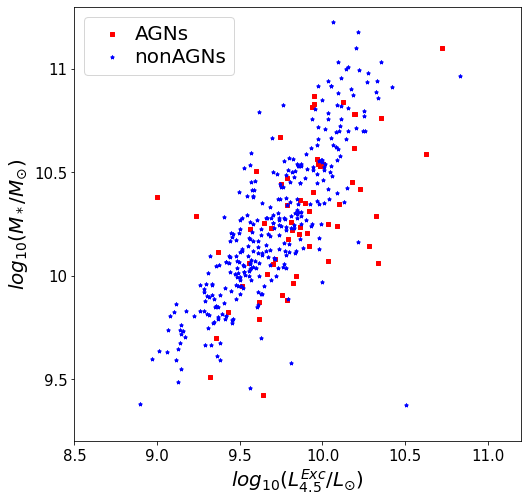

In [91]:
# ; plot fitting results
xxx = np.linspace(8.5,11.5,100)
plt.figure(figsize=[8,8])
# plt.plot(xxx,agn_res.intercept+agn_res.slope*xxx,color='purple')
# plt.plot(xxx,nonagn_res.intercept+nonagn_res.slope*xxx,color='purple')
plt.scatter(agn_l4p5sf,agn_mass,marker='s',s=13,color='red',label='AGNs')
plt.scatter(nonagn_l4p5sf,nonagn_mass,marker='*',s=13,color='blue',label='nonAGNs')
plt.xlim(8.5,11.2)
plt.ylim(9.2,11.3)
plt.xlabel('$log_{10}(L_{4.5}^{Exc}/L_{\odot})$',fontsize=20)
plt.ylabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks([9.5,10,10.5,11],[9.5,10,10.5,11],fontsize=15)
plt.legend(fontsize=20,handletextpad=0.1,labelspacing=0.2)
plt.savefig('/Users/lpr/Data/lirg_project/output/images/mass_correction_radec_del.pdf')

In [15]:
smallSFGs_id=np.array(idx_list)
smallSFGs_params=np.array(param_list)
print(smallSFGs_id)

[   11054    19267    11519    23844    27302    12353 13017707 13004291]


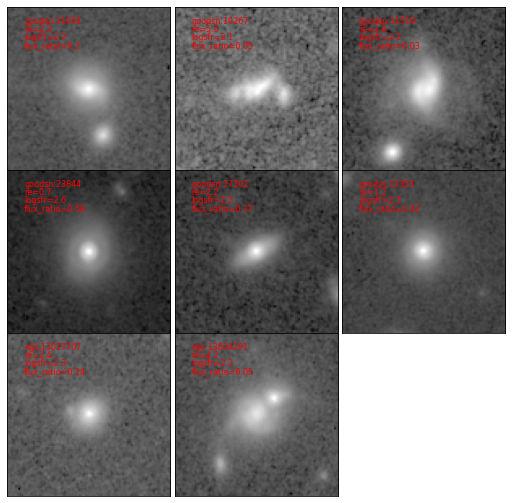

In [25]:
from lpr.image.display import logstretch
fig=plt.figure(figsize=[3*3,3*3])
gs=fig.add_gridspec(nrows=3,ncols=3,wspace=0,hspace=0)
count=0
flux_ratio_ctg_gdn_agn = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/galfit_agn/goodsn_best_fluxratio.fits',1)
flux_ratio_ctg_gdn_nonagn = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/galfit_nonagn/goodsn_best_fluxratio.fits',1)
flux_ratio_ctg_gds_agn = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/galfit_agn/goodss_best_fluxratio.fits',1)
flux_ratio_ctg_egs_agn = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/galfit_agn/egs_best_fluxratio.fits',1)
for num in range(0,len(hdu1)):
    for gala in smallSFGs_id:
        if hdu1[num]['id']==gala:
            img=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/goodsn/goodsn_f160w/goodsn_f160w_'+str(gala)+'.fits',0)
            if gala == 19267:
                f_r = flux_ratio_ctg_gdn_nonagn[flux_ratio_ctg_gdn_nonagn['id']==gala]['flux_ratio'][0]
            else:
                f_r = flux_ratio_ctg_gdn_agn[flux_ratio_ctg_gdn_agn['id']==gala]['flux_ratio'][0]
            r=int(count/3)
            c=int(count-r*3)
            ax=fig.add_subplot(gs[r,c])
            ax.imshow(logstretch(img,a=500),cmap='binary_r')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(10,10,'goodsn:'+str(gala),fontsize=8,color='red')
            ax.text(10,15,'re='+str(np.around(smallSFGs_params[smallSFGs_id==gala][0,0],1)),color='red',fontsize=8)
            ax.text(10,20,'logsfr='+str(np.around(smallSFGs_params[smallSFGs_id==gala][0,1],1)),color='red',fontsize=8)
            ax.text(10,25,'flux_ratio='+str(np.around(f_r,2)),color='red',fontsize=8)
            count+=1
#             print(np.log10(hdu1[num]['l4p5ex']))
for num in range(0,len(hdu2)):
    for gala in smallSFGs_id:
        if hdu2[num]['id']==gala:
            img=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/goodss/goodss_f160w/goodss_f160w_'+str(gala)+'.fits',0)
            f_r = flux_ratio_ctg_gds_agn[flux_ratio_ctg_gds_agn['id']==gala]['flux_ratio'][0]
            r=int(count/3)
            c=int(count-r*3)
            ax=fig.add_subplot(gs[r,c])
            ax.imshow(logstretch(img,a=500),cmap='binary_r')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(10,10,'goodss:'+str(gala),fontsize=8,color='red')
            ax.text(10,15,'re='+str(np.around(smallSFGs_params[smallSFGs_id==gala][0,0],1)),color='red',fontsize=8)
            ax.text(10,20,'logsfr='+str(np.around(smallSFGs_params[smallSFGs_id==gala][0,1],1)),color='red',fontsize=8)
            ax.text(10,25,'flux_ratio='+str(np.around(f_r,2)),color='red',fontsize=8)
            count+=1
            #             print(np.log10(hdu2[num]['l4p5ex']))
for num in range(0,len(hdu3)):
    for gala in smallSFGs_id:
        if hdu3[num]['id']==gala:
            img=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/egs/egs_f160w/egs_f160w_'+str(gala)+'.fits',0)
            f_r = flux_ratio_ctg_egs_agn[flux_ratio_ctg_egs_agn['id']==gala]['flux_ratio'][0]
            r=int(count/3)
            c=int(count-r*3)
            ax=fig.add_subplot(gs[r,c])
            ax.imshow(logstretch(img,a=500),cmap='binary_r')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(10,10,'egs:'+str(gala),fontsize=8,color='red')
            ax.text(10,15,'re='+str(np.around(smallSFGs_params[smallSFGs_id==gala][0,0],1)),color='red',fontsize=8)
            ax.text(10,20,'logsfr='+str(np.around(smallSFGs_params[smallSFGs_id==gala][0,1],1)),color='red',fontsize=8)
            ax.text(10,25,'flux_ratio='+str(np.around(f_r,2)),color='red',fontsize=8)
            count+=1
plt.savefig('/Users/lpr/Data/lirg_project/output/images/smallSFGs_f_r.png')
# #             print(np.log10(hdu3[num]['l4p5ex']))
# from lpr.image.display import logstretch
# fig=plt.figure(figsize=[3*3,4*3])
# gs=fig.add_gridspec(nrows=4,ncols=3,wspace=0,hspace=0)
# count=0
# for num in range(0,len(hdu1)):
#     for gala in largeSFGs_id:
#         if hdu1[num]['id']==gala:
#             img=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/goodsn/goodsn_f160w/goodsn_f160w_'+str(gala)+'.fits')
#             r=int(count/3)
#             c=int(count-r*3)
#             ax=fig.add_subplot(gs[r,c])
#             ax.imshow(logstretch(img,a=500),cmap='binary_r')
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.text(10,10,'goodsn:'+str(gala),fontsize=8,color='red')
#             ax.text(10,15,'re='+str(np.around(largeSFGs_params[largeSFGs_id==gala][0,0],1)),color='red',fontsize=8)
#             ax.text(10,20,'logsfr='+str(np.around(largeSFGs_params[largeSFGs_id==gala][0,1],1)),color='red',fontsize=8)
#             count+=1
# #             print(np.log10(hdu1[num]['l4p5ex']))
# for num in range(0,len(hdu2)):
#     for gala in largeSFGs_id:
#         if hdu2[num]['id']==gala:
#             img=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/goodss/goodss_f160w/goodss_f160w_'+str(gala)+'.fits')
#             r=int(count/3)
#             c=int(count-r*3)
#             ax=fig.add_subplot(gs[r,c])
#             ax.imshow(logstretch(img,a=500),cmap='binary_r')
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.text(10,10,'goodss:'+str(gala),fontsize=8,color='red')
#             ax.text(10,15,'re='+str(np.around(largeSFGs_params[largeSFGs_id==gala][0,0],1)),color='red',fontsize=8)
#             ax.text(10,20,'logsfr='+str(np.around(largeSFGs_params[largeSFGs_id==gala][0,1],1)),color='red',fontsize=8)
#             count+=1
#             #             print(np.log10(hdu2[num]['l4p5ex']))
# for num in range(0,len(hdu3)):
#     for gala in largeSFGs_id:
#         if hdu3[num]['id']==gala:
#             img=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/egs/egs_f160w/egs_f160w_'+str(gala)+'.fits')
#             r=int(count/3)
#             c=int(count-r*3)
#             ax=fig.add_subplot(gs[r,c])
#             ax.imshow(logstretch(img,a=500),cmap='binary_r')
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.text(10,10,'egs:'+str(gala),fontsize=8,color='red')
#             ax.text(10,15,'re='+str(np.around(largeSFGs_params[largeSFGs_id==gala][0,0],1)),color='red',fontsize=8)
#             ax.text(10,20,'logsfr='+str(np.around(largeSFGs_params[largeSFGs_id==gala][0,1],1)),color='red',fontsize=8)
#             count+=1
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/largeSFGs.png')
#             print(np.log10(hdu3[num]['l4p5ex']))

<ipython-input-186-f1d7334ebd34>:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
<ipython-input-186-f1d7334ebd34>:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:


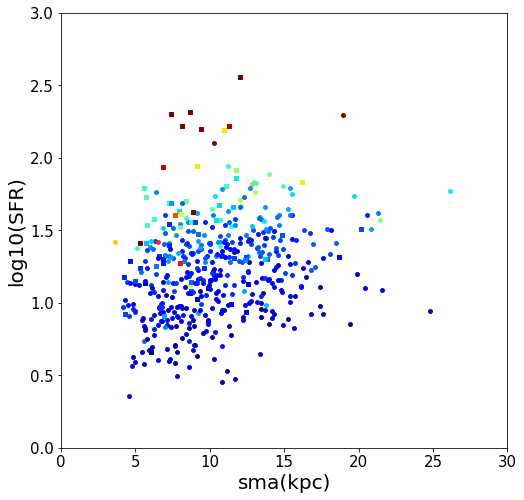

In [186]:
import matplotlib as mpl
from matplotlib.lines import Line2D
symbols={1:'s',2:'o',3:'o',5:'o'}
plt.figure(figsize=[8,8])
param_list = []
for num2 in range(0,len(hdu1)):
    idx=hdu1[num2]['id']
    logsfr=np.log10(hdu1[num2]['sfr_huang'])
    tmp_class=hdu1[num2]['tmp_class'][0]
    z = hdu1[num2]['z_used']
    m = hdu1[num2]['lmass_candels']
    count_spec = hdu1_pair[hdu1_pair['id']==idx]['count_spec'][0]
    gini = hdu1_merger[hdu1_merger['id']==idx]['gini_coeff_statmorph']
    m20 = hdu1_merger[hdu1_merger['id']==idx]['moment_20_statmorph']
    if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
        color='red'
    elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
        color='blue'
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    param_list.append(deltaMS)
    if hdu1_re[hdu1_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu1_re[hdu1_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu1[num2]['n_f160w']
    re=(hdu1_sma[hdu1_sma['id']==idx]['sma'])*0.06*kpc_per_arcsec(hdu1[num2]['z_used'])
#     re=hdu1_re[hdu1_re['id']==idx]['re'][0]*kpc_per_arcsec(hdu1[num2]['z_used'])
#     logsfr=np.log10(hdu1[num2]['sfr_huang'])
#     tmp_class=hdu1[num2]['tmp_class'][0]
#     print(idx,re,logsfr)
    try:
        plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=deltaMS,vmin=0.1,vmax=5,cmap='jet')
#         plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#         plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color)
#         plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=n,vmin=0.2,vmax=4,cmap='jet')#,norm=Norm_bound,cmap=cmap)
    except:
        continue
for num2 in range(0,len(hdu2)):
    idx=hdu2[num2]['id']
    logsfr=np.log10(hdu2[num2]['sfr_huang'])
    tmp_class=hdu2[num2]['tmp_class'][0]
    z = hdu2[num2]['z_used']
    m = hdu2[num2]['lmass_candels']
    count_spec = hdu2_pair[hdu2_pair['id']==idx]['count_spec'][0]
    gini = hdu2_merger[hdu2_merger['id']==idx]['gini_coeff_statmorph']
    m20 = hdu2_merger[hdu2_merger['id']==idx]['moment_20_statmorph']
    if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
        color='red'
    elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
        color='blue'
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    param_list.append(deltaMS)
    if hdu2_re[hdu2_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu2_re[hdu2_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu2[num2]['n_f160w']
    re=(hdu2_sma[hdu2_sma['id']==idx]['sma'])*0.06*kpc_per_arcsec(hdu2[num2]['z_used'])
#     re=hdu2_re[hdu2_re['id']==idx]['re'][0]*kpc_per_arcsec(hdu2[num2]['z_used'])
#     logsfr=np.log10(hdu2[num2]['sfr_huang'])
#     tmp_class=hdu2[num2]['tmp_class'][0]
#     print(idx,re,logsfr)
    try:
        plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=deltaMS,vmin=0.1,vmax=5,cmap='jet')
#         plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#         plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color)
#         plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=n,vmin=0.2,vmax=4,cmap='jet')#,norm=Norm_bound,cmap=cmap)
    except:
        continue
for num2 in range(0,len(hdu3)):
    idx=hdu3[num2]['id']
    logsfr=np.log10(hdu3[num2]['sfr_huang'])
    tmp_class=hdu3[num2]['tmp_class'][0]
    z = hdu3[num2]['z_used']
    m = hdu3[num2]['lmass_candels']
    count_spec = hdu3_pair[hdu3_pair['id']==idx]['count_spec'][0]
    gini = hdu3_merger[hdu3_merger['id']==idx]['gini_coeff_statmorph']
    m20 = hdu3_merger[hdu3_merger['id']==idx]['moment_20_statmorph']
    if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
        color='red'
    elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
        color='blue'
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    param_list.append(deltaMS)
    if hdu3_re[hdu3_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu3_re[hdu3_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu3[num2]['n_f160w']
    re=(hdu3_sma[hdu3_sma['id']==idx]['sma'])*0.06*kpc_per_arcsec(hdu3[num2]['z_used'])
#     re=hdu3_re[hdu3_re['id']==idx]['re'][0]*kpc_per_arcsec(hdu3[num2]['z_used'])
#     logsfr=np.log10(hdu3[num2]['sfr_huang'])
#     tmp_class=hdu3[num2]['tmp_class'][0]
#     print(idx,re,logsfr)
    try:
        plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=deltaMS,vmin=0.1,vmax=5,cmap='jet')
#         plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])
#         plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color)
#         plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=n,vmin=0.2,vmax=4,cmap='jet')#,norm=Norm_bound,cmap=cmap)
    except:
        continue
plt.xlim(0,30)
plt.ylim(0,3)#-1
plt.ylabel('log10(SFR)',fontsize=20)
plt.xlabel('sma(kpc)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# cb = plt.colorbar(extend='max')
# cb.set_label('n',fontsize=15)#$SFR/SFR_{MS}$
# cb.ax.tick_params(labelsize=10)
# legend_elements=[Line2D([0],[0],lw=0,marker='P',label='pair_spec',color='red'),Line2D([0],[0],lw=0,marker='*',color='blue',label='non pair')]
# legend_elements=[Line2D([0],[0],lw=0,marker='s',label=r'AGNs',color='black'),Line2D([0],[0],lw=0,marker='o',color='black',label=r'non AGNs'),Line2D([0],[0],lw=0,marker='o',color='gray',alpha=0.3,label=r'CANDELS')]#]
# plt.legend(handles=legend_elements,fontsize=10,loc='upper left',bbox_to_anchor=[0.7,0.2]) 
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/smasfr_radec_del_candels_MScoded.pdf')#_MScoded  pair

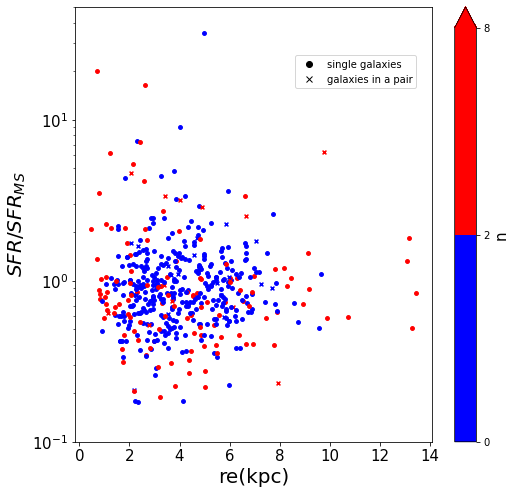

In [63]:
import matplotlib as mpl
from matplotlib.lines import Line2D
cmap = (mpl.colors.ListedColormap(['blue', 'red']))
Norm_bound = mpl.colors.BoundaryNorm([0,2,8], cmap.N)
plt.figure(figsize=[8,8])
plt.ylabel('$SFR/SFR_{MS}$',fontsize=20)
plt.xlabel('re(kpc)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
count = 0
for num2 in range(0,len(hdu1)):
    idx=hdu1[num2]['id']
    logsfr=np.log10(hdu1[num2]['sfr_huang'])
    tmp_class=hdu1[num2]['tmp_class'][0]
    z = hdu1[num2]['z_used']
    m = hdu1[num2]['lmass_candels']
    count_spec = hdu1_pair[hdu1_pair['id']==idx]['count_spec'][0]
    if count_spec>0:
        symbol = 'x'
    else:
        symbol='o'
    re = hdu1_re[hdu1_re['id']==idx]['re'][0]*kpc_per_arcsec(z)
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    if deltaMS>=3:
        count+=1
    if hdu1_re[hdu1_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu1_re[hdu1_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu1[num2]['n_f160w']
    try:
        plt.scatter(re,deltaMS,marker=symbol,s=15,c=n,norm=Norm_bound,cmap=cmap)
    except:
        continue
for num2 in range(0,len(hdu2)):
    idx=hdu2[num2]['id']
    logsfr=np.log10(hdu2[num2]['sfr_huang'])
    tmp_class=hdu2[num2]['tmp_class'][0]
    z = hdu2[num2]['z_used']
    m = hdu2[num2]['lmass_candels']
    count_spec = hdu2_pair[hdu2_pair['id']==idx]['count_spec'][0]
    if count_spec>0:
        symbol = 'x'
    else:
        symbol='o'
    re = hdu2_re[hdu2_re['id']==idx]['re'][0]*kpc_per_arcsec(z)
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    if deltaMS>=3:
        count+=1
    if hdu2_re[hdu2_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu2_re[hdu2_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu2[num2]['n_f160w']
    try:
        plt.scatter(re,deltaMS,marker=symbol,s=15,c=n,norm=Norm_bound,cmap=cmap)
    except:
        continue
for num2 in range(0,len(hdu3)):
    idx=hdu3[num2]['id']
    logsfr=np.log10(hdu3[num2]['sfr_huang'])
    tmp_class=hdu3[num2]['tmp_class'][0]
    z = hdu3[num2]['z_used']
    m = hdu3[num2]['lmass_candels']
    count_spec = hdu3_pair[hdu3_pair['id']==idx]['count_spec'][0]
    if count_spec>0:
        symbol = 'x'
    else:
        symbol='o'
    re = hdu3_re[hdu3_re['id']==idx]['re'][0]*kpc_per_arcsec(z)
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    if deltaMS>=3:
        count+=1
    if hdu3_re[hdu3_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu3_re[hdu3_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu3[num2]['n_f160w']
    try:
        plt.scatter(re,deltaMS,marker=symbol,s=15,c=n,norm=Norm_bound,cmap=cmap)
    except:
        continue
# plt.xlim(0,30)
plt.yscale('log')
plt.ylim(bottom=10**-1,top=50)
cb = plt.colorbar(extend='max')
cb.set_label('n',fontsize=15)
cb.ax.tick_params(labelsize=10)
legend_elements=[Line2D([0],[0],lw=0,marker='o',label='single galaxies',color='black'),Line2D([0],[0],lw=0,marker='x',color='black',label='galaxies in a pair')]
plt.legend(handles=legend_elements,fontsize=10,loc='upper left',bbox_to_anchor=[0.6,0.9]) 
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/re_sfrms_ncoded.pdf')

In [65]:
count/479#样本中的星暴星系占比

0.04384133611691023

In [60]:
print((len(hdu1[hdu1['n_f160w']>2])+len(hdu2[hdu2['n_f160w']>2])+len(hdu3[hdu3['n_f160w']>2]))/(len(hdu1)+len(hdu2)+len(hdu3)))

0.2839248434237996


In [158]:
sfr_merger=[]
sfr_nonmerger=[]
for num in range(0,len(hdu1)):
    idx=hdu1[num]['id']
    logsfr=np.log10(hdu1[num]['sfr_huang'])
    z = hdu1[num]['z_used']
    gini = hdu1_merger[hdu1_merger['id']==idx]['gini_coeff_statmorph']
    m20 = hdu1_merger[hdu1_merger['id']==idx]['moment_20_statmorph']
    count_spec = hdu1_pair[hdu1_pair['id']==idx]['count_spec'][0]
    if hdu1_re[hdu1_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu1_re[hdu1_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu1[num]['n_f160w']
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    if count_spec>0:
#     if n>2.5 and n<=8:
        sfr_merger.append(logsfr)
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    else:
#     elif n>=0.2 and n<=2.5:
        sfr_nonmerger.append(logsfr)
# #     main sequence parameters from lee+15
#     if z>0.78 and z<=0.93:
#         s0,m0,gama = [1.35,9.96,1.28]
#     elif z>0.93 and z<=1.11:
#         s0,m0,gama = [1.53,10.1,1.26]
#     elif z>1.11 and z<=1.3:
#         s0,m0,gama = [1.72,10.31,1.07]
#     deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
#     param_list.append(deltaMS)
#     re=(hdu3_sma[hdu3_sma['id']==idx]['sma'])*0.06*kpc_per_arcsec(hdu3[num2]['z_used'])
for num in range(0,len(hdu2)):
    idx=hdu2[num]['id']
    logsfr=np.log10(hdu2[num]['sfr_huang'])
    z = hdu2[num]['z_used']
    gini = hdu2_merger[hdu2_merger['id']==idx]['gini_coeff_statmorph']
    m20 = hdu2_merger[hdu2_merger['id']==idx]['moment_20_statmorph']
    count_spec = hdu2_pair[hdu2_pair['id']==idx]['count_spec'][0]
    if hdu2_re[hdu2_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu2_re[hdu2_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu2[num]['n_f160w']
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    if count_spec>0:
#     if n>2.5 and n<=8:
        sfr_merger.append(logsfr)
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    else:
#     elif n>=0.2 and n<=2.5:
        sfr_nonmerger.append(logsfr)
for num in range(0,len(hdu3)):
    idx=hdu3[num]['id']
    logsfr=np.log10(hdu3[num]['sfr_huang'])
    z = hdu3[num]['z_used']
    gini = hdu3_merger[hdu3_merger['id']==idx]['gini_coeff_statmorph']
    m20 = hdu3_merger[hdu3_merger['id']==idx]['moment_20_statmorph']
    count_spec = hdu3_pair[hdu3_pair['id']==idx]['count_spec'][0]
    if hdu3_re[hdu3_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu3_re[hdu3_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu3[num]['n_f160w']
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    if count_spec>0:
#     if n>2.5 and n<=8:
        sfr_merger.append(logsfr)
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    else:
#     elif n>=0.2 and n<=2.5:
        sfr_nonmerger.append(logsfr)

In [31]:
sfr_merger=[]
sfr_nonmerger=[]
for num in range(0,len(hdu1)):
    idx=hdu1[num]['id']
    logsfr=np.log10(hdu1[num]['sfr_huang'])
    z = hdu1[num]['z_used']
    m = hdu1[num]['lmass_candels']
#     gini = hdu1_merger[hdu1_merger['id']==idx]['gini_coeff_statmorph']
#     m20 = hdu1_merger[hdu1_merger['id']==idx]['moment_20_statmorph']
    count_spec = hdu1_pair[hdu1_pair['id']==idx]['count_spec'][0]
#     if hdu1_re[hdu1_re['id']==idx]['n_f160w'][0] != -99.:
#         n=hdu1_re[hdu1_re['id']==idx]['n_f160w'][0]
#     else:
#         n=hdu1[num]['n_f160w']
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    if count_spec>0:
#     if n>2 and n<=8:
        sfr_merger.append(deltaMS)
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    else:
#     elif n>=0.2 and n<=2:
        sfr_nonmerger.append(deltaMS)
for num in range(0,len(hdu2)):
    idx=hdu2[num]['id']
    logsfr=np.log10(hdu2[num]['sfr_huang'])
    z = hdu2[num]['z_used']
    m = hdu2[num]['lmass_candels']
#     gini = hdu2_merger[hdu2_merger['id']==idx]['gini_coeff_statmorph']
#     m20 = hdu2_merger[hdu2_merger['id']==idx]['moment_20_statmorph']
    count_spec = hdu2_pair[hdu2_pair['id']==idx]['count_spec'][0]
#     if hdu2_re[hdu2_re['id']==idx]['n_f160w'][0] != -99.:
#         n=hdu2_re[hdu2_re['id']==idx]['n_f160w'][0]
#     else:
#         n=hdu2[num]['n_f160w']
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    if count_spec>0:
#     if n>2 and n<=8:
        sfr_merger.append(deltaMS)
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    else:
#     elif n>=0.2 and n<=2:
        sfr_nonmerger.append(deltaMS)
for num in range(0,len(hdu3)):
    idx=hdu3[num]['id']
    logsfr=np.log10(hdu3[num]['sfr_huang'])
    z = hdu3[num]['z_used']
    m = hdu3[num]['lmass_candels']
#     gini = hdu3_merger[hdu3_merger['id']==idx]['gini_coeff_statmorph']
#     m20 = hdu3_merger[hdu3_merger['id']==idx]['moment_20_statmorph']
    count_spec = hdu3_pair[hdu3_pair['id']==idx]['count_spec'][0]
#     if hdu3_re[hdu3_re['id']==idx]['n_f160w'][0] != -99.:
#         n=hdu3_re[hdu3_re['id']==idx]['n_f160w'][0]
#     else:
#         n=hdu3[num]['n_f160w']
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    if count_spec>0:
#     if n>2 and n<=8:
        sfr_merger.append(deltaMS)
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
    else:
#     elif n>=0.2 and n<=2:
        sfr_nonmerger.append(deltaMS)

In [33]:
print(np.sort(sfr_merger))
print(len(sfr_merger))
# print(sfr_nonmerger)
# print(len(sfr_nonmerger))

[0.20912716 0.23071439 0.53140313 0.59591097 0.62123405 0.62810237
 0.68323324 0.75065717 0.78798533 0.80975316 0.81237707 0.90275081
 0.94363378 0.95627009 0.96281198 1.04918715 1.08197984 1.09539852
 1.22641393 1.44112133 1.63632666 1.71516237 1.7602501  1.84286223
 2.25088303 2.53489675 2.86845186 3.17948007 3.36410913 4.67064293
 6.30248504]
31


In [40]:
from scipy.stats import ks_2samp
print(ks_2samp(sfr_merger,sfr_nonmerger))

KstestResult(statistic=0.23876728110599077, pvalue=0.060884779220741723)


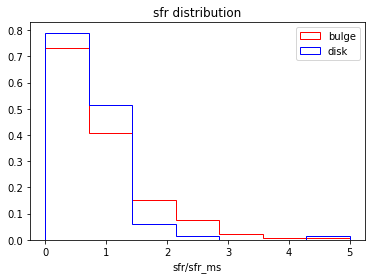

In [177]:
sfr_merger=np.array(sfr_merger)
sfr_nonmerger=np.array(sfr_nonmerger)
# plt.hist(sfr_merger,color='red',range=[0,3],bins=10,histtype='step',label='pair',density=True)#merger bulge
# plt.hist(sfr_nonmerger,color='blue',range=[0,3],bins=10,histtype='step',label='nonpair',density=True)#nonmerger disk
plt.hist(sfr_merger,color='red',range=[0,5],bins=7,histtype='step',label='bulge',density=True)#merger bulge pair
plt.hist(sfr_nonmerger,color='blue',range=[0,5],bins=7,histtype='step',label='disk',density=True)#nonmerger disk nonpair
plt.xlabel('sfr/sfr_ms')
plt.legend()
plt.title('sfr distribution')
plt.savefig('./output/images/deltaMS_n15.png')

<BarContainer object of 20 artists>

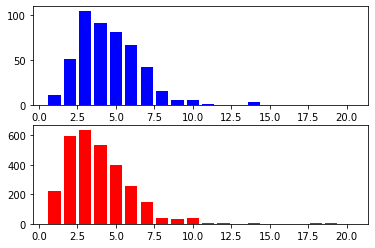

In [99]:
h,binedge=np.histogram(np.concatenate((hdu1['re_f160w'],hdu2['re_f160w'],hdu3['re_f160w']),axis=0),bins=20,range=[0,20])
h_can,binedge_can=np.histogram(np.concatenate((hdu1_candels_copy['re_f160w'],hdu2_candels_copy['re_f160w'],hdu3_candels_copy['re_f160w']),axis=0),bins=20,range=[0,20])
plt.subplot(211)
plt.bar(binedge[1:],h,color='blue')
plt.subplot(212)
plt.bar(binedge_can[1:],h_can,color='red')

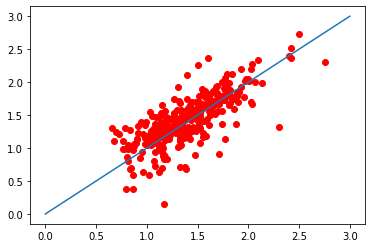

In [100]:
for num in range(0,len(hdu1)):
    idx_candels = hdu1[num]['id_candels']
    sfr_huang = hdu1[num]['sfr_huang']
    ssfr_candels = hdu1[num]['ssfr_uv_corr']
    mass_candels = hdu1[num]['lmass_candels']
    plt.scatter(np.log10(sfr_huang/0.63),np.log10(10**ssfr_candels*10**mass_candels/1.06),color='red')
x=np.linspace(0,3,100)
plt.plot(x,x)

12288
23844
24705


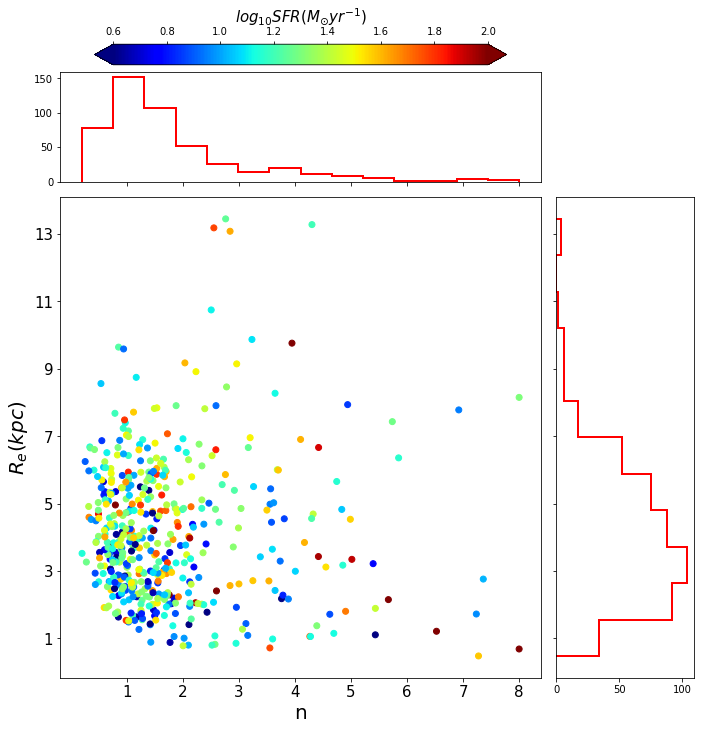

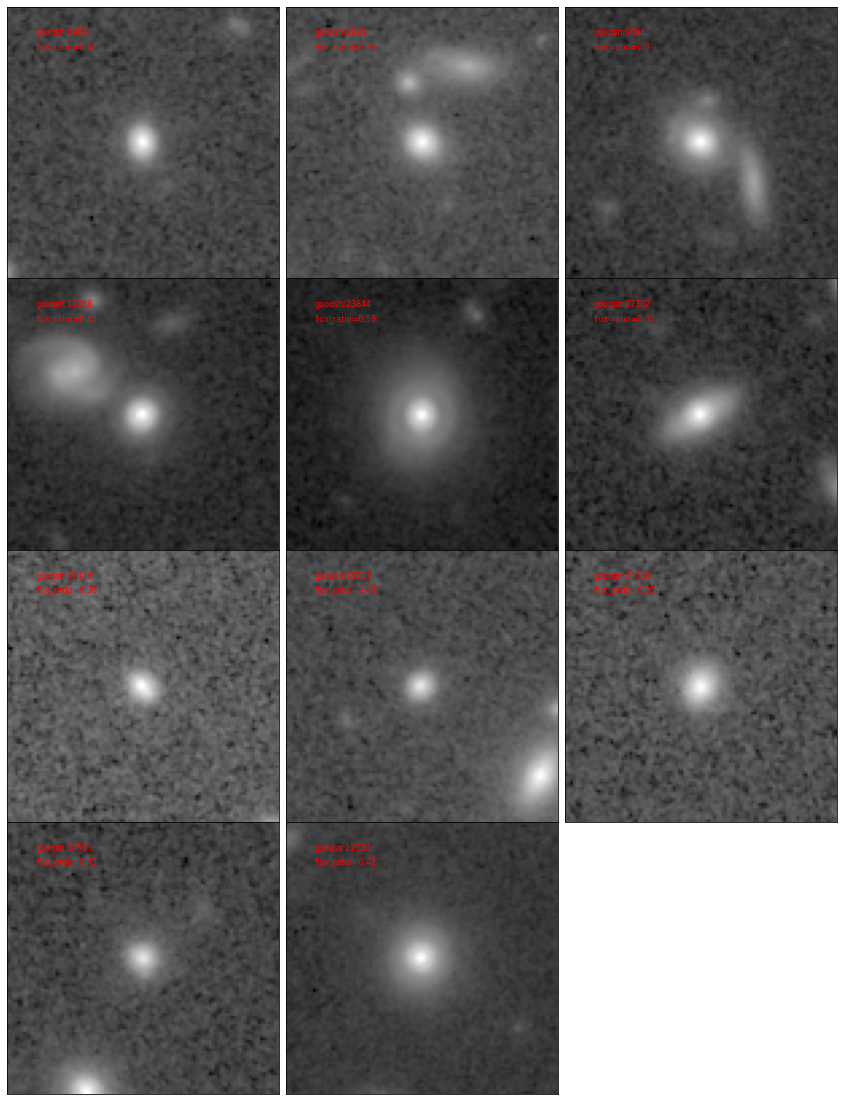

In [2]:
from lpr.image.display import logstretch
import os
fields=['goodsn','goodss','egs']
path = '/Users/lpr/Data/lirg_project/output/subpsf/galfit_agn/'
count = 0
fig=plt.figure(figsize=[3*5,6*5])
gs=fig.add_gridspec(nrows=6,ncols=3,wspace=0,hspace=0)

for field in fields:
    h_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_Huangall_radec_candels.fits',1)
    id_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_id.fits',1)
    h_ctg = h_ctg[np.isin(h_ctg['id'],id_ctg['id'])]
    h_ctg = h_ctg[h_ctg['tmp_class'][:,0]==1]
    fr_ctg = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/galfit_agn/'+field+'_best_fluxratio.fits',1)
    for num1 in range(0,len(h_ctg)):
        idx = h_ctg[num1]['id']
        if 'galfit.20' in os.listdir(path+field+'_f160w_'+str(idx)) and fr_ctg[fr_ctg['id']==idx]['flux_ratio'][0] > 0.3:
            img=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'/'+field+'_f160w/'+field+'_f160w_'+str(idx)+'.fits',0)
            f_r = fr_ctg[fr_ctg['id']==idx]['flux_ratio'][0]
            r=int(count/3)
            c=int(count-r*3)
            ax=fig.add_subplot(gs[r,c])
            ax.imshow(logstretch(img,a=300),cmap='binary_r')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(10,10,field+':'+str(idx),fontsize=8,color='red')
            ax.text(10,15,'flux_ratio='+str(np.around(f_r,2)),color='red',fontsize=8)
            count+=1
plt.savefig('/Users/lpr/Data/lirg_project/output/images/agn_highfr.png')

In [45]:
from astropy.io import fits
import numpy as np
count = 0
for field in fields:
    hdu_id=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_id.fits',1)
    hdu=fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/'+field+'_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits',1)
    hdu=hdu[np.isin(hdu['id'],hdu_id['id'])]
    print(max(hdu['separation_candels_huang']),min(hdu['separation_candels_huang']))
    count += len(hdu)
print(count)

0.0 0.0
0.0 0.0
0.8766687082614656 0.00631745089725897
479


<ipython-input-78-13f658fb21fe>:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max')#$SFR/SFR_{MS}$


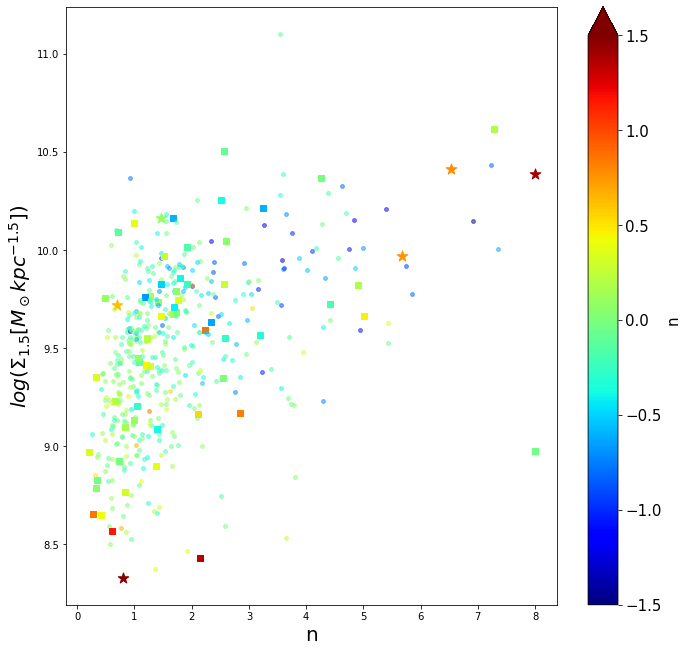

In [78]:
# barro diagram
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-1.5,vmax=1.5)
pixel_scale = 0.06
fig = plt.figure(figsize=(11,11))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0])
# ax.plot([10.4,10.4],[-2.5,2.5],color='black')
# ax.plot([7.5,11.5],[-0.5,-0.5],color='black')
fields_list = ['goodsn','goodss','egs']
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    all_catalog = fits.getdata(root_path+field+'_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits',1)
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    all_catalog = all_catalog[np.isin(all_catalog['id'],id_ctg['id'])]
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    for num1 in range(all_catalog.size):
        idx = all_catalog[num1]['id']
        mass = all_catalog[num1]['lmass_candels']
        z = all_catalog[num1]['z_used']
        sfr = all_catalog[num1]['sfr_huang']
        logsfr = np.log10(sfr)
        sed_class = all_catalog[num1]['tmp_class'][0]
        re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z) 
        if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
            n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
        else:
            n=all_catalog[num1]['n_f160w']
#         if idx in subpsf_catalog['id']:
#             re = subpsf_catalog[subpsf_catalog['id']==idx]['re_sersic'][0]*pixel_scale*kpc_per_arcsec(z)
#             n = subpsf_catalog[subpsf_catalog['id']==idx]['n_sersic'][0]
#         else:
#             re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z) 
#             if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
#                 n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
#             else:
#                 n=all_catalog[num1]['n_f160w']
        if z>0.78 and z<=0.93:
            s0,m0,gama = [1.35,9.96,1.28]
        elif z>0.93 and z<=1.11:
            s0,m0,gama = [1.53,10.1,1.26]
        elif z>1.11 and z<=1.3:
            s0,m0,gama = [1.72,10.31,1.07]
        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
        if idx in smallSBs:
            symbol = '*'
            size = 125
            alpha = 1
#             ax.text(np.log10(10**mass/re**1.5),np.log10((sfr/10**mass)*1e9),str(idx))
        elif sed_class==1:
            symbol = 's'
            size = 40
            alpha = 1
        else:
            symbol = 'o'
            size = 15
            alpha = 0.5
        ax.scatter(n,np.log10(10**mass/re**1.5),c=np.log10((sfr/10**mass)*1e9),marker=symbol,s=size,alpha=alpha,cmap='jet',vmin=-1.5,vmax=1.5)#
ax.set_ylabel('$log(\Sigma_{1.5}[M_\odot kpc^{-1.5}])$',fontsize=20)
ax.set_xlabel('n',fontsize=20)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max')#$SFR/SFR_{MS}$
cb.set_label(label='n',fontsize=15) #SFR/SFR$_{MS}$
cb.ax.tick_params(labelsize=15)
# plt.savefig(path+'output/images/ssfr_n.png')

<ipython-input-86-7b9d861c54bd>:25: RuntimeWarning: divide by zero encountered in log10
  l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])
<ipython-input-86-7b9d861c54bd>:26: RuntimeWarning: divide by zero encountered in double_scalars
  e4p5ex = all_catalog[num1]['e4p5ex']/(all_catalog[num1]['l4p5ex']*np.log(10))


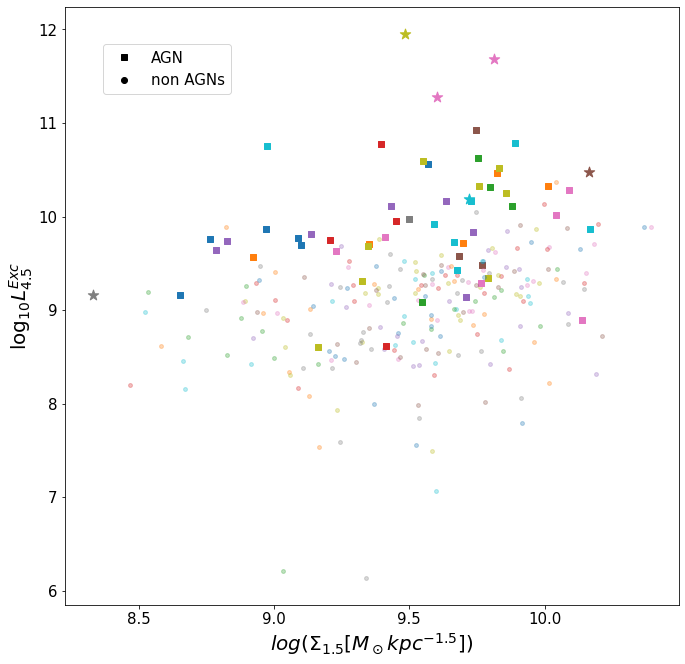

In [86]:
# smallagn=np.array([11054, 19267, 11519, 23844, 27302, 12353, 13017707, 13004291])
# agn strength morphology diagram
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=9.5,vmax=10.5)
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
fields_list = ['goodsn','goodss','egs']
pixel_scale = 0.06
fig = plt.figure(figsize=(11,11))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0])

for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    all_catalog = fits.getdata(root_path+field+'_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits',1)
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    all_catalog = all_catalog[np.isin(all_catalog['id'],id_ctg['id'])]
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_sersic.fits',1)
    for num1 in range(0,all_catalog.size):
        idx = all_catalog[num1]['id']
        idx_candels = all_catalog[num1]['id_candels']
        z = all_catalog[num1]['z_used']
        sfr = all_catalog[num1]['sfr_huang']
        logsfr = np.log10(sfr)
        sed_class = all_catalog[num1]['tmp_class'][0]
        l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])
        e4p5ex = all_catalog[num1]['e4p5ex']/(all_catalog[num1]['l4p5ex']*np.log(10))
        mass = all_catalog[num1]['lmass_candels']
#         re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z) 
        if z>0.78 and z<=0.93:
            s0,m0,gama = [1.35,9.96,1.28]
        elif z>0.93 and z<=1.11:
            s0,m0,gama = [1.53,10.1,1.26]
        elif z>1.11 and z<=1.3:
            s0,m0,gama = [1.72,10.31,1.07]
        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**mass/10**m0)**(-1*gama))))
#         if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
#             n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
#         else:
#             n=all_catalog[num1]['n_f160w']
        if idx in subpsf_catalog['id']:
            re = subpsf_catalog[subpsf_catalog['id']==idx]['re_sersic'][0]*pixel_scale*kpc_per_arcsec(z)
            n = subpsf_catalog[subpsf_catalog['id']==idx]['n_sersic'][0]
        else:
            re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z) 
            if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
                n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
            else:
                n=all_catalog[num1]['n_f160w']
        if idx in smallSBs:
            symbol = '*'
            size = 120
            ax.scatter(np.log10(10**mass/re**1.5),l4p5ex,marker=symbol,s=size,alpha=1)
        elif sed_class==1:
            symbol = 's'
            size = 40
            ax.scatter(np.log10(10**mass/re**1.5),l4p5ex,marker=symbol,s=size,alpha=1)
#             if idx in smallagn:
#                 ax.errorbar(np.log10(n),l4p5ex,xerr=dn/(n*np.log(10)))
#                 ax.scatter(np.log10(n),l4p5ex,marker='*',c=re,s=205,cmap='jet',vmin=0.1,vmax=10,alpha=alpha)
#             ax.text(np.log10(n),l4p5ex,idx)
#             print(idx,n)
        else:
            symbol = 'o'
            size = 15
            ax.scatter(np.log10(10**mass/re**1.5),l4p5ex,marker=symbol,s=size,alpha=0.3)
# ax.set_xlim(-0.8,1.1)

ax.set_xlabel('$log(\Sigma_{1.5}[M_\odot kpc^{-1.5}])$',fontsize=20)
ax.set_ylabel('log$_{10}L_{4.5}^{Exc}$',fontsize=20)
ax.tick_params(axis='both',labelsize=15)
legend_elements=[Line2D([0],[0],lw=0,marker='s',color='black',label=r'AGN'),Line2D([0],[0],lw=0,marker='o',color='black',label='non AGNs')]
plt.legend(handles=legend_elements,fontsize=15,loc='upper left',bbox_to_anchor=[0.05,0.95])
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/l4p5ex_n_sfrcoded.pdf')

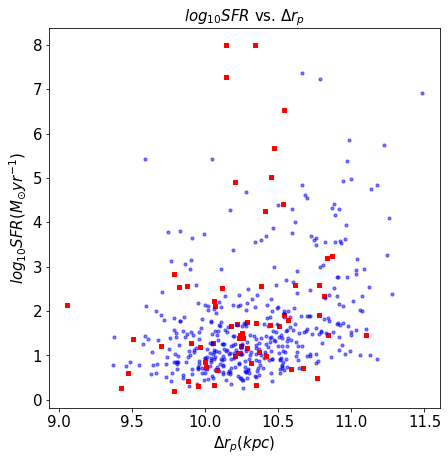

In [5]:
# logsfr vs. separation
plt.figure(figsize=[7,7])
plt.title('$log_{10}SFR$ vs. $\Delta r_p$',fontsize=15)
plt.xlabel('$\Delta r_p (kpc)$',fontsize=15)
plt.ylabel('$log_{10}SFR(M_{\odot} yr^{-1})$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# sep_all=[]
# logssfr_all=[]
fields = ['goodsn','goodss','egs']
candels_field = {'goodsn':'gdn_all','goodss':'gds_all_ssfr','egs':'egs_all'}
for field in fields:
    hdu = fits.getdata(path+'output/catalog_radec/'+field+'_Huangall_candels_van_params_zmasshuangsfr.fits',1)
    hdu_id = fits.getdata(path+'output/catalog_radec/'+field+'_id.fits',1)
    hdu = hdu[np.isin(hdu['id'],hdu_id['id'])]
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    for num in range(len(hdu)):
        idx = hdu[num]['id']
        lmass_candels = hdu[num]['lmass_candels']
        z = hdu[num]['z_used']
        sed_class = hdu[num]['tmp_class'][0]
        if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
            n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
        else:
            n=hdu[num]['n_f160w']
        if sed_class==1:
            color='red'
            symbol='s'
            size=20
            alpha=1
        else:
            color='blue'
            symbol='o'
            size=10
            alpha=0.5
        plt.scatter(lmass_candels,n,c=color,marker=symbol,s=size,alpha=alpha)
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/sfraverage_separation.pdf')